In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import impyute.imputation as imp
from statsmodels.tsa.stattools import adfuller
import statistics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

In [2]:
# Função para completar os dados faltantes
def completa_serie(dados,ano):
    print('-'*50)
    print('-'*24,ano,'-'*20)
    print('-'*50)
    
    # Reseta o index da série para ser por linha
    miss_dados = dados.isna().sum().sum()/(dados.shape[0]*dados.shape[1])*100
    print(f'{miss_dados.round(2)}% dos dados da bases são faltantes')
    
    # Completa os dados por Expect Maximization(EM)
    dados_filled = imp.cs.em(dados.values,loops=50)    
    d = [str(i) for i in range(1,25)]
    dados_completados = pd.DataFrame(data=dados_filled.round(0),columns=d)
    
    # Dados completados por EM
    print('*'*40,'  Base de dados completada  ','*'*40)
    display(dados_completados.head())

    # Formato da base dados
    print('*'*40,'  Formato da base dados  ','*'*40)
    display(dados_completados.shape)

    # Média diária dos dados
    print('*'*40,'Média diária dos dados','*'*40)
    dados_medios_completados = dados_completados.mean(axis='columns')
    display(dados_medios_completados)
    
    return dados_medios_completados

# Aplicar o Teste de Dickey-Fuller
def teste_estacionariedade(serie_temporal):
    
    #Teste estatístico
    print('Resultados do teste Dickey Fuller:')
    dftest = adfuller(serie_temporal.values)
    p_value = dftest[1]
    dfoutput = pd.Series(dftest[0:4], index=['Teste estatístico','p-value','#Lags Usados','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valores críticos (%s)'%key] = value
    print(dfoutput)
    return p_value

def MAPE(serie_suavizada,serie_original):
    return sum(abs((serie_suavizada-serie_original)*100)/serie_original)/serie_suavizada.shape[0]

def MQE(serie_suavizada,serie_original):
    return sum(pow(serie_suavizada-serie_original,2))/serie_suavizada.shape[0]

def MAE(serie_suavizada,serie_original):
    return sum(abs(serie_suavizada-serie_original))/serie_suavizada.shape[0]


def alisar_serie(serie_temporal_n_tratada,p_value,alpha=0.3):
    df_modelo_suavisado,df_suavisado = pd.DataFrame({}),pd.DataFrame({})
    vMAPE,vMAE,vMQE = [],[],[]
    
    if p_value < 0.05:
        janelas = [5,15,25,35,45,55,65,75]
        for janela in janelas:
            #Média movel para séries estácionária
            modelo_suavisado = serie_temporal_n_tratada.rolling(janela).mean()
            
            modelo_suavisado.reset_index(drop=True,inplace=True)
            modelo_suavisado.dropna(inplace=True)
            df_modelo_suavisado = df_modelo_suavisado.append(modelo_suavisado,ignore_index=True)
            
            vMAPE.append(MAPE(modelo_suavisado,serie_temporal_n_tratada[janela-1:]))
            vMAE.append(MAE(modelo_suavisado,serie_temporal_n_tratada[janela-1:]))
            vMQE.append(MQE(modelo_suavisado,serie_temporal_n_tratada[janela-1:]))
            
        moda = statistics.mode([vMAPE.index(min(vMAPE)),vMAE.index(min(vMAE)),vMQE.index(min(vMQE))])
        df_modelo_suavisado = df_modelo_suavisado.T
        df_suavisado = df_modelo_suavisado[moda].dropna()
        
    elif p_value > 0.05:
            modelo_suavisado = [serie_temporal_n_tratada[0]] # first value is same as series
            for n in range(1, len(serie_temporal_n_tratada)):
                modelo_suavisado.append(alpha * serie_temporal_n_tratada[n] + (1 - alpha) * modelo_suavisado[n-1])                
            df_suavisado = df_suavisado.append(modelo_suavisado,ignore_index=True)
            vMAPE.append(MAPE(df_suavisado,serie_temporal_n_tratada))
            vMAE.append(MAE(df_suavisado,serie_temporal_n_tratada))
            vMQE.append(MQE(df_suavisado,serie_temporal_n_tratada))

    
    print(f'MAPE:{min(vMAPE)}')
    print(f'MAE:{min(vMAE)}')
    print(f'MQE:{min(vMQE)}')
    #Plotar valores para verficar visualmente
    plt.figure(figsize=(40,5))
    st_plot = plt.plot(serie_temporal_n_tratada,'*-', color='red',label='Original')
    st_plot = plt.plot(df_suavisado,'*-', color='blue',label='Suavizado')
    plt.legend(loc='best')
    plt.show(block=False)
    
    return df_suavisado

# Etapa 1: Carregar os dados

In [3]:
dados2016 = pd.read_csv('..\/01.Dados\/CSV\/MP10_Interlagos_2016.csv')
dados2017 = pd.read_csv('..\/01.Dados\/CSV\/MP10_Interlagos_2017.csv')
dados2018 = pd.read_csv('..\/01.Dados\/CSV\/MP10_Interlagos_2018.csv')
dados2019 = pd.read_csv('..\/01.Dados\/CSV\/MP10_Interlagos_2019.csv')
dados2020 = pd.read_csv('..\/01.Dados\/CSV\/MP10_Interlagos_2020.csv')

# Etapa 2: Tratamento de dados faltantes

In [4]:
dados_medios_completados_2016 = completa_serie(dados2016,2016)
dados_medios_completados_2017 = completa_serie(dados2017,2017)
dados_medios_completados_2018 = completa_serie(dados2018,2018)
dados_medios_completados_2019 = completa_serie(dados2019,2019)
dados_medios_completados_2020 = completa_serie(dados2020,2020)

--------------------------------------------------
------------------------ 2016 --------------------
--------------------------------------------------
6.01% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1     2     3     4     5     6     7     8     9    10  ...    15  \
0  29.0  38.0  34.0  21.0  15.0  12.0   6.0   4.0   2.0   4.0  ...   6.0   
1  11.0  30.0  17.0   4.0   9.0   6.0   1.0   7.0   3.0  16.0  ...  12.0   
2   2.0   6.0  12.0   4.0  10.0   2.0   1.0   4.0   7.0   1.0  ...   4.0   
3   8.0  44.0  20.0  15.0  12.0  14.0  13.0  23.0  10.0  17.0  ...  24.0   
4  13.0  33.0  19.0  14.0  11.0   8.0  11.0  10.0   9.0  14.0  ...  31.0   

     16    17    18    19    20    21    22    23    24  
0  14.0  12.0  16.0  19.0  20.0  38.0  25.0  22.0  47.0  
1  19.0   7.0   0.0   2.0  12.0  11.0   7.0   6.0   0.0  
2   6.0   5.0   3.0  11.0  10.0   6.0   5.0   7.0  10.0  
3  16.0  18.0  28.0  35.0  21.0  26.0  13.0  16.0  24.0  
4  28.0  37.0  32.0  27.0  26.0  28.0  26.0  18.0  19.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(213, 24)

**************************************** Média diária dos dados ****************************************


0      17.416667
1      12.500000
2       5.708333
3      18.250000
4      19.916667
         ...    
208    37.000000
209    21.583333
210    19.958333
211    28.083333
212    38.125000
Length: 213, dtype: float64

--------------------------------------------------
------------------------ 2017 --------------------
--------------------------------------------------
3.38% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1     2     3     4     5     6     7     8     9    10  ...    15  \
0  57.0  98.0  69.0  62.0  76.0  56.0  48.0  36.0  18.0   9.0  ...  10.0   
1  11.0  32.0  15.0   8.0   8.0  13.0  16.0  16.0  16.0  16.0  ...   5.0   
2  13.0  18.0  19.0  17.0  20.0  21.0  22.0  23.0  30.0  18.0  ...  16.0   
3  13.0  40.0  22.0  12.0  13.0  15.0  15.0  21.0  26.0   9.0  ...   3.0   
4  22.0  40.0  19.0  13.0  15.0  13.0  14.0  23.0  13.0  14.0  ...  15.0   

     16    17    18    19    20    21    22    23    24  
0   9.0   7.0   8.0  24.0  12.0  13.0  15.0  10.0   7.0  
1  10.0  12.0  32.0  17.0  16.0   8.0  12.0   7.0  20.0  
2  15.0  13.0  19.0  30.0  19.0  13.0  18.0   5.0  14.0  
3   8.0  14.0  23.0  17.0  26.0  27.0  13.0  20.0  24.0  
4  17.0  21.0  25.0  24.0  16.0  16.0  19.0  13.0  19.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(212, 24)

**************************************** Média diária dos dados ****************************************


0      28.625000
1      14.041667
2      18.166667
3      17.208333
4      18.000000
         ...    
207    30.583333
208    33.000000
209    34.125000
210    34.833333
211    52.666667
Length: 212, dtype: float64

--------------------------------------------------
------------------------ 2018 --------------------
--------------------------------------------------
2.67% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1     2     3     4     5     6     7     8     9    10  ...    15  \
0  27.0  30.0  18.0  13.0  16.0  13.0  11.0  10.0  14.0  20.0  ...  10.0   
1  16.0  36.0   4.0   8.0   7.0  11.0  22.0   6.0   9.0   8.0  ...   9.0   
2   9.0  34.0  12.0   3.0   5.0   6.0   8.0  11.0  11.0   5.0  ...   3.0   
3   5.0  33.0  19.0  14.0  11.0   9.0  16.0  17.0  22.0  11.0  ...  20.0   
4  24.0  41.0  19.0  15.0  13.0  17.0  19.0  15.0  10.0   8.0  ...  21.0   

     16    17    18    19    20    21    22    23    24  
0  12.0  15.0   7.0  13.0  14.0  17.0  15.0  10.0   9.0  
1  10.0   7.0   5.0  13.0   7.0  21.0   3.0   7.0  12.0  
2  12.0   2.0   1.0   7.0  12.0   3.0   5.0  10.0  10.0  
3  15.0  19.0  19.0  29.0  32.0  26.0  27.0   8.0   6.0  
4  26.0  35.0  20.0  25.0  20.0  24.0  18.0  16.0  25.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(212, 24)

**************************************** Média diária dos dados ****************************************


0      14.000000
1      11.416667
2       7.916667
3      16.666667
4      19.916667
         ...    
207    40.291667
208    49.750000
209    57.458333
210    42.458333
211    13.666667
Length: 212, dtype: float64

--------------------------------------------------
------------------------ 2019 --------------------
--------------------------------------------------
27.85% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1      2     3     4     5     6     7     8     9    10  ...    15  \
0  60.0  100.0  56.0  36.0  30.0  17.0   3.0   6.0  -4.0  27.0  ...   9.0   
1  -1.0  -13.0  72.0  22.0  54.0  25.0  14.0   3.0  12.0  31.0  ...   5.0   
2  25.0   37.0  -3.0  14.0  32.0  18.0  13.0  30.0  34.0  19.0  ...  29.0   
3  -0.0   26.0 -32.0  18.0   7.0   3.0  64.0  47.0  -7.0  -5.0  ...   4.0   
4  53.0   14.0  43.0  12.0  34.0  24.0  -2.0  26.0  15.0  15.0  ...  38.0   

     16    17    18    19    20    21    22    23    24  
0  31.0  -4.0  -1.0   8.0  38.0  21.0  13.0  46.0  -3.0  
1  31.0  34.0  20.0  49.0   9.0  10.0  21.0  62.0  72.0  
2  13.0  13.0  32.0   4.0  35.0  -6.0  56.0  28.0  29.0  
3 -13.0  35.0   0.0  18.0   4.0  18.0  20.0  34.0 -21.0  
4   9.0  31.0  10.0  35.0  40.0  -3.0  11.0  29.0  33.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(212, 24)

**************************************** Média diária dos dados ****************************************


0      22.833333
1      24.541667
2      22.666667
3      11.875000
4      23.958333
         ...    
207    13.791667
208    20.500000
209    13.375000
210    17.583333
211    19.583333
Length: 212, dtype: float64

--------------------------------------------------
------------------------ 2020 --------------------
--------------------------------------------------
13.65% dos dados da bases são faltantes
****************************************   Base de dados completada   ****************************************


1     2     3     4     5     6     7     8     9    10  ...    15  \
0  53.0  82.0  93.0  74.0  61.0  66.0  84.0  55.0  37.0  27.0  ...   8.0   
1   3.0  14.0   9.0  16.0  11.0  11.0  13.0   9.0  17.0  16.0  ...  12.0   
2   1.0   3.0   4.0   3.0   1.0  23.0   0.0   0.0   0.0   1.0  ...   0.0   
3   7.0  12.0  38.0  14.0   5.0   9.0  11.0   8.0  13.0  11.0  ...  33.0   
4  26.0   2.0   5.0   8.0  10.0  35.0  16.0  10.0   5.0   9.0  ...  21.0   

     16    17    18    19    20    21    22    23   24  
0   3.0  33.0  51.0   8.0  27.0  20.0  14.0   7.0  6.0  
1  14.0  18.0  20.0  19.0  17.0  14.0  11.0  12.0  9.0  
2  17.0  19.0   0.0   1.0  11.0  25.0   2.0   1.0  9.0  
3   0.0   1.0   0.0   0.0  29.0   4.0   0.0   0.0  9.0  
4  16.0   2.0   8.0  11.0   3.0  20.0  17.0  10.0  2.0  

[5 rows x 24 columns]

****************************************   Formato da base dados   ****************************************


(213, 24)

**************************************** Média diária dos dados ****************************************


0      36.083333
1      13.625000
2       6.750000
3      10.083333
4      11.958333
         ...    
208    15.583333
209     9.750000
210    12.250000
211     8.791667
212    12.416667
Length: 213, dtype: float64

# Etapa 3: Decompondo cada série

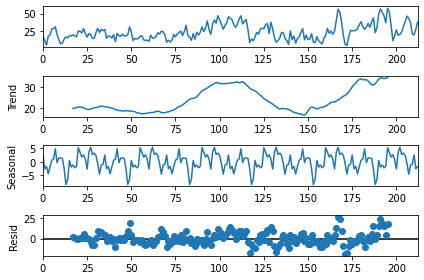

In [5]:
resultado_2016 = seasonal_decompose(dados_medios_completados_2016,period=35)
resultado_2016.plot();

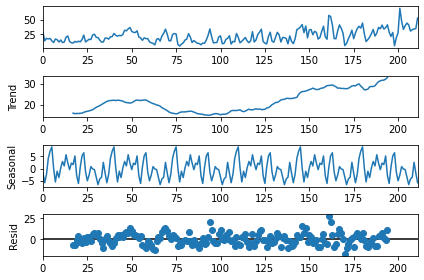

In [6]:
resultado_2017 = seasonal_decompose(dados_medios_completados_2017,period=35)
resultado_2017.plot();

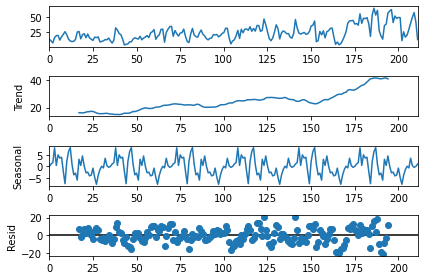

In [7]:
resultado_2018 = seasonal_decompose(dados_medios_completados_2018,period=35)
resultado_2018.plot();

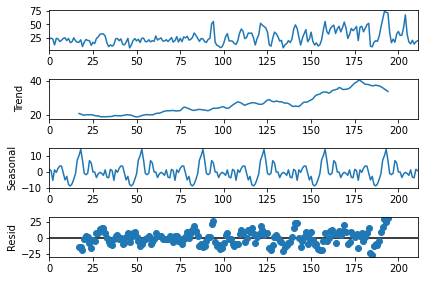

In [8]:
resultado_2019 = seasonal_decompose(dados_medios_completados_2019,period=35)
resultado_2019.plot();

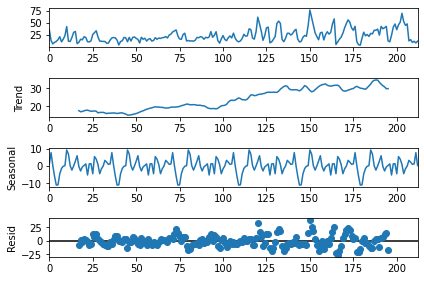

In [9]:
resultado_2020 = seasonal_decompose(dados_medios_completados_2020,period=35)
resultado_2020.plot();

# Etapa 4: Teste Estacionariedade da série
## **Teste de Dickey-Fuller**

Pode ser tamém chamdo de ADF(Augmented Dickey-Fuller):

$\Delta y_t = \beta_t + \beta_{2t} + \delta_{yt-1} + \sum_{i=1}^{m}{\alpha_i \Delta_{yt-1} + \epsilon_t}$

$\beta_1$ - intercepto drift da série

$\beta_2$ - intercepto de tendência

$\delta$  - coeficiente de presença de raiz.

m - número de defasagens tomadas na série.


+ Hipótese nula é se $\delta$ = 0;

Fazemos a regressão de $\Delta_{y_t}$ em que $y_{t-1}$ e repetindo em $\Delta_{y_{t-1}}$ em que $y_{t-2}$ e assim sucesivamente e calculamos a estatística T dada por:

$T = \frac{\delta}{se(\delta)}$

$\^\delta$ - estimador de $\delta$

$se(\^ \delta)$ - estimador do desvio padrão do erro de $\delta$

Resultados do teste Dickey Fuller:
Teste estatístico                -5.332428
p-value                           0.000005
#Lags Usados                      0.000000
Número de observações usadas    212.000000
Valores críticos (1%)            -3.461578
Valores críticos (5%)            -2.875272
Valores críticos (10%)           -2.574089
dtype: float64


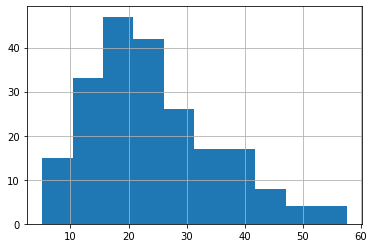

In [10]:
p_v_2016 = teste_estacionariedade(dados_medios_completados_2016)
dados_medios_completados_2016.hist()

Resultados do teste Dickey Fuller:
Teste estatístico                -1.024163
p-value                           0.744350
#Lags Usados                     10.000000
Número de observações usadas    201.000000
Valores críticos (1%)            -3.463309
Valores críticos (5%)            -2.876029
Valores críticos (10%)           -2.574493
dtype: float64


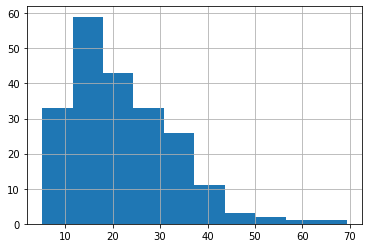

In [11]:
p_v_2017 = teste_estacionariedade(dados_medios_completados_2017)
dados_medios_completados_2017.hist()

Resultados do teste Dickey Fuller:
Teste estatístico                -3.408542
p-value                           0.010671
#Lags Usados                      4.000000
Número de observações usadas    207.000000
Valores críticos (1%)            -3.462342
Valores críticos (5%)            -2.875606
Valores críticos (10%)           -2.574267
dtype: float64


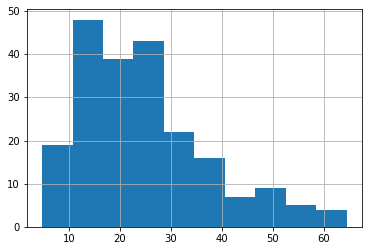

In [12]:
p_v_2018 = teste_estacionariedade(dados_medios_completados_2018)
dados_medios_completados_2018.hist()

Resultados do teste Dickey Fuller:
Teste estatístico              -7.070544e+00
p-value                         4.950401e-10
#Lags Usados                    1.000000e+00
Número de observações usadas    2.100000e+02
Valores críticos (1%)          -3.461879e+00
Valores críticos (5%)          -2.875404e+00
Valores críticos (10%)         -2.574159e+00
dtype: float64


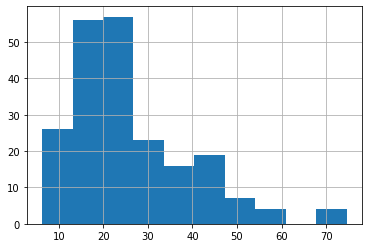

In [13]:
p_v_2019 = teste_estacionariedade(dados_medios_completados_2019)
dados_medios_completados_2019.hist()

Resultados do teste Dickey Fuller:
Teste estatístico              -7.421473e+00
p-value                         6.718711e-11
#Lags Usados                    1.000000e+00
Número de observações usadas    2.110000e+02
Valores críticos (1%)          -3.461727e+00
Valores críticos (5%)          -2.875337e+00
Valores críticos (10%)         -2.574124e+00
dtype: float64


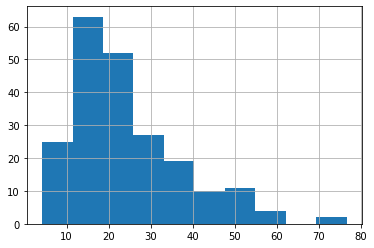

In [14]:
p_v_2020 = teste_estacionariedade(dados_medios_completados_2020)
dados_medios_completados_2020.hist()

# Etapa 5: Autocorrelação para verificar a periodicidade e sazonalidade da série

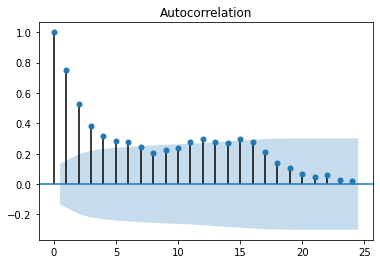

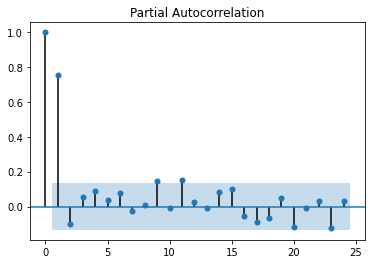

In [15]:
plot_acf(dados_medios_completados_2016);
plot_pacf(dados_medios_completados_2016);

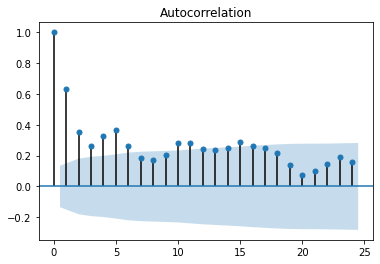

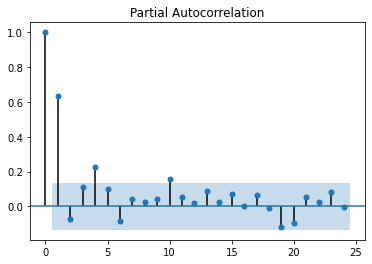

In [16]:
plot_acf(dados_medios_completados_2017);
plot_pacf(dados_medios_completados_2017);

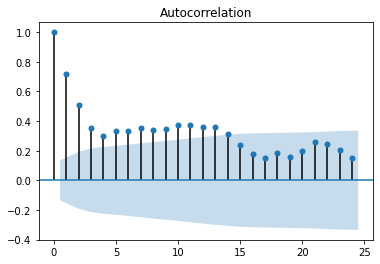

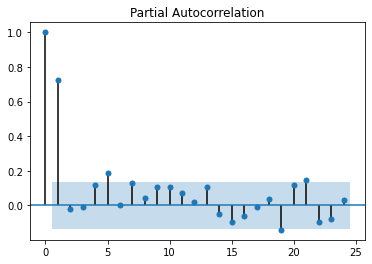

In [17]:
plot_acf(dados_medios_completados_2018);
plot_pacf(dados_medios_completados_2018);

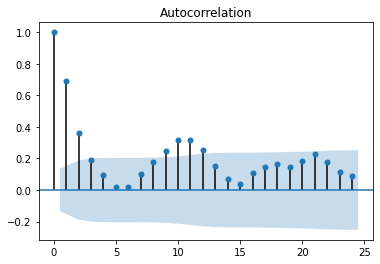

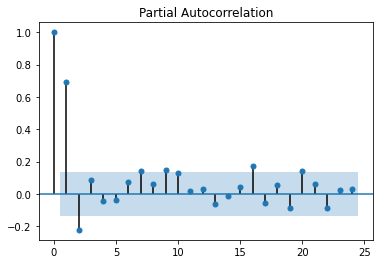

In [18]:
plot_acf(dados_medios_completados_2019);
plot_pacf(dados_medios_completados_2019);

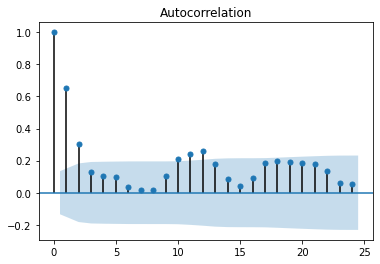

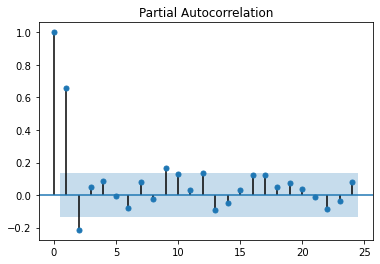

In [19]:
plot_acf(dados_medios_completados_2020);
plot_pacf(dados_medios_completados_2020);

# Etapa 6: Verificando variação nos dados - velocidade de mudança

In [20]:
def ano_bisexto(ano):
    nome_eixo_x = pd.DataFrame({'Dia':[]})
    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-01-0'+str(i)},ignore_index=True)    
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-01-'+str(i)},ignore_index=True)            

    for i in range(1,30):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-02-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-02-'+str(i)},ignore_index=True)           

    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-03-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-03-'+str(i)},ignore_index=True)   


    for i in range(1,31):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-04-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-04-'+str(i)},ignore_index=True)   

    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-05-0'+str(i)},ignore_index=True)       
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-05-'+str(i)},ignore_index=True)       

    for i in range(1,31):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-06-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-06-'+str(i)},ignore_index=True)


    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-07-0'+str(i)},ignore_index=True)       
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-07-'+str(i)},ignore_index=True)

    return nome_eixo_x


def ano_normal(ano):
    nome_eixo_x = pd.DataFrame({'Dia':[]})
    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-01-0'+str(i)},ignore_index=True)    
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-01-'+str(i)},ignore_index=True)            

    for i in range(1,29):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-02-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-02-'+str(i)},ignore_index=True)           

    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-03-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-03-'+str(i)},ignore_index=True)   


    for i in range(1,31):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-04-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-04-'+str(i)},ignore_index=True)   

    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-05-0'+str(i)},ignore_index=True)       
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-05-'+str(i)},ignore_index=True)       

    for i in range(1,31):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-06-0'+str(i)},ignore_index=True)   
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-06-'+str(i)},ignore_index=True)


    for i in range(1,32):
        if i<=9:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-07-0'+str(i)},ignore_index=True)       
        else:
            nome_eixo_x = nome_eixo_x.append({'Dia':str(ano)+'-07-'+str(i)},ignore_index=True)

    return nome_eixo_x


eixo_2016 = ano_bisexto(2016)
eixo_2017 = ano_normal(2017)
eixo_2018 = ano_normal(2018)
eixo_2019 = ano_normal(2019)
eixo_2020 = ano_bisexto(2020)

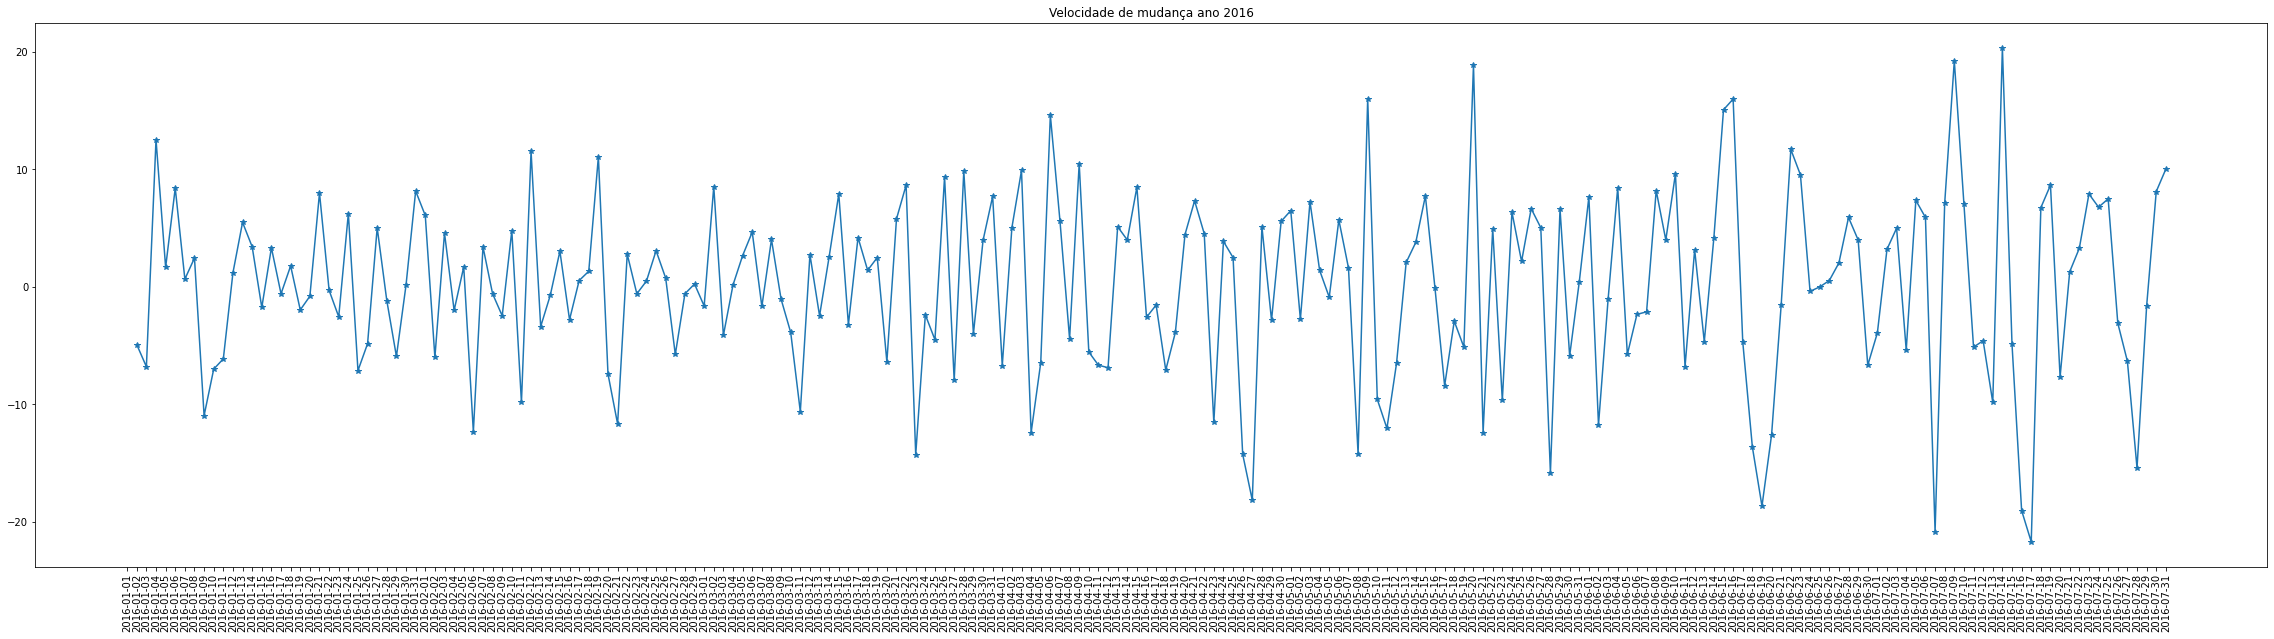

In [21]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2016')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2016.values],rotation=90)
plt.plot(dados_medios_completados_2016.diff(),'*-')
plt.show()

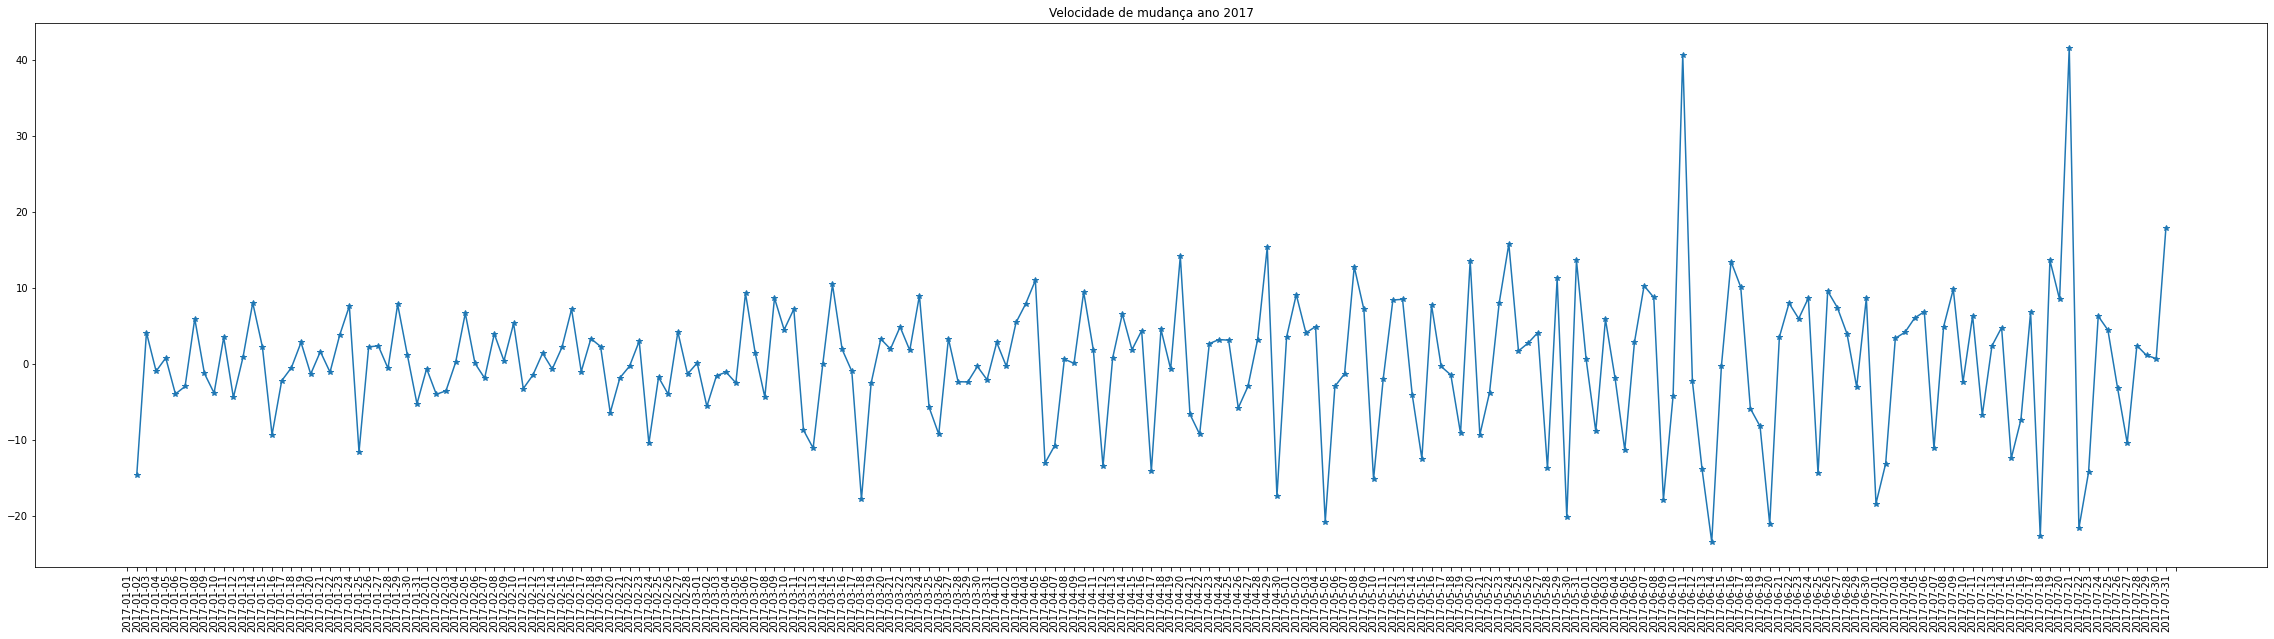

In [22]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2017')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2017.values],rotation=90)
plt.plot(dados_medios_completados_2017.diff(),'*-');
plt.show()

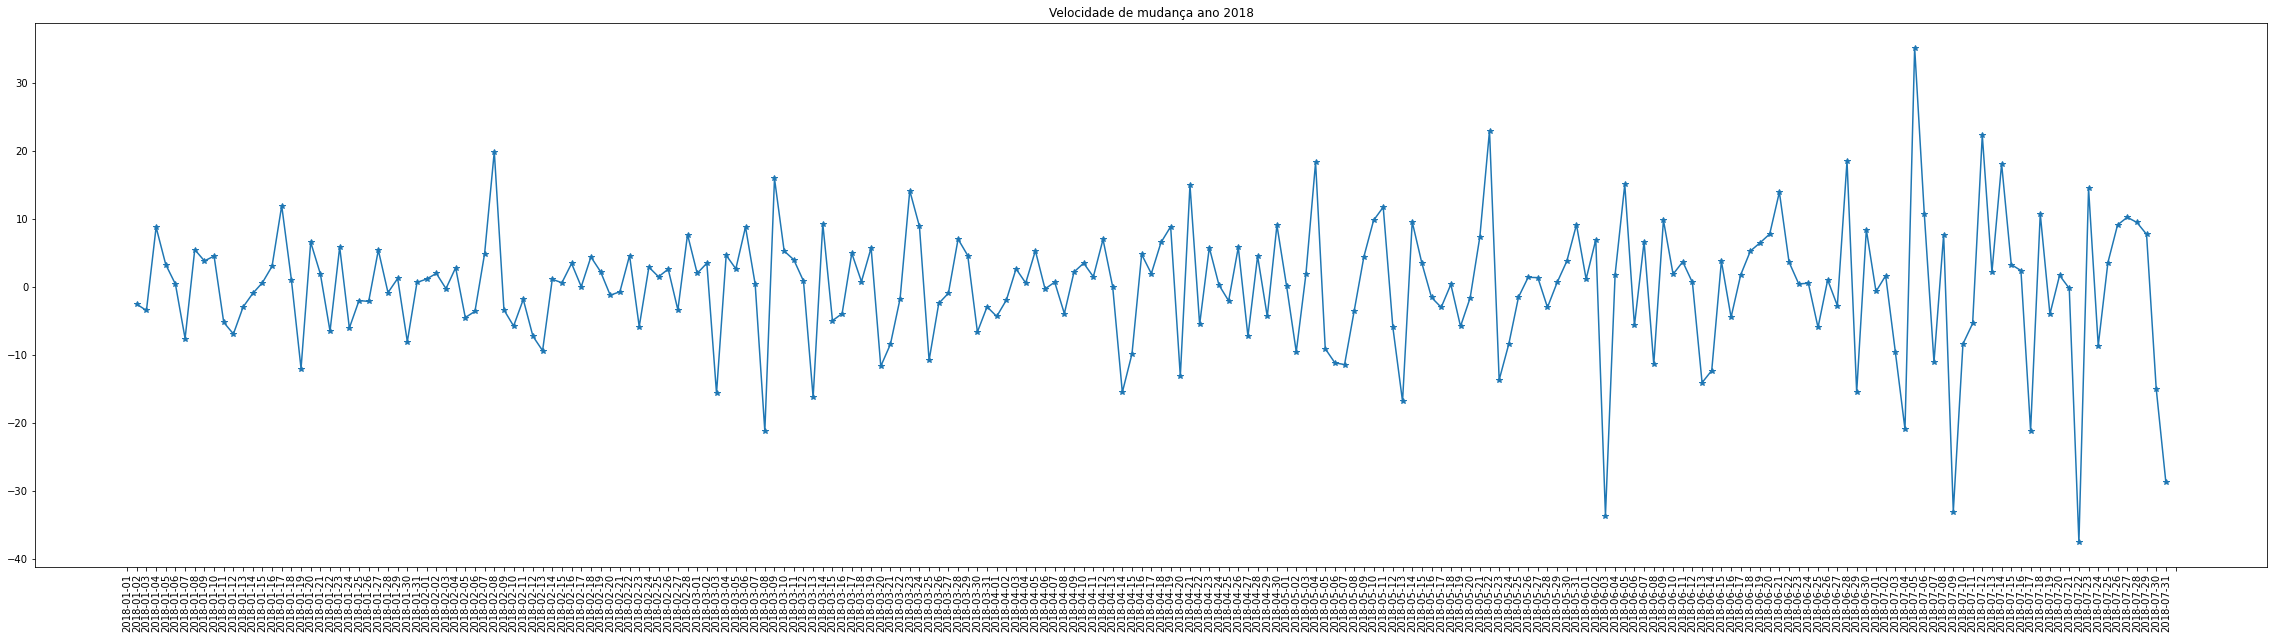

In [23]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2018')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2018.values],rotation=90)
plt.plot(dados_medios_completados_2018.diff(),'*-');
plt.show()

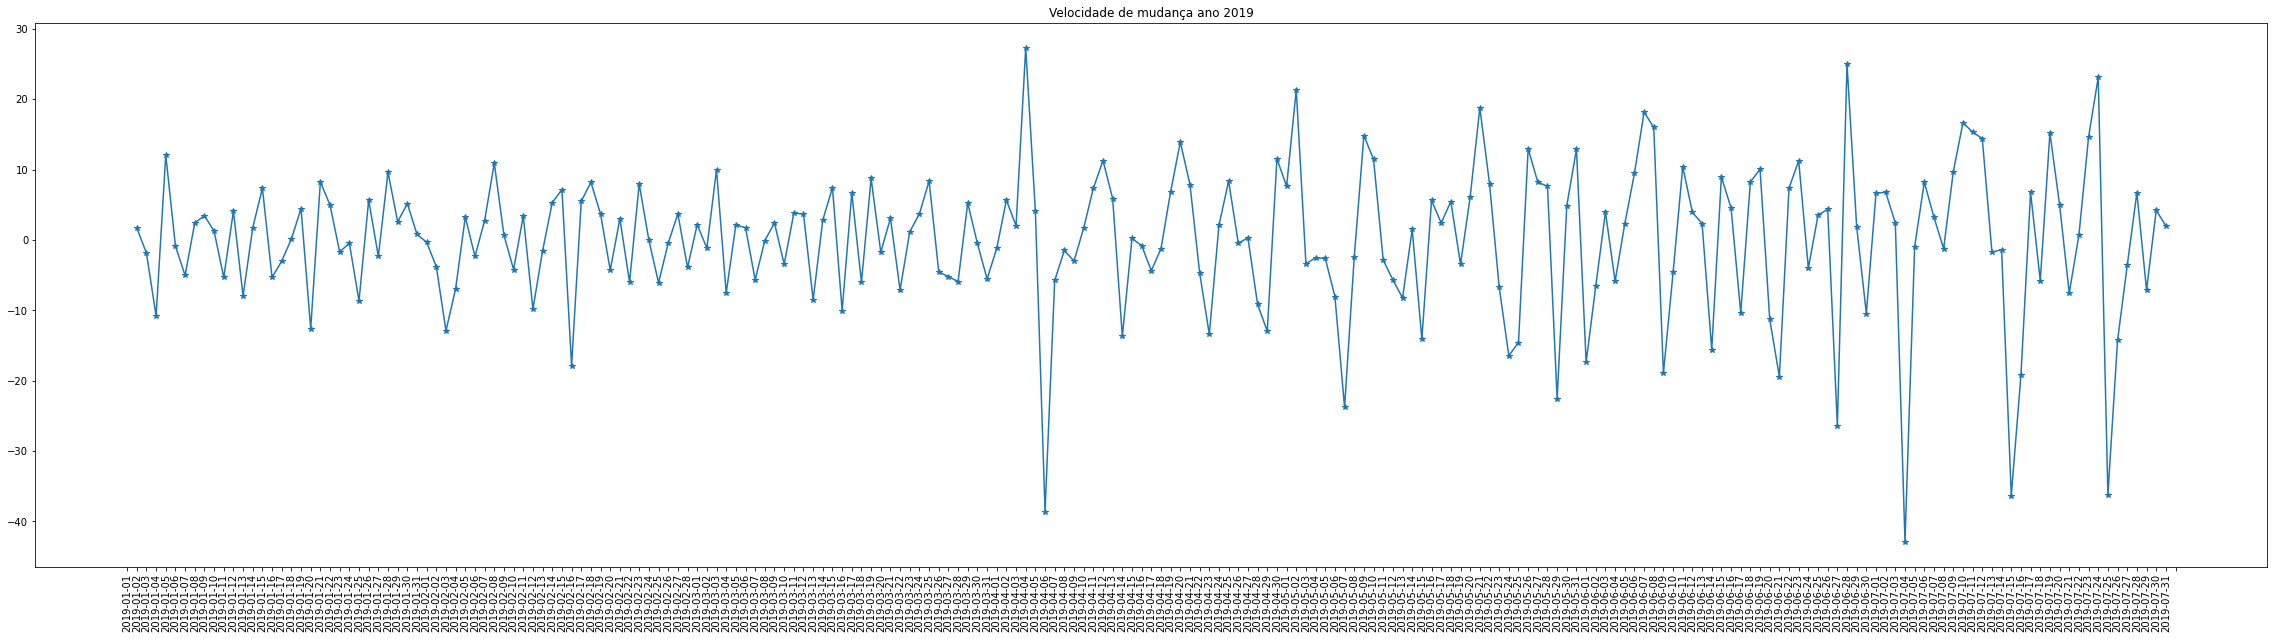

In [24]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2019')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2019.values],rotation=90)
plt.plot(dados_medios_completados_2019.diff(),'*-');
plt.show()

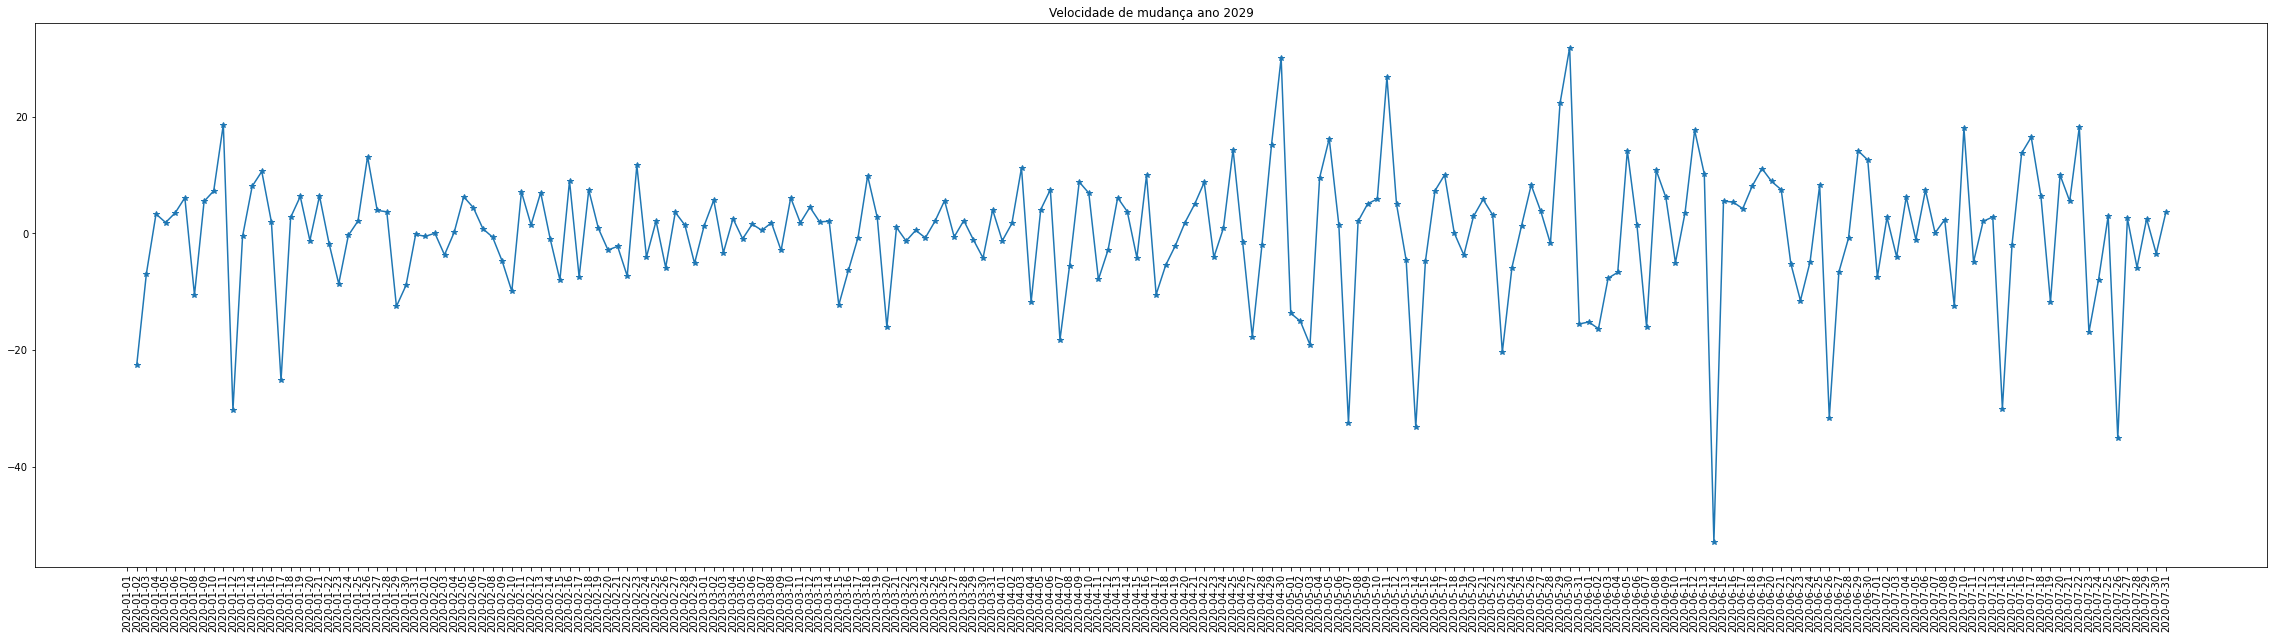

In [25]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2029')
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2020.values],rotation=90)
plt.plot(dados_medios_completados_2020.diff(),'*-');
plt.show()

# Etapa 6: Verificando variação nos dados - aceleração de mudança

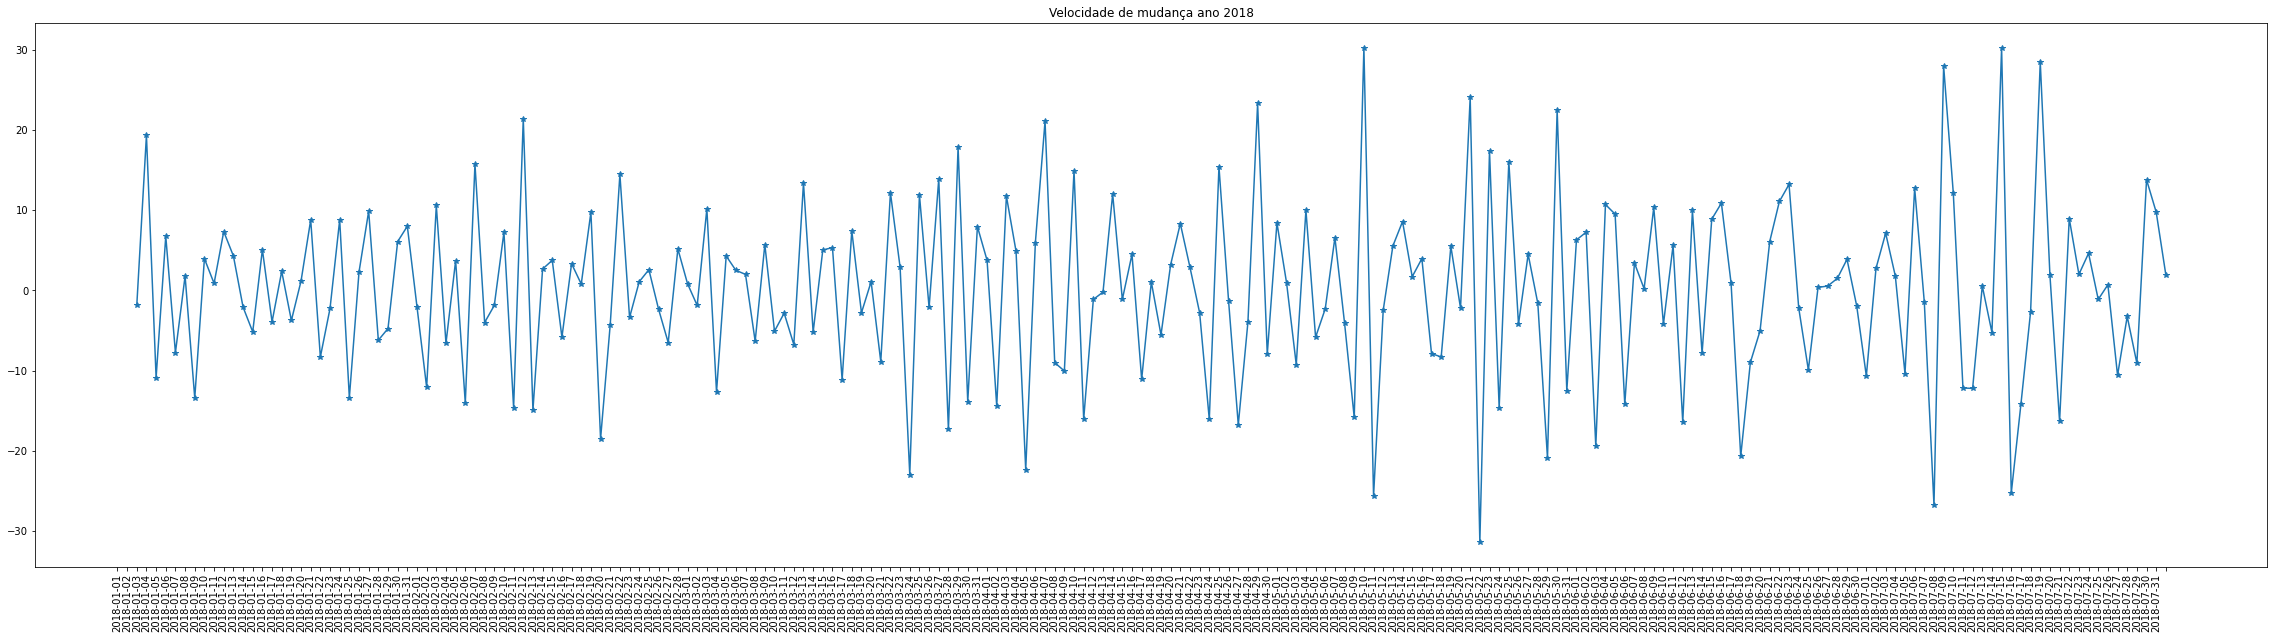

In [26]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2018')
velocidade_2016 = dados_medios_completados_2016.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2018.values],rotation=90)
plt.plot(velocidade_2016.diff(),'*-');
plt.show()

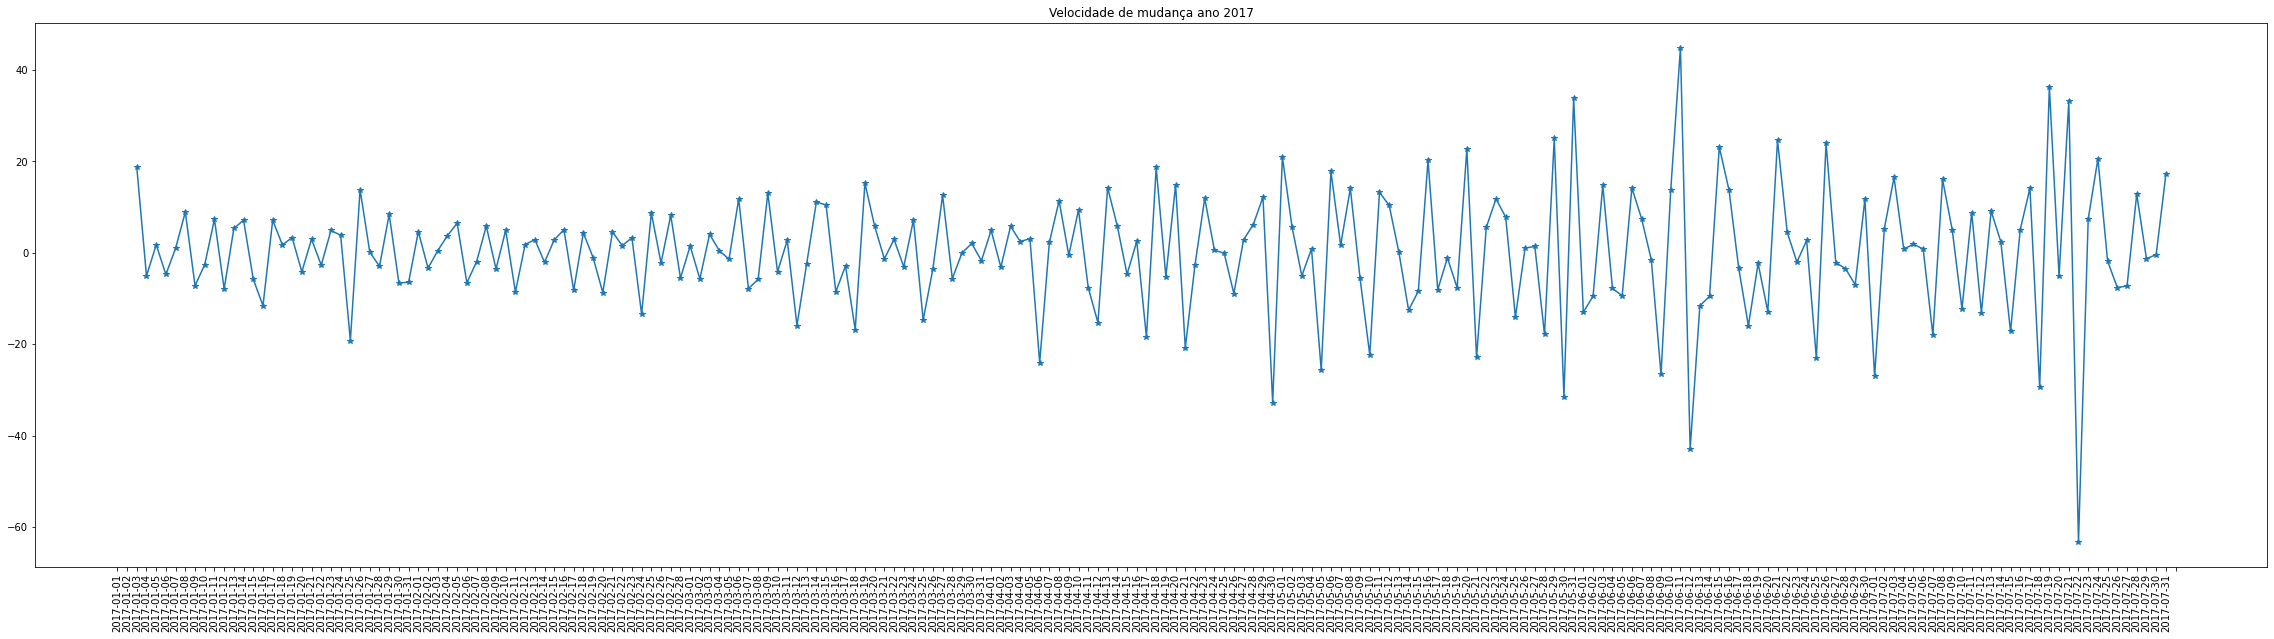

In [27]:
plt.figure(figsize=(40,10))
plt.title('Velocidade de mudança ano 2017')
velocidade_2017 = dados_medios_completados_2017.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2017.values],rotation=90)
plt.plot(velocidade_2017.diff(),'*-')
plt.show()

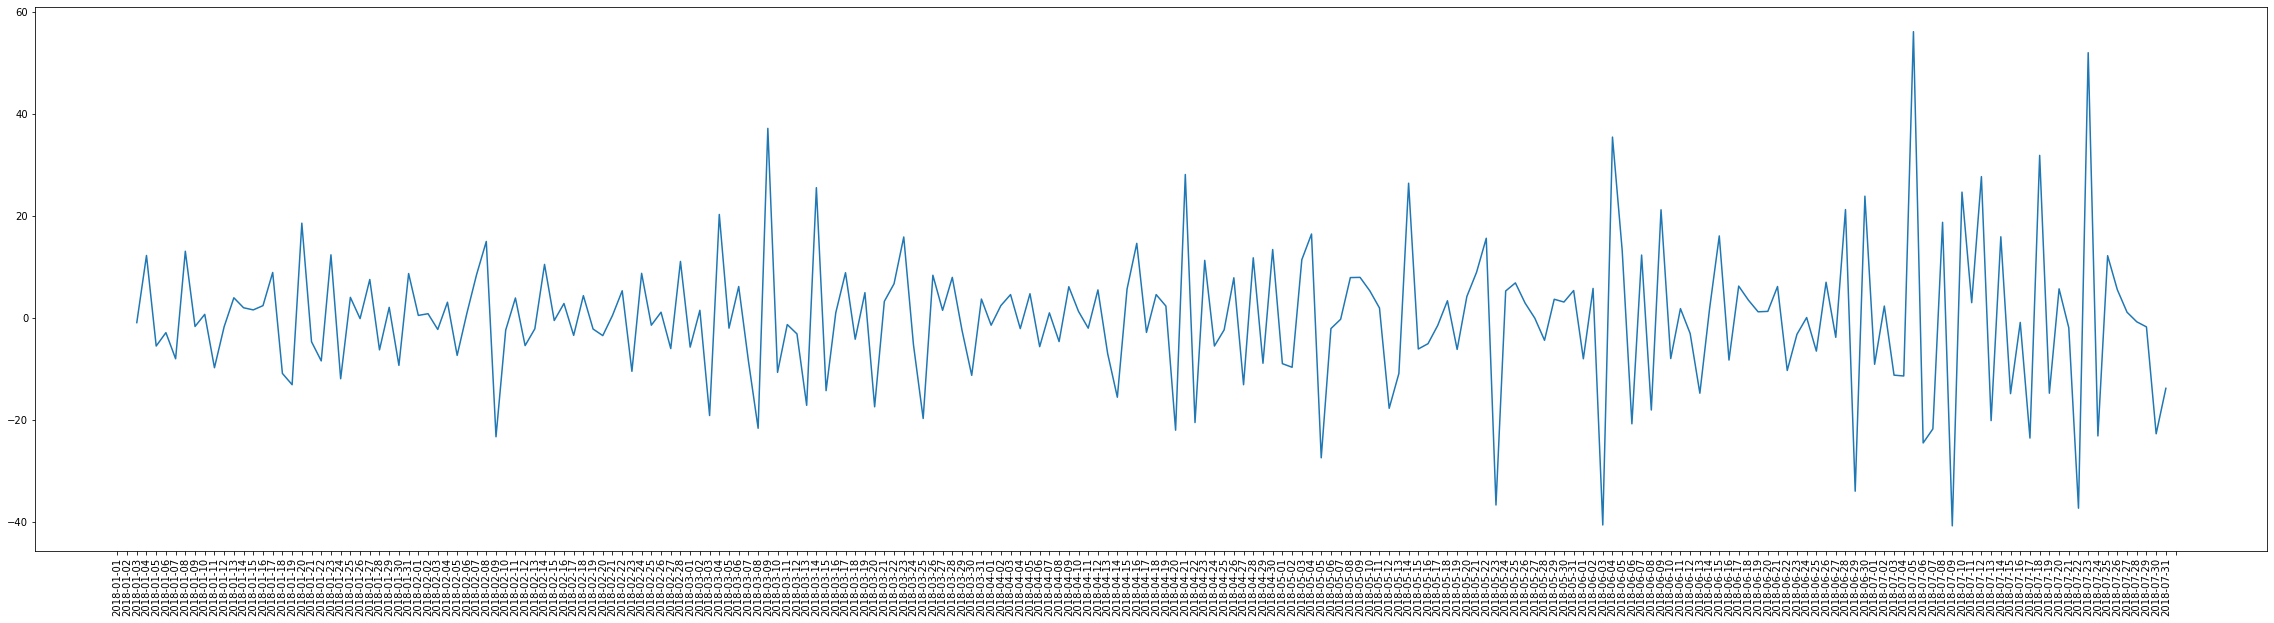

In [28]:
plt.figure(figsize=(40,10))
velocidade_2018 = dados_medios_completados_2018.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2018.values],rotation=90)
plt.plot(velocidade_2018.diff());
plt.show()

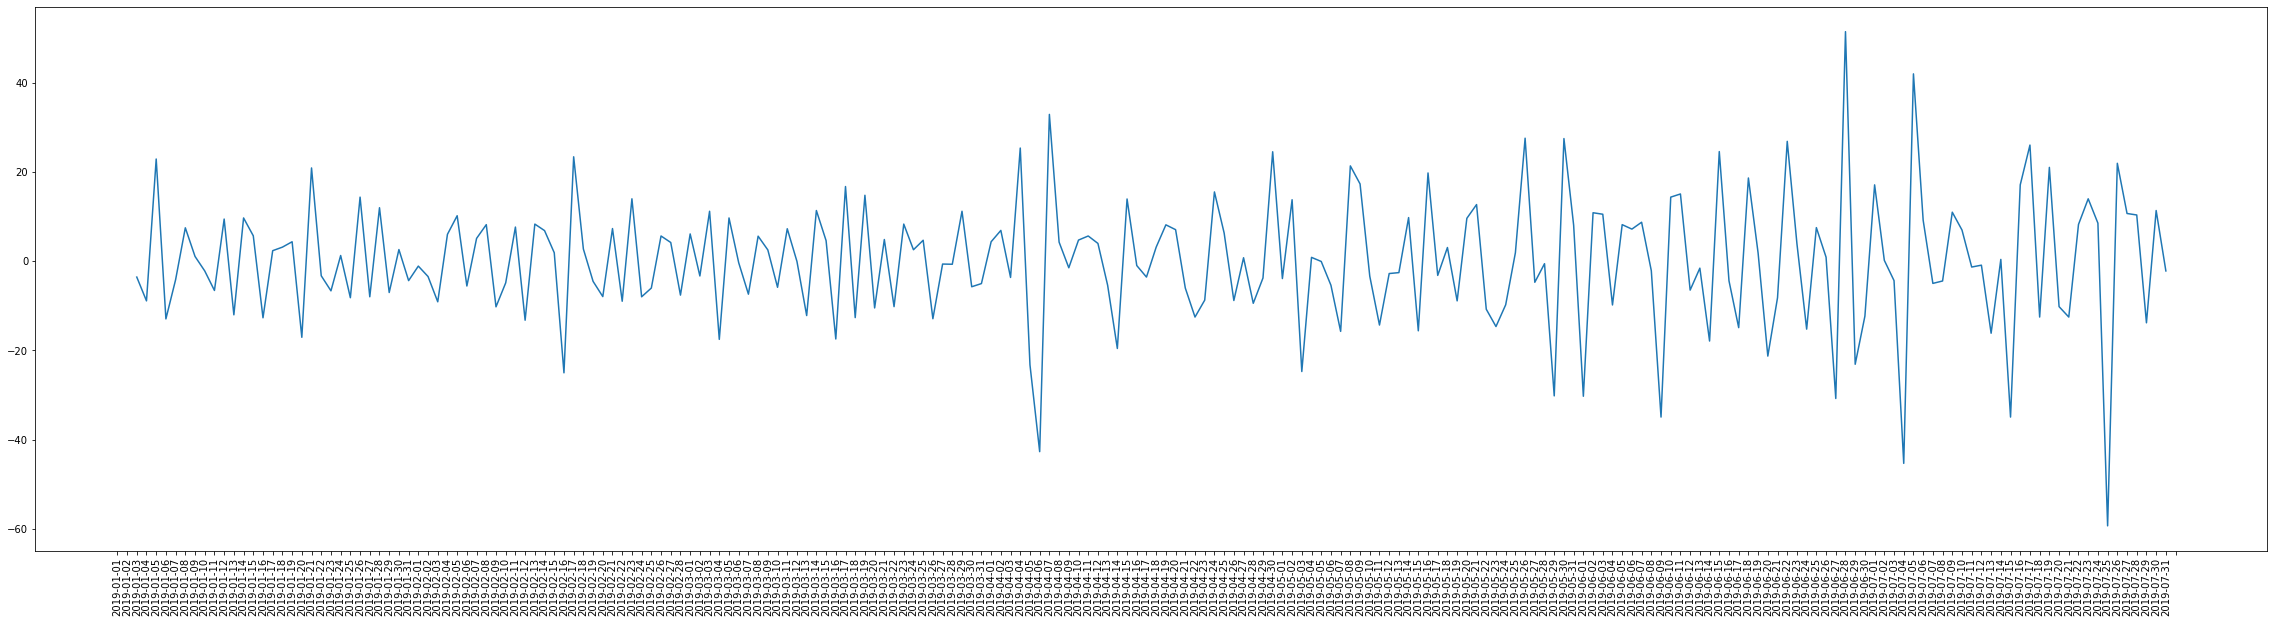

In [29]:
plt.figure(figsize=(40,10))
velocidade_2019 = dados_medios_completados_2019.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2019.values],rotation=90)
plt.plot(velocidade_2019.diff());
plt.show()

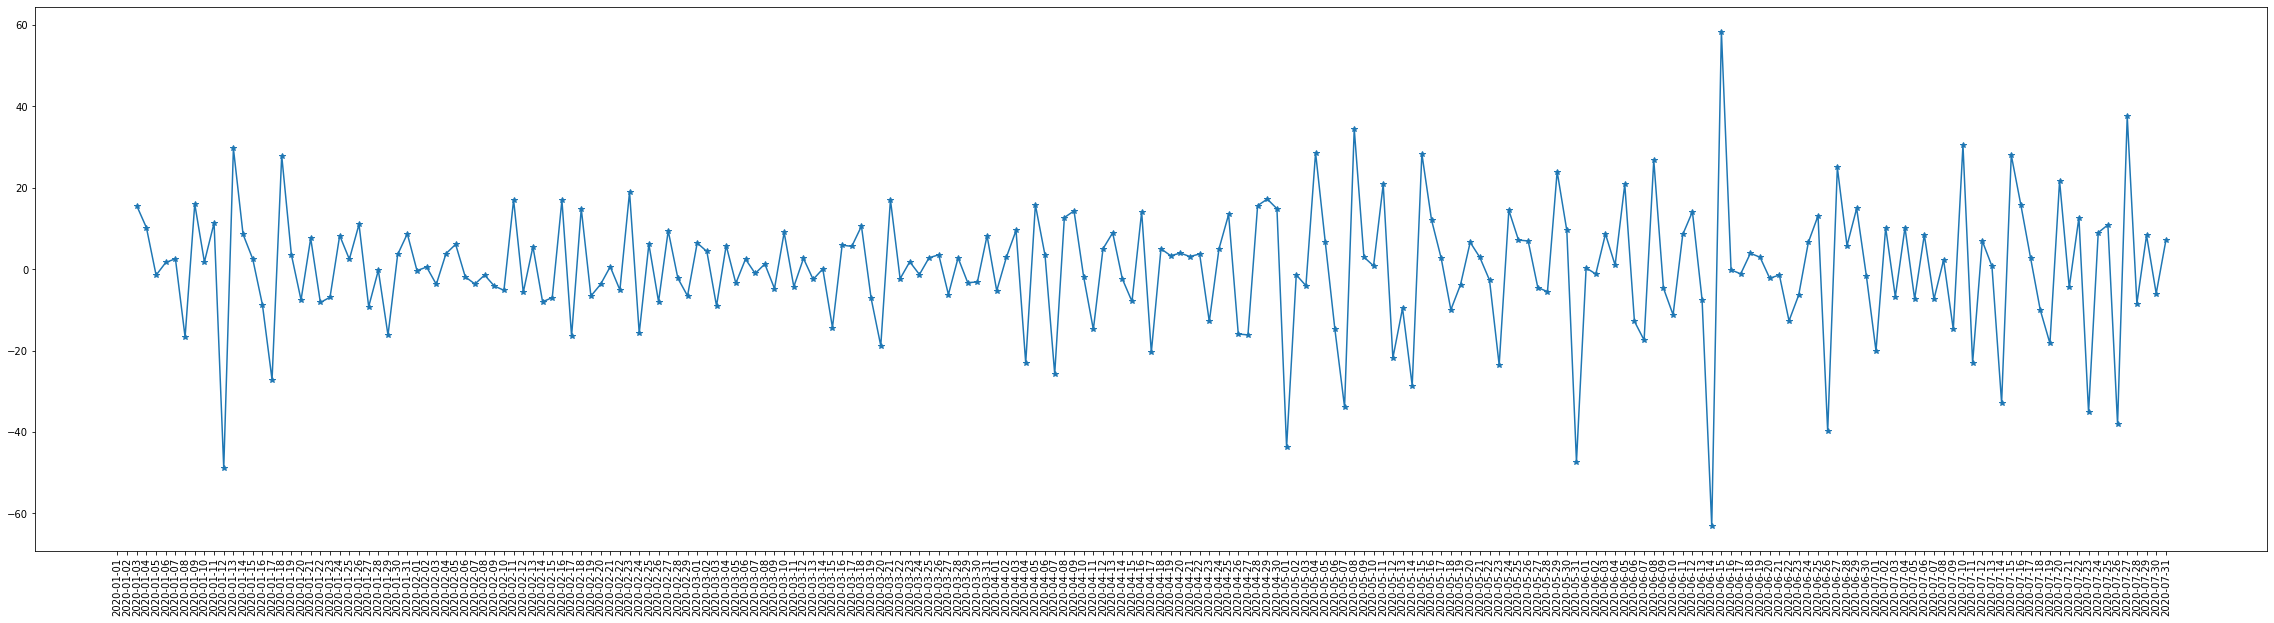

In [30]:
plt.figure(figsize=(40,10))
velocidade_2020 = dados_medios_completados_2020.diff()
plt.xticks([i for i in range(213)],[i[0] for i in eixo_2020.values],rotation=90)
plt.plot(velocidade_2020.diff(),'*-')
plt.show()

# Etapa 7: Autocorrelação da série

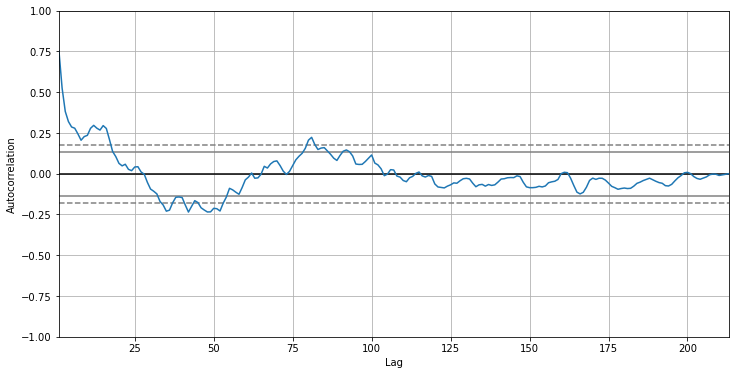

In [31]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2016);

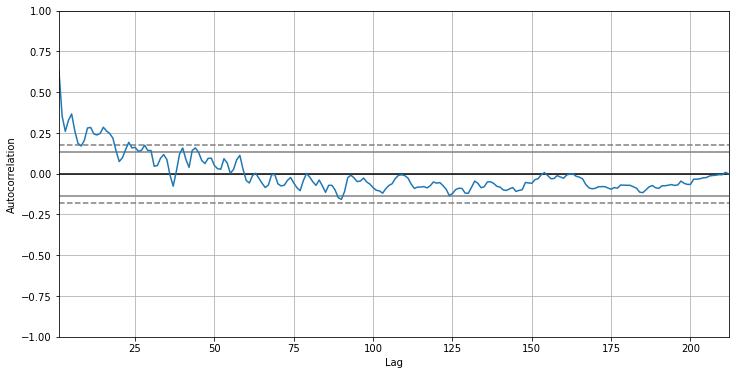

In [32]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2017)

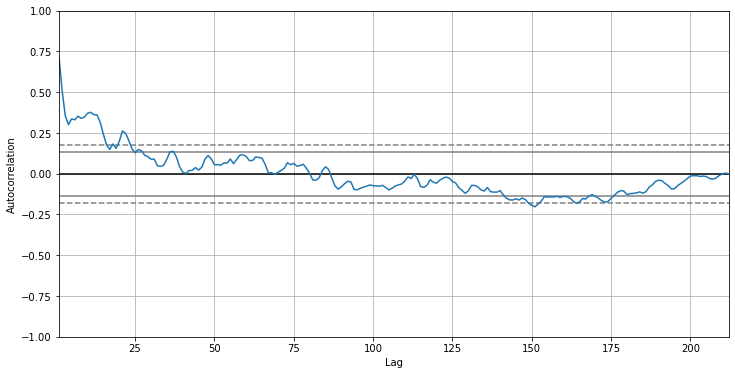

In [33]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2018)

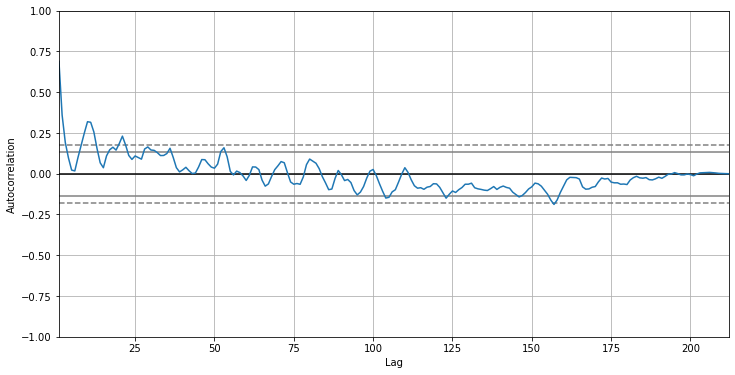

In [34]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2019)

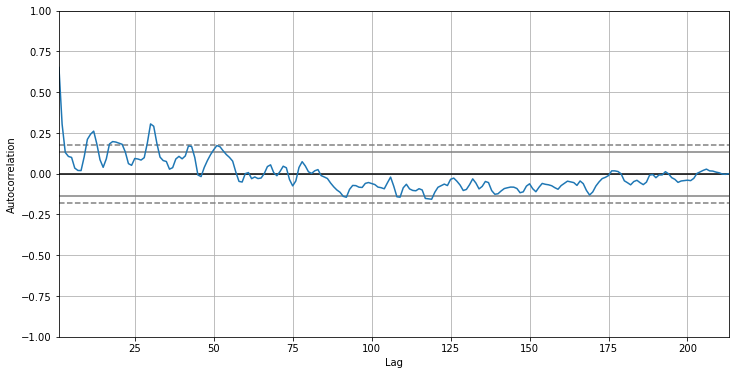

In [35]:
plt.figure(figsize=(12,6))
autocorrelation_plot(dados_medios_completados_2020)

# Parte 2: Juntando os dados

In [36]:
serie_completa = dados_medios_completados_2017
serie_completa = serie_completa.append(dados_medios_completados_2018)
serie_completa = serie_completa.append(dados_medios_completados_2019)
serie_completa = serie_completa.append(dados_medios_completados_2020)
serie_completa.reset_index(drop=True,inplace=True)
serie_completa

0      28.625000
1      14.041667
2      18.166667
3      17.208333
4      18.000000
         ...    
844    15.583333
845     9.750000
846    12.250000
847     8.791667
848    12.416667
Length: 849, dtype: float64

# Etapa 3: Decompondo a série

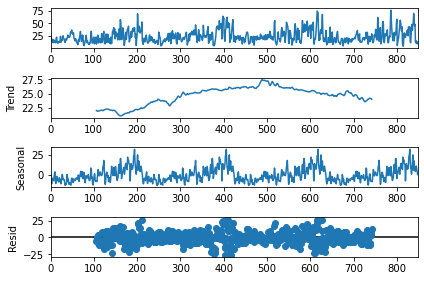

In [37]:
resultado = seasonal_decompose(serie_completa,period=212)
resultado.plot();

# Etapa 4: Teste de estacionariedade

Resultados do teste Dickey Fuller:
Teste estatístico                -5.093196
p-value                           0.000014
#Lags Usados                      9.000000
Número de observações usadas    839.000000
Valores críticos (1%)            -3.438168
Valores críticos (5%)            -2.864991
Valores críticos (10%)           -2.568608
dtype: float64


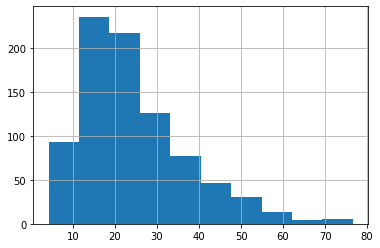

In [38]:
p_value = teste_estacionariedade(serie_completa)
serie_completa.hist()

# Etapa 5: Autocorrelação para verificar a periodicidade e sazonalidade da série

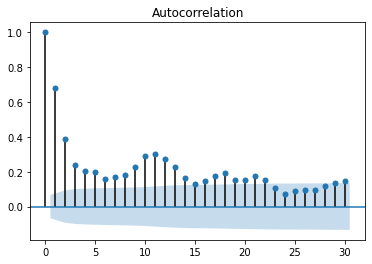

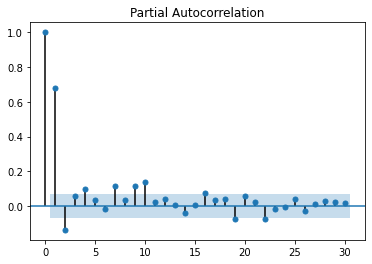

In [39]:
plot_acf(serie_completa);
plot_pacf(serie_completa);

# Etapa 6: Verificando variação nos dados - velocidade de mudança

In [40]:
eixo_2016_2019 = pd.concat([eixo_2016,eixo_2017,eixo_2018,eixo_2019])
eixo_2016_2019.reset_index(drop=True,inplace=True)
eixo_2017_2020 = pd.concat([eixo_2017,eixo_2018,eixo_2019,eixo_2020])
eixo_2017_2020.reset_index(drop=True,inplace=True)

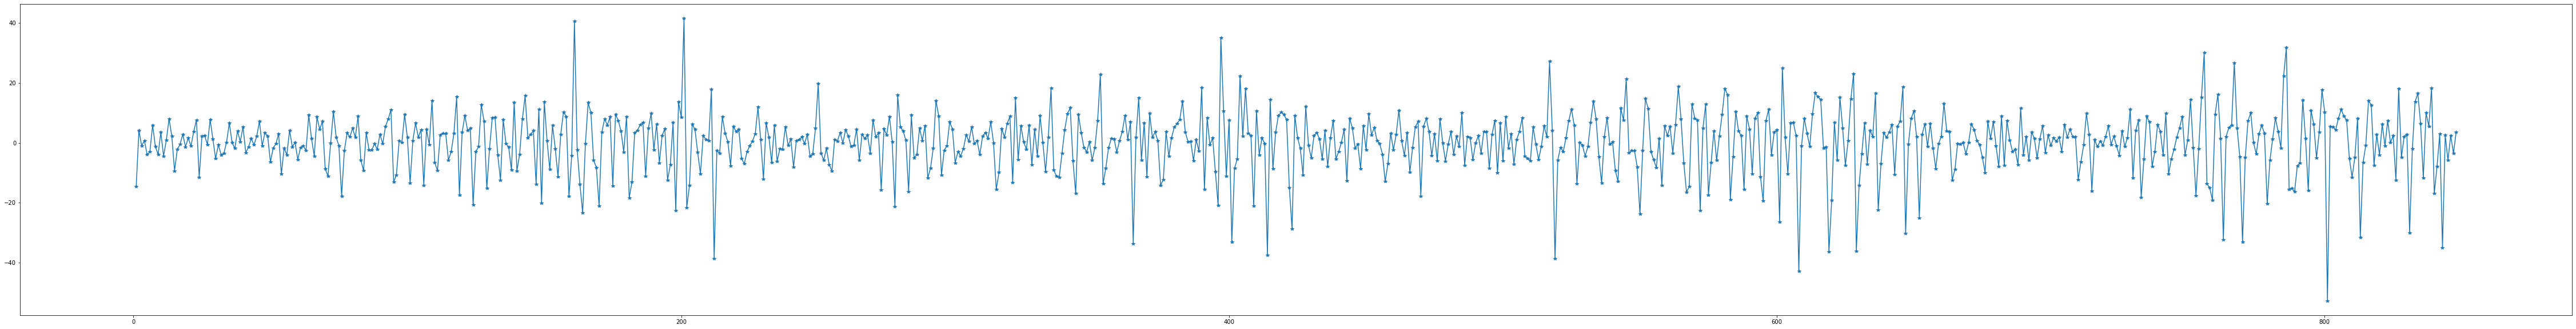

In [41]:
plt.figure(figsize=(80,10))
plt.plot(serie_completa.diff(),'*-');


# Etapa 7: Verificando variação nos dados - aceleração de mudança

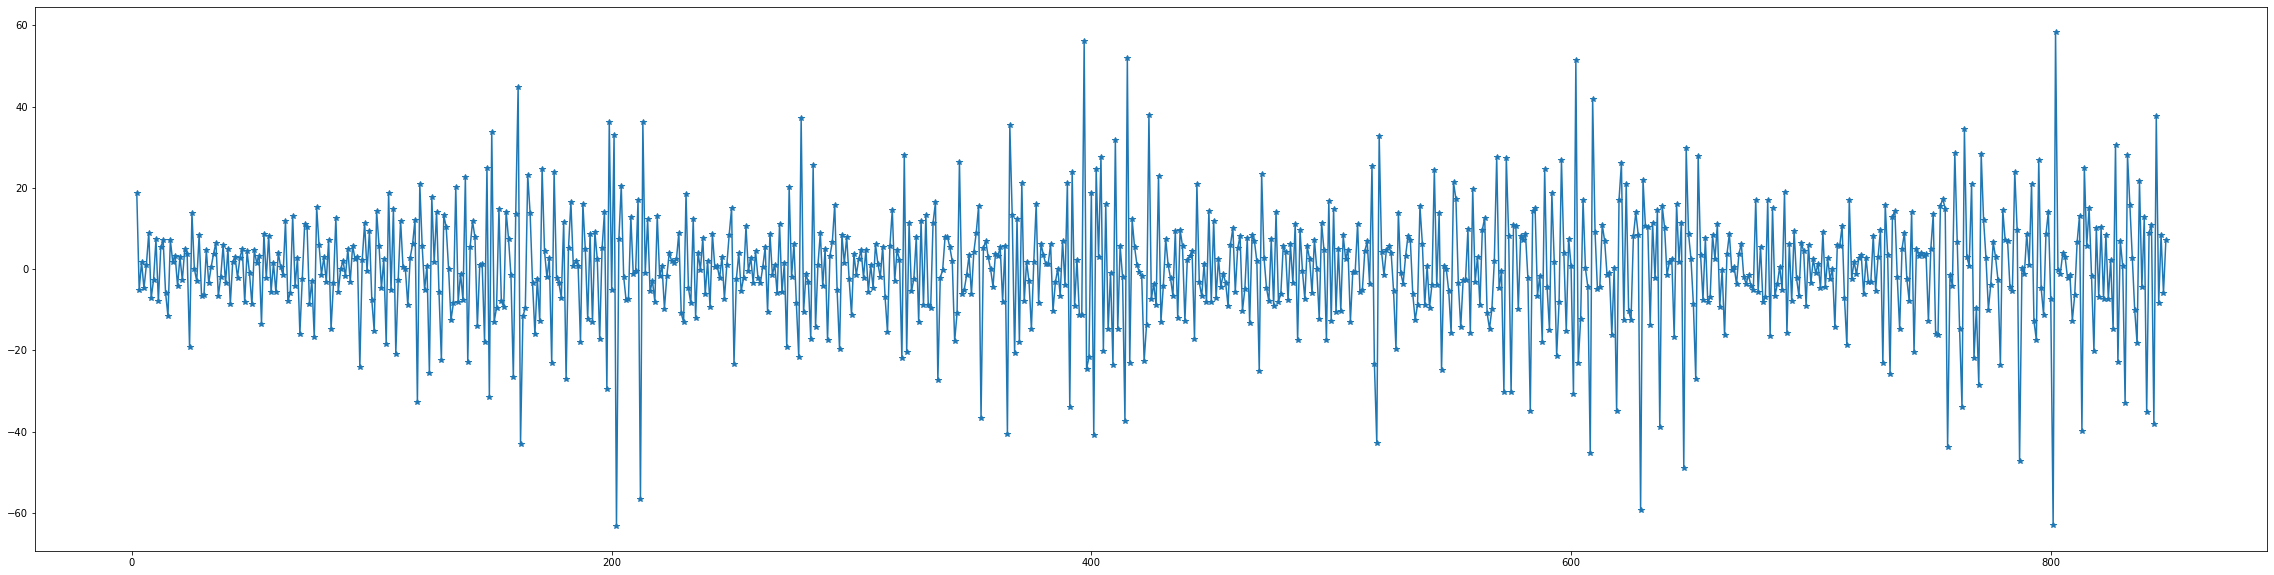

In [42]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa.diff().diff(),'*-')

# Etapa 7: Autocorrelação da série

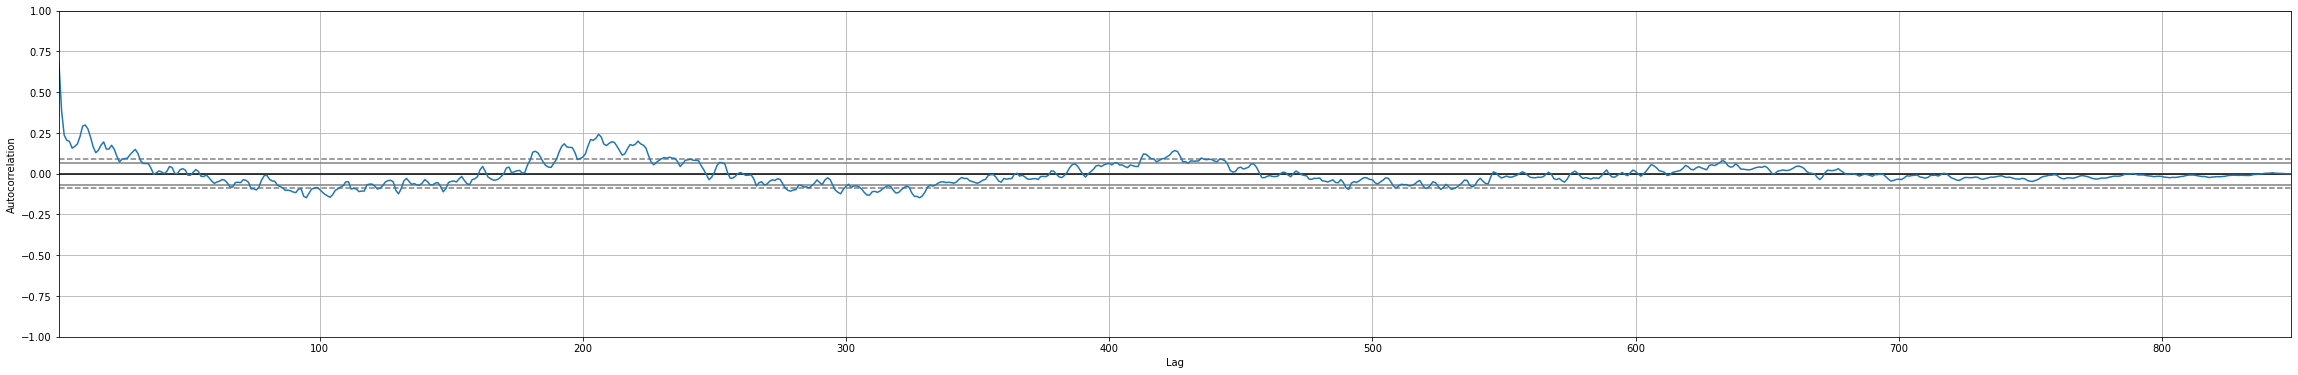

In [43]:
plt.figure(figsize=(40,6))
autocorrelation_plot(serie_completa)

# Comparação com os dados de 2016

In [44]:
serie_completa_com_2016 = dados_medios_completados_2016
serie_completa_com_2016 = serie_completa_com_2016.append(dados_medios_completados_2018)
serie_completa_com_2016 = serie_completa_com_2016.append(dados_medios_completados_2019)
serie_completa_com_2016 = serie_completa_com_2016.append(dados_medios_completados_2020)
serie_completa_com_2016.reset_index(drop=True,inplace=True)
serie_completa_com_2016

0      17.416667
1      12.500000
2       5.708333
3      18.250000
4      19.916667
         ...    
845    15.583333
846     9.750000
847    12.250000
848     8.791667
849    12.416667
Length: 850, dtype: float64

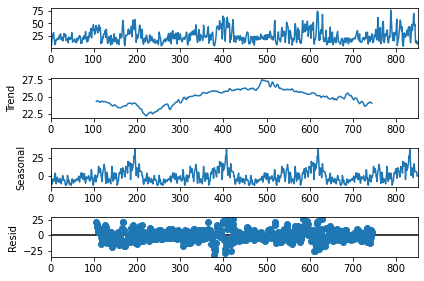

In [45]:
resultado = seasonal_decompose(serie_completa_com_2016,period=212)
resultado.plot();

Resultados do teste Dickey Fuller:
Teste estatístico                -4.608262
p-value                           0.000125
#Lags Usados                     11.000000
Número de observações usadas    838.000000
Valores críticos (1%)            -3.438177
Valores críticos (5%)            -2.864995
Valores críticos (10%)           -2.568610
dtype: float64


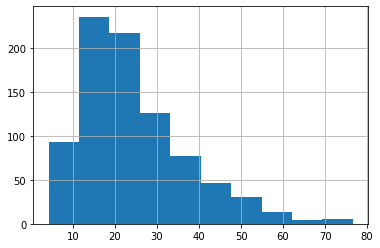

In [46]:
p_value = teste_estacionariedade(serie_completa_com_2016)
serie_completa.hist()

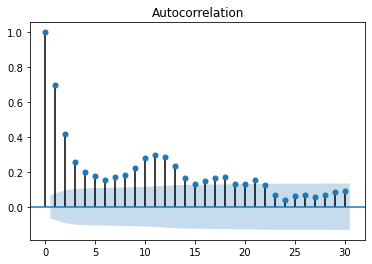

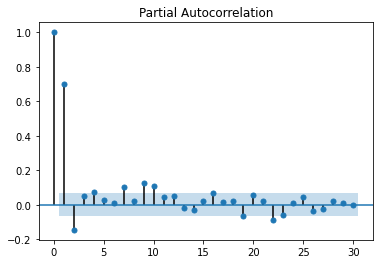

In [47]:
plot_acf(serie_completa_com_2016);
plot_pacf(serie_completa_com_2016);

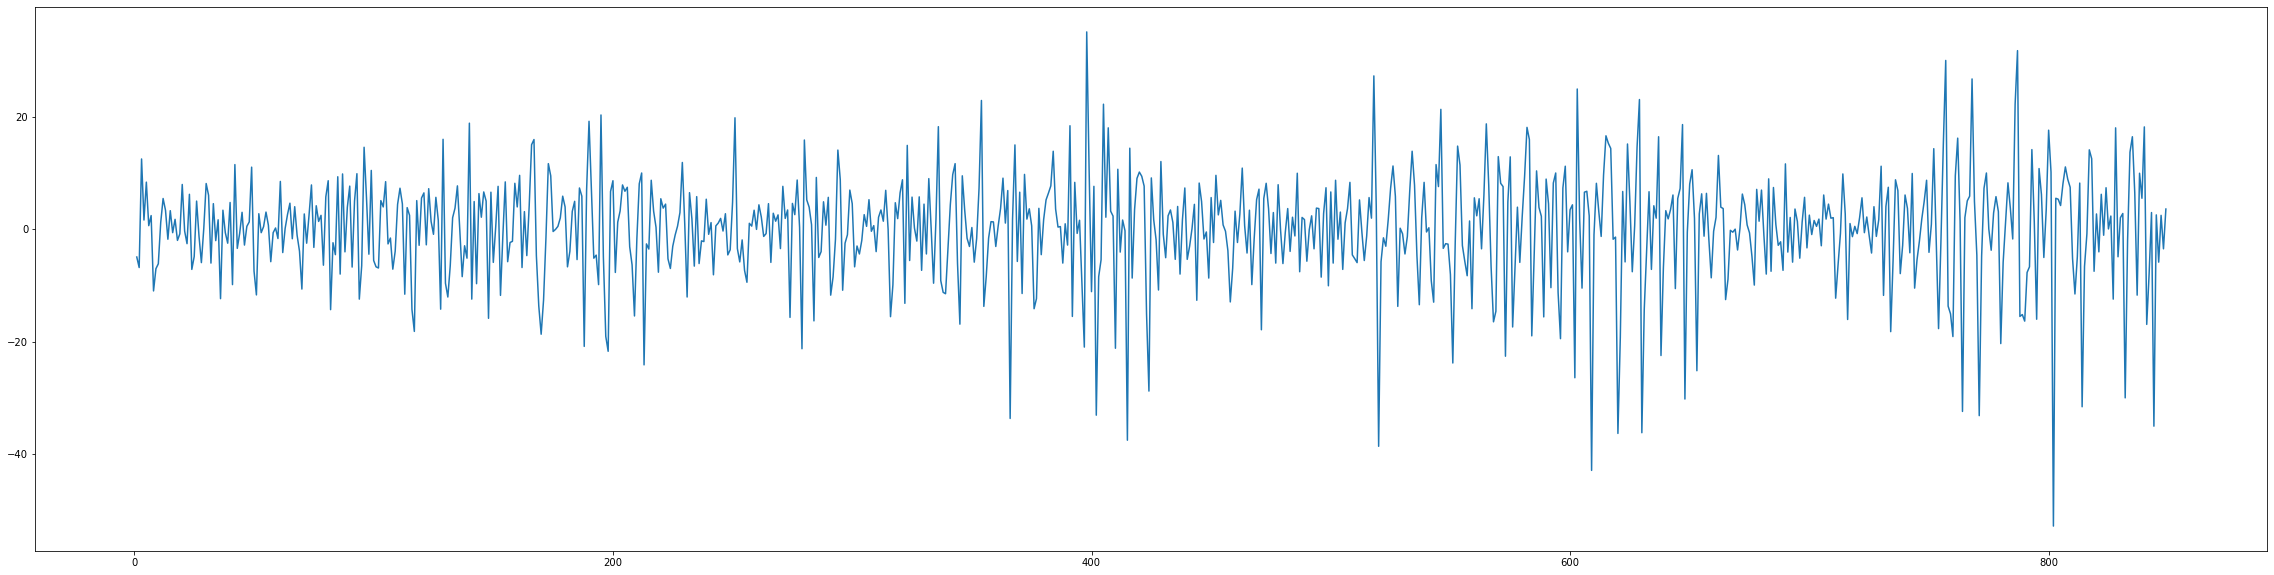

In [48]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_com_2016.diff()) 

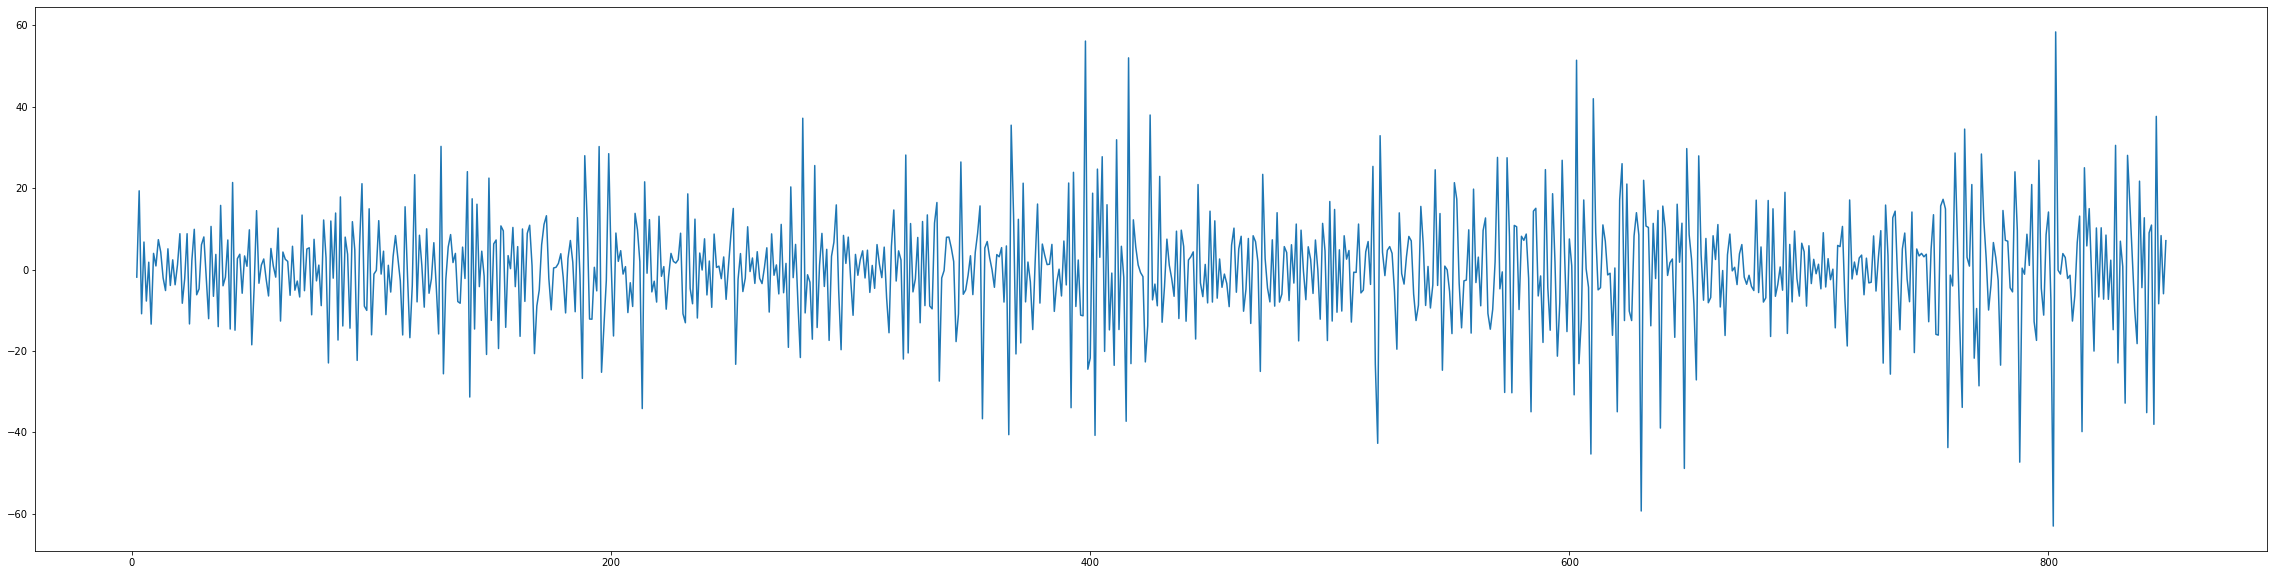

In [49]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_com_2016.diff().diff())

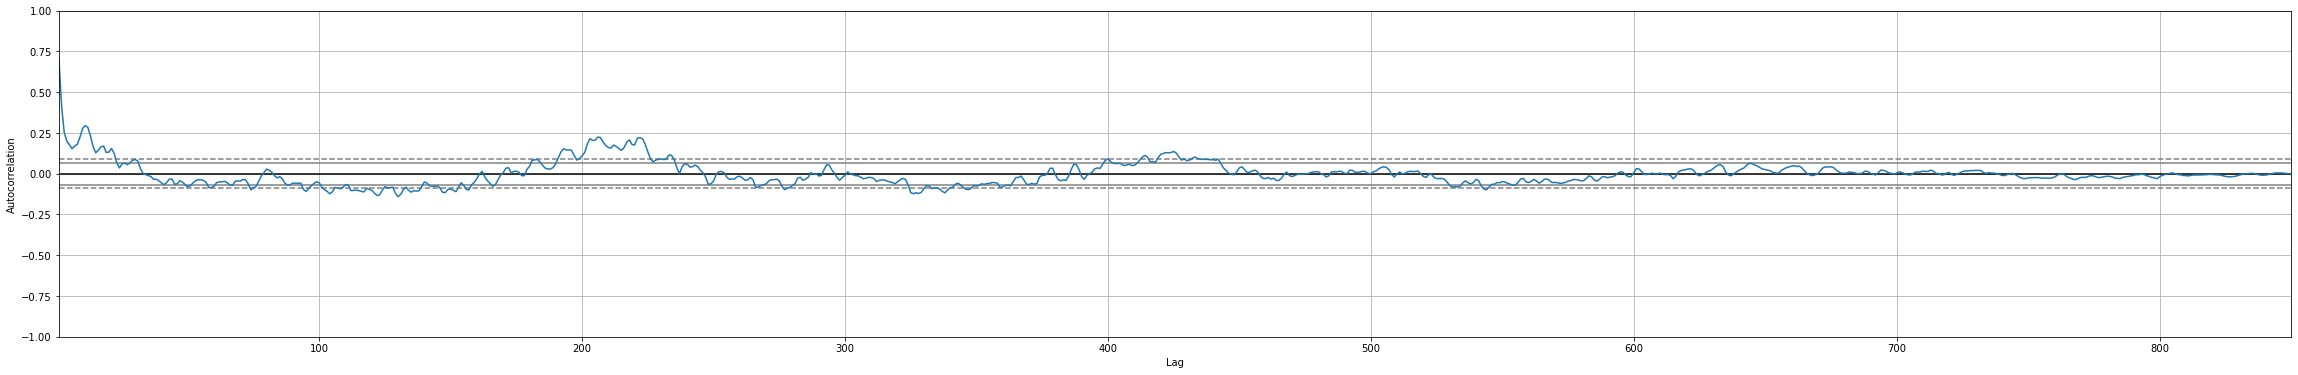

In [50]:
plt.figure(figsize=(40,6))
autocorrelation_plot(serie_completa_com_2016)

# Tratamento com dados suavizados

MAPE:30.884539674988968
MAE:5.679625199362043
MQE:55.17383672248804


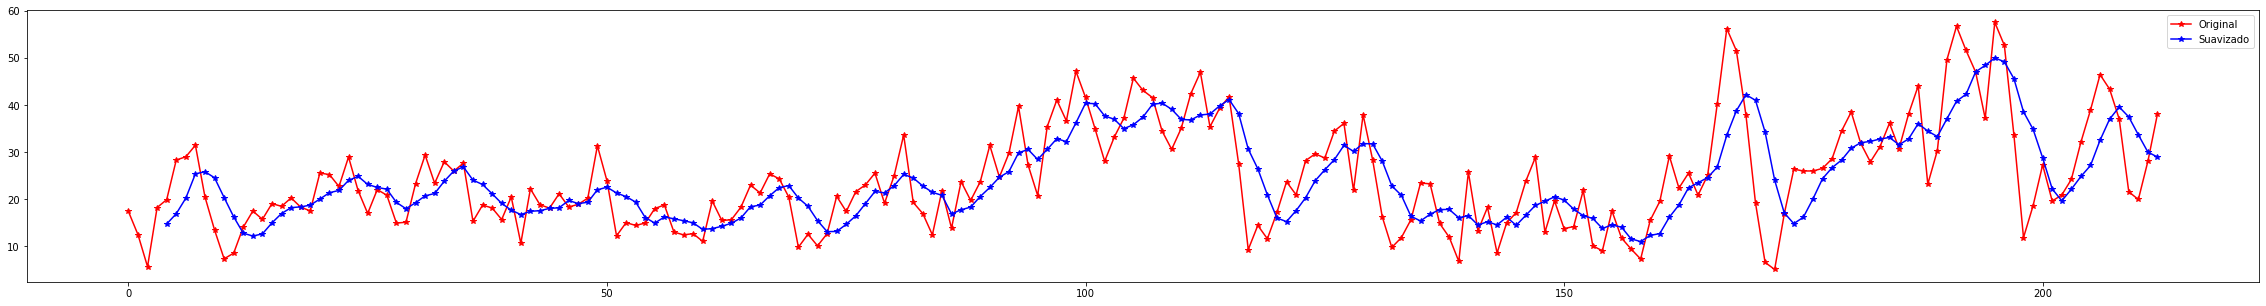

In [51]:
st_2016_suavizado = alisar_serie(dados_medios_completados_2016,p_v_2016)

MAPE:105.5
MAE:105.5
MQE:105.5


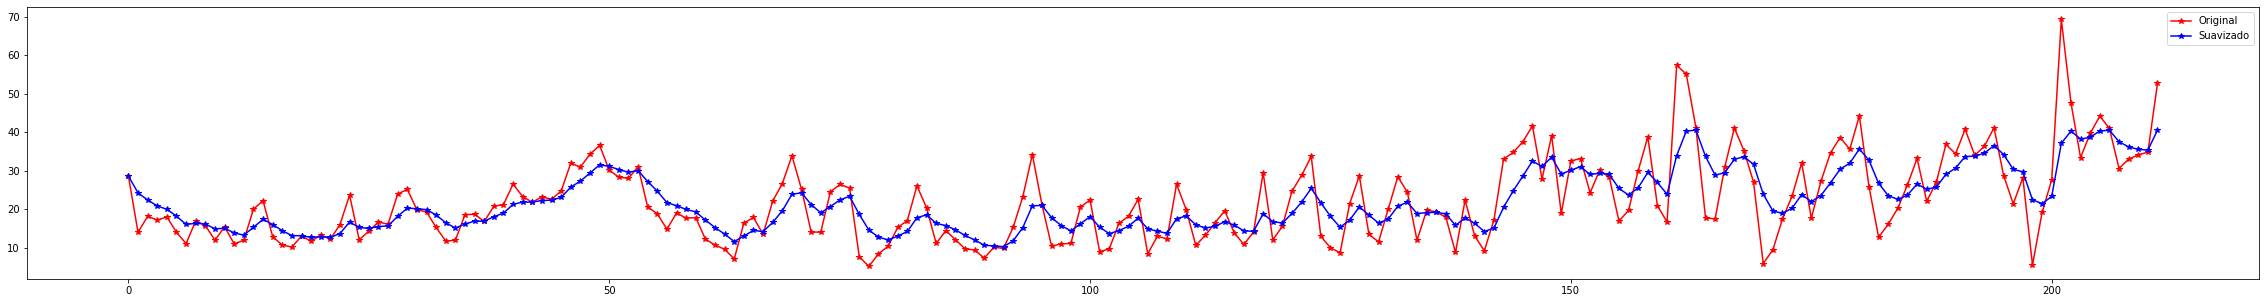

In [52]:
st_2017_suavizado = alisar_serie(dados_medios_completados_2017,p_v_2017)

MAPE:34.99862291324576
MAE:6.482572115384611
MQE:76.0421551148504


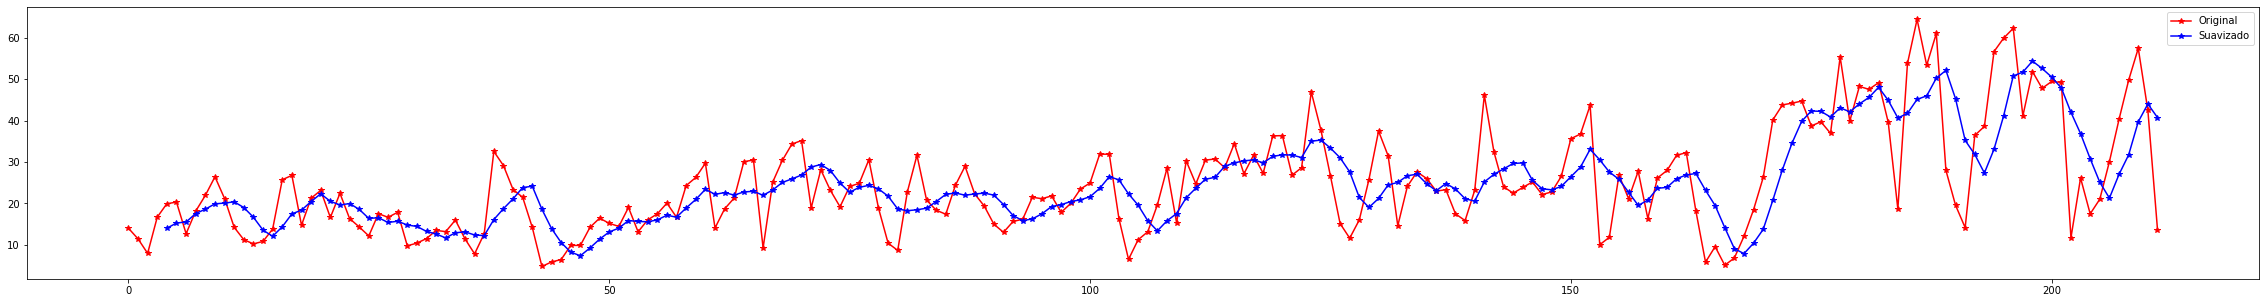

In [53]:
st_2018_suavizado = alisar_serie(dados_medios_completados_2018,p_v_2018)

MAPE:34.99862291324576
MAE:6.482572115384611
MQE:76.0421551148504


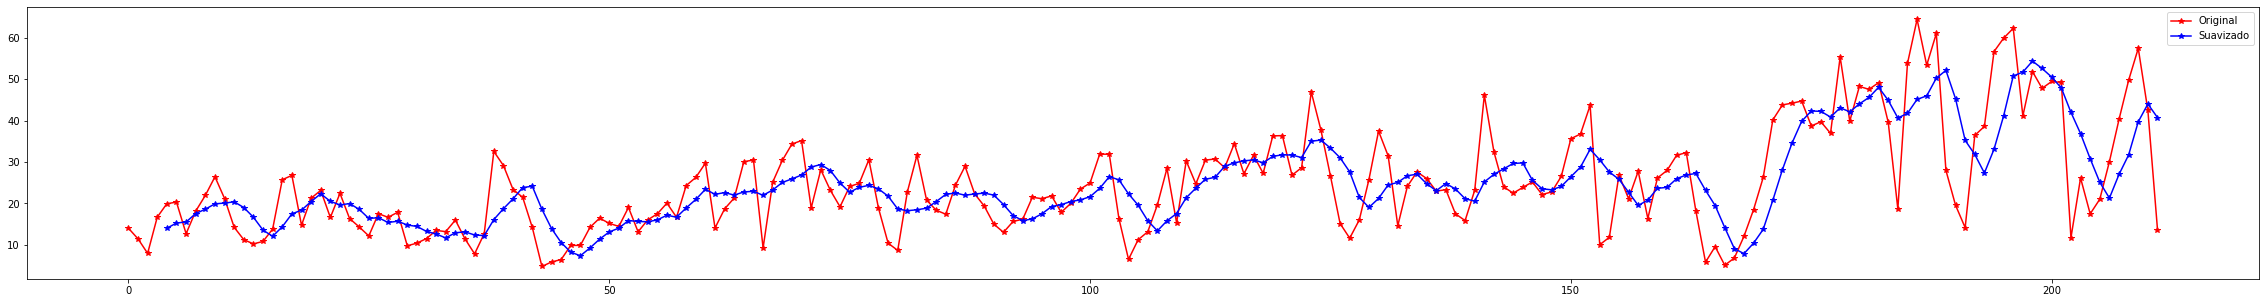

In [54]:
st_2019_suavizado = alisar_serie(dados_medios_completados_2018,p_v_2019)

MAPE:44.52071407716475
MAE:7.75163476874003
MQE:109.65665370813396


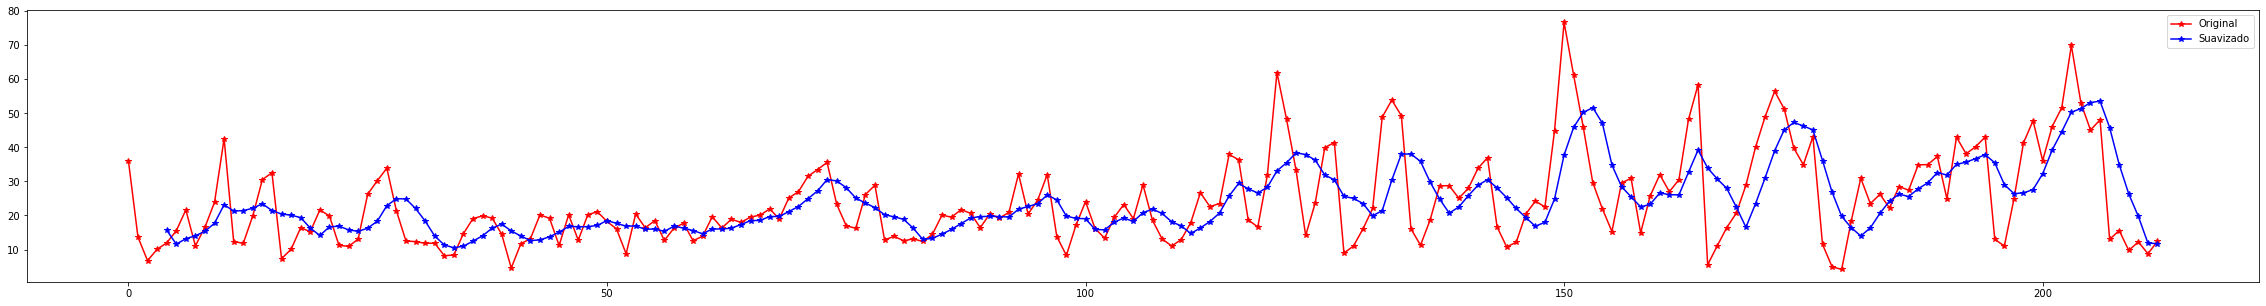

In [55]:
st_2020_suavizado = alisar_serie(dados_medios_completados_2020,p_v_2020)

# Decomposição da série

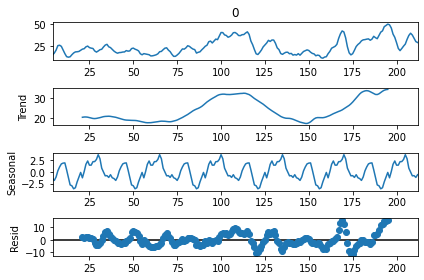

In [56]:
resultado_2016 = seasonal_decompose(st_2016_suavizado,period=35)
resultado_2016.plot();

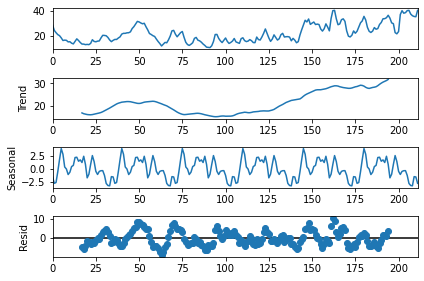

In [57]:
resultado_2017 = seasonal_decompose(st_2017_suavizado,period=35)
resultado_2017.plot();

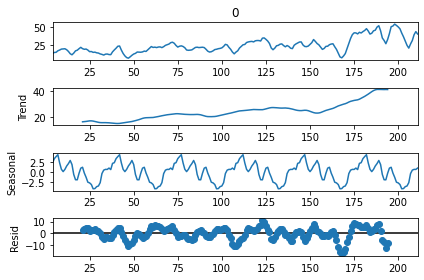

In [58]:
resultado_2018 = seasonal_decompose(st_2018_suavizado,period=35)
resultado_2018.plot();

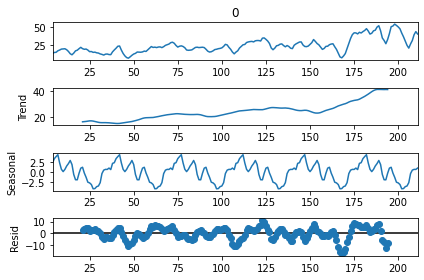

In [59]:
resultado_2019 = seasonal_decompose(st_2019_suavizado,period=35)
resultado_2019.plot();

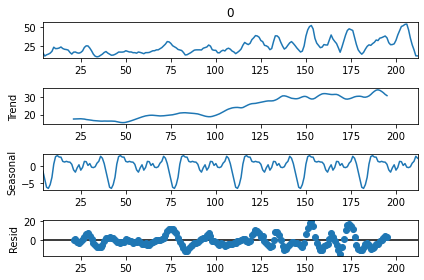

In [60]:
resultado_2020 = seasonal_decompose(st_2020_suavizado,period=35)
resultado_2020.plot();

# Autocorrelação para verificar a periodicidade e sazonalidade da série

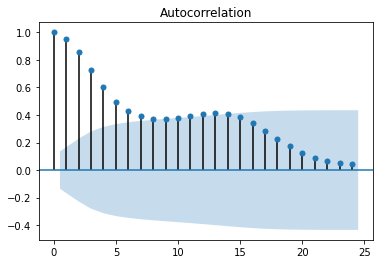

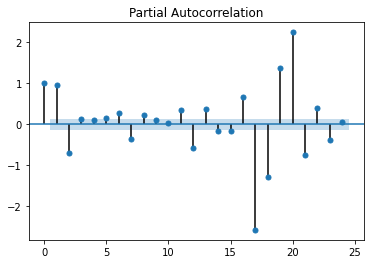

In [61]:
plot_acf(st_2016_suavizado);
plot_pacf(st_2016_suavizado);

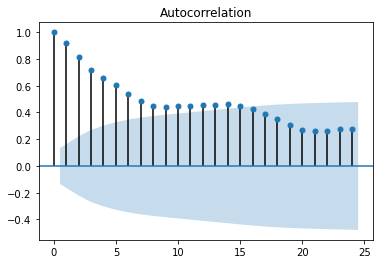

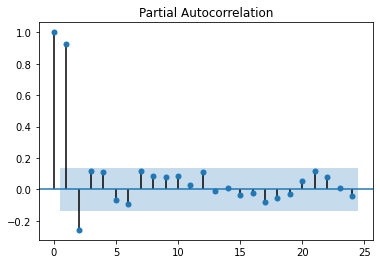

In [62]:
plot_acf(st_2017_suavizado);
plot_pacf(st_2017_suavizado);

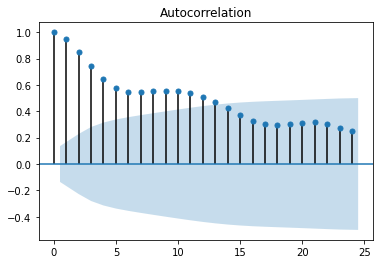

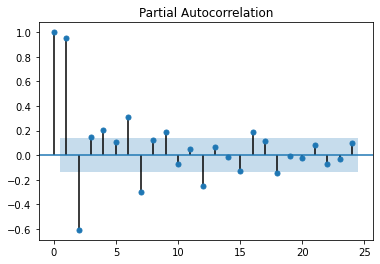

In [63]:
plot_acf(st_2018_suavizado);
plot_pacf(st_2018_suavizado);

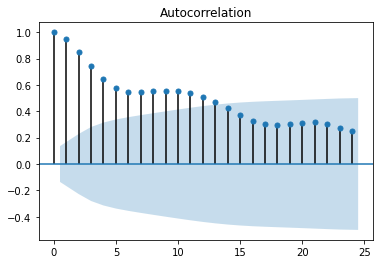

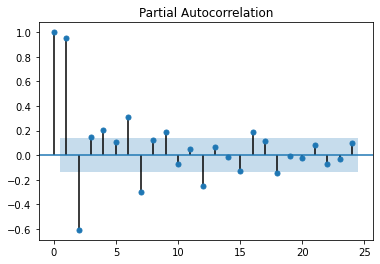

In [64]:
plot_acf(st_2019_suavizado);
plot_pacf(st_2019_suavizado);

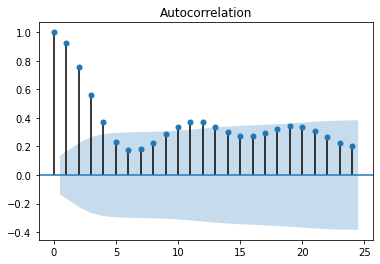

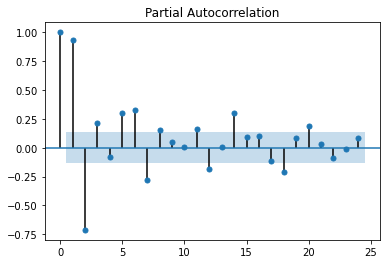

In [65]:
plot_acf(st_2020_suavizado);
plot_pacf(st_2020_suavizado);

# Verificando a variação nos dados - velocidade de mundaça

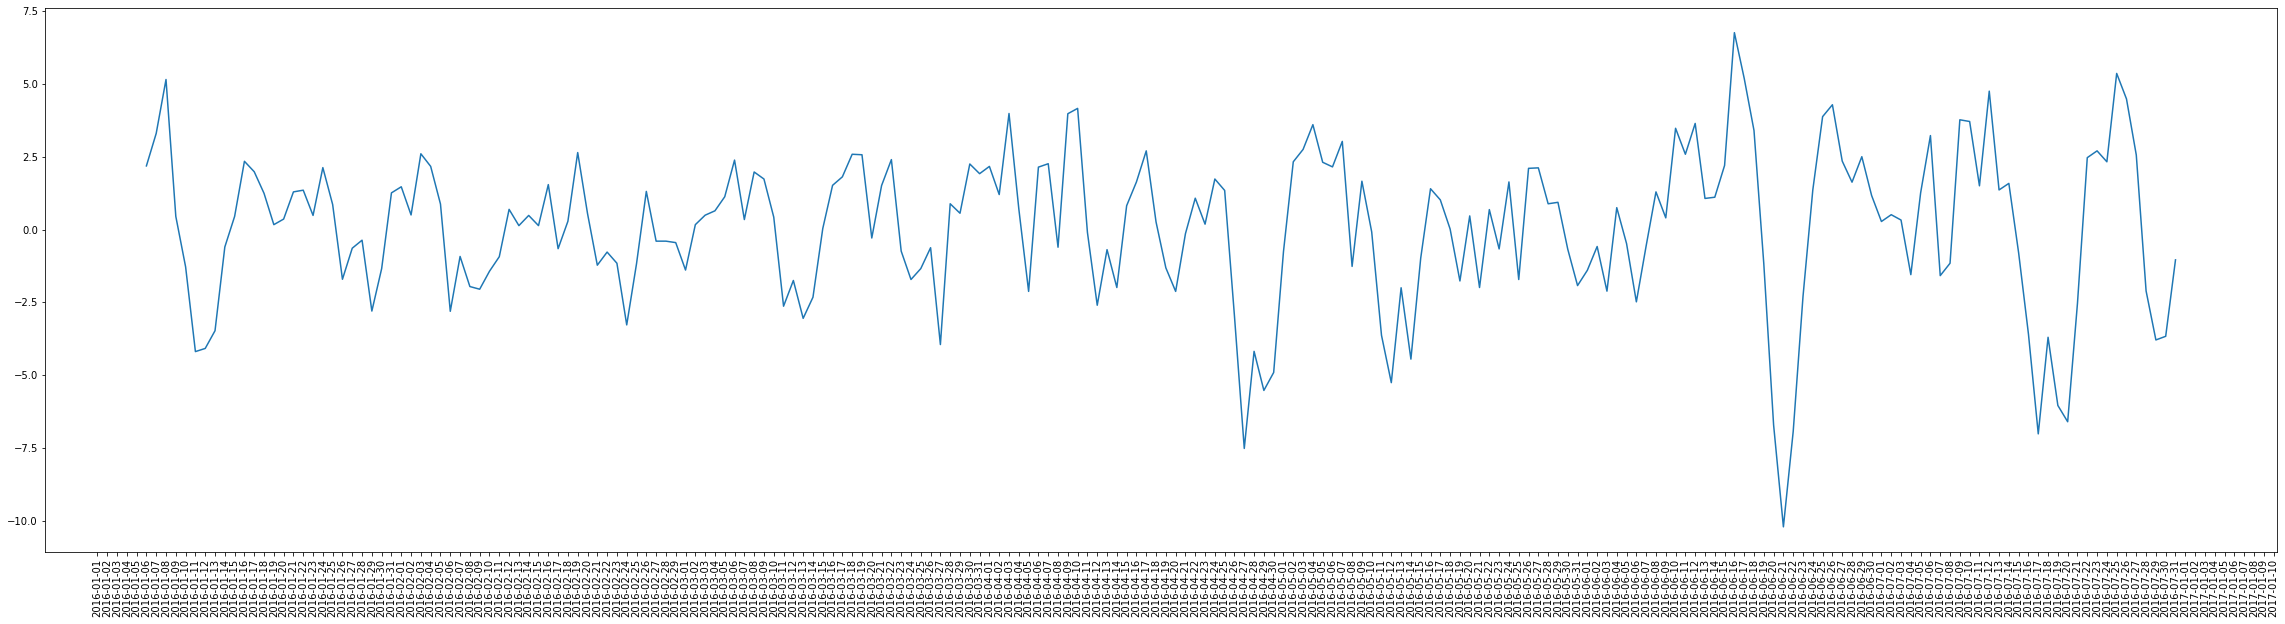

In [66]:
plt.figure(figsize=(40,10))
plt.xticks([i for i in range(eixo_2016_2019.shape[0])],[i[0] for i in eixo_2016_2019.values],rotation=90)
plt.plot(st_2016_suavizado.diff());
plt.show()

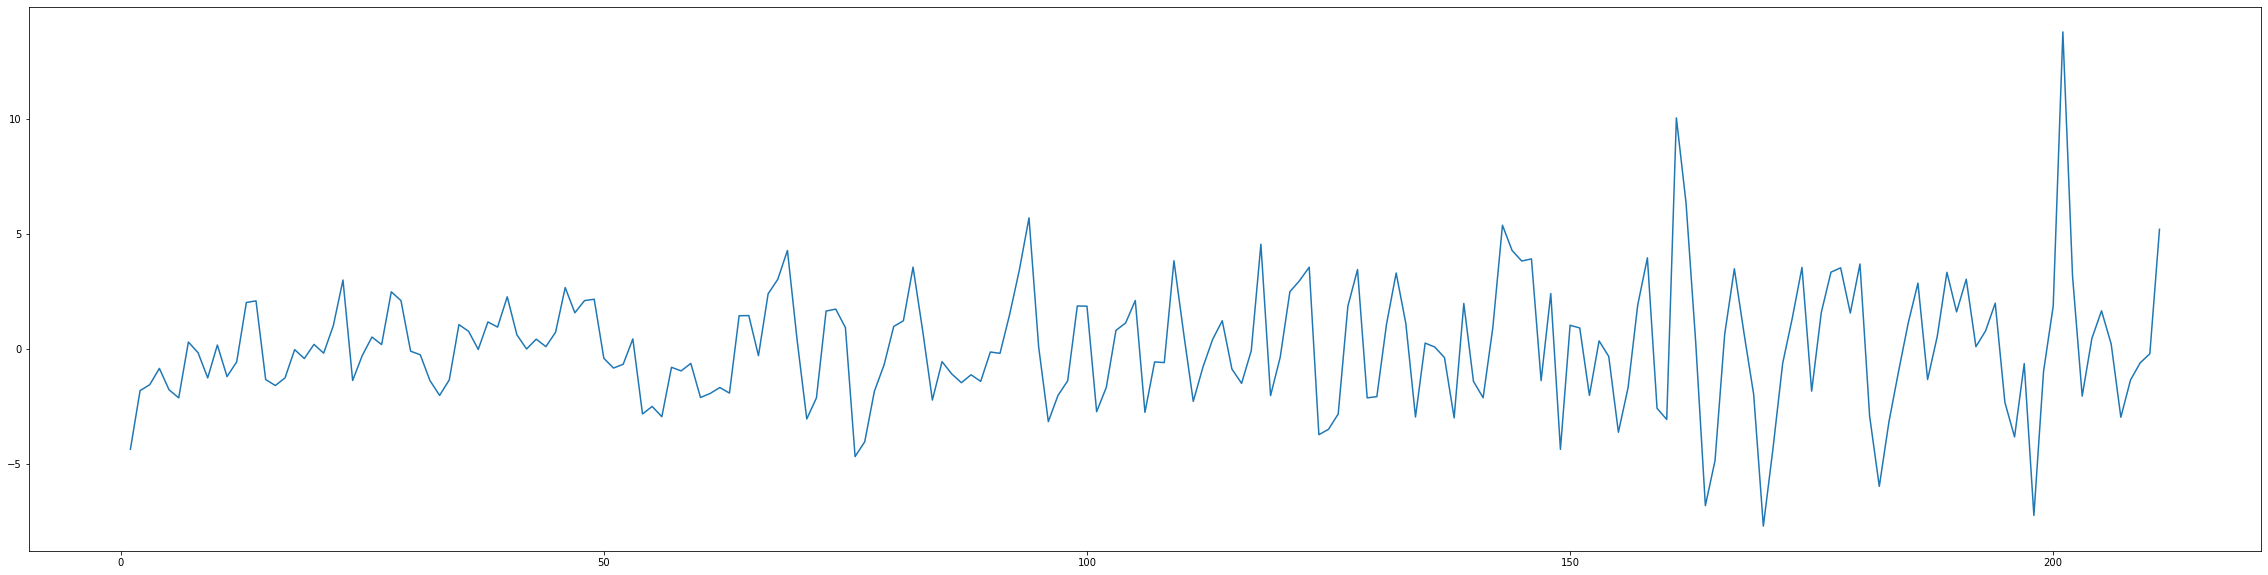

In [67]:
plt.figure(figsize=(40,10))
plt.plot(st_2017_suavizado.diff());

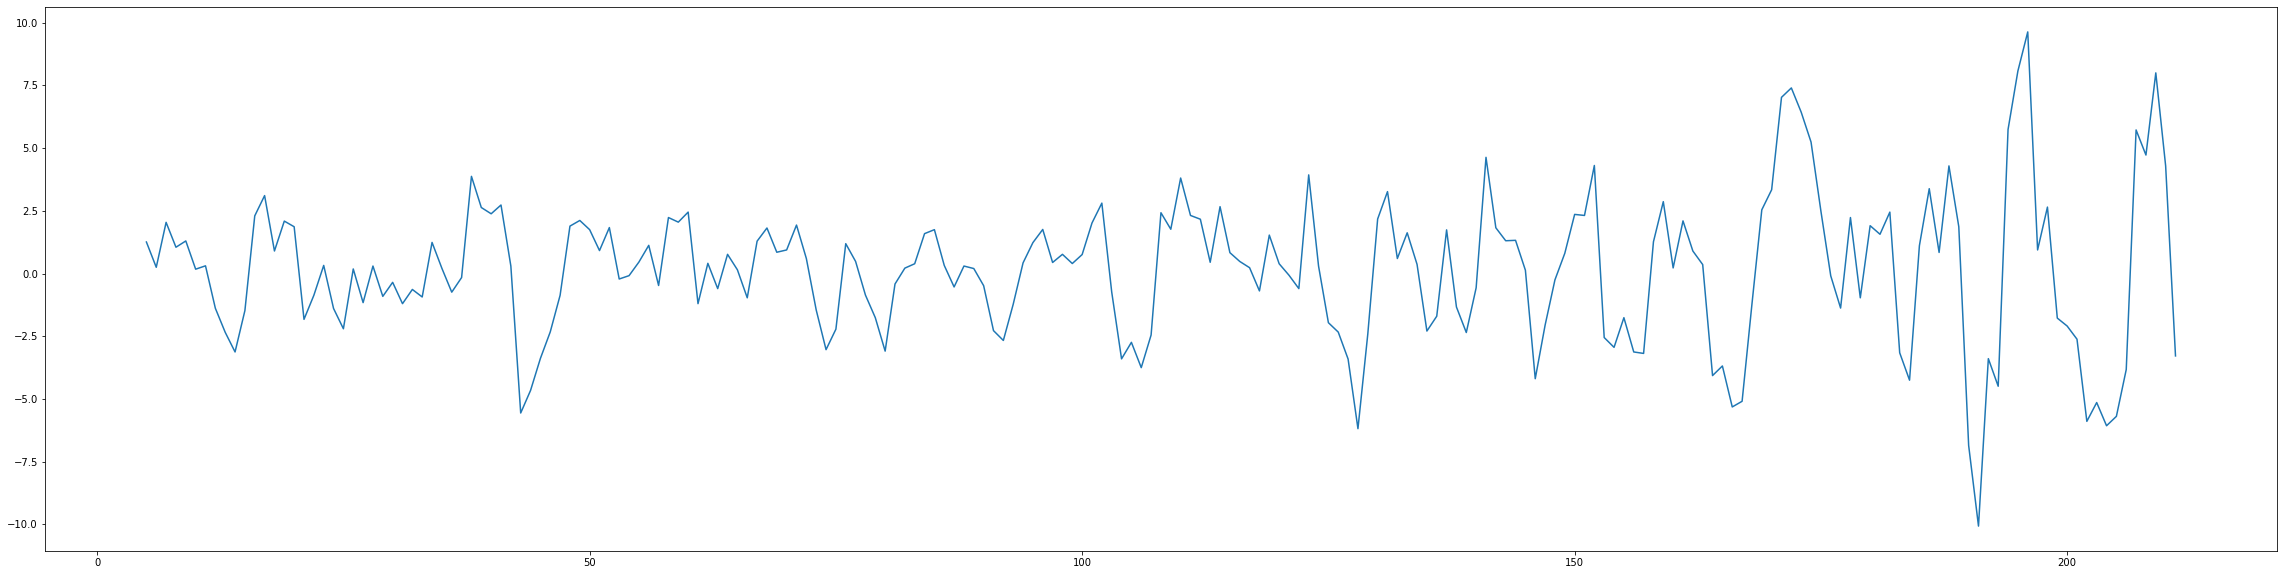

In [68]:
plt.figure(figsize=(40,10))
plt.plot(st_2018_suavizado.diff());

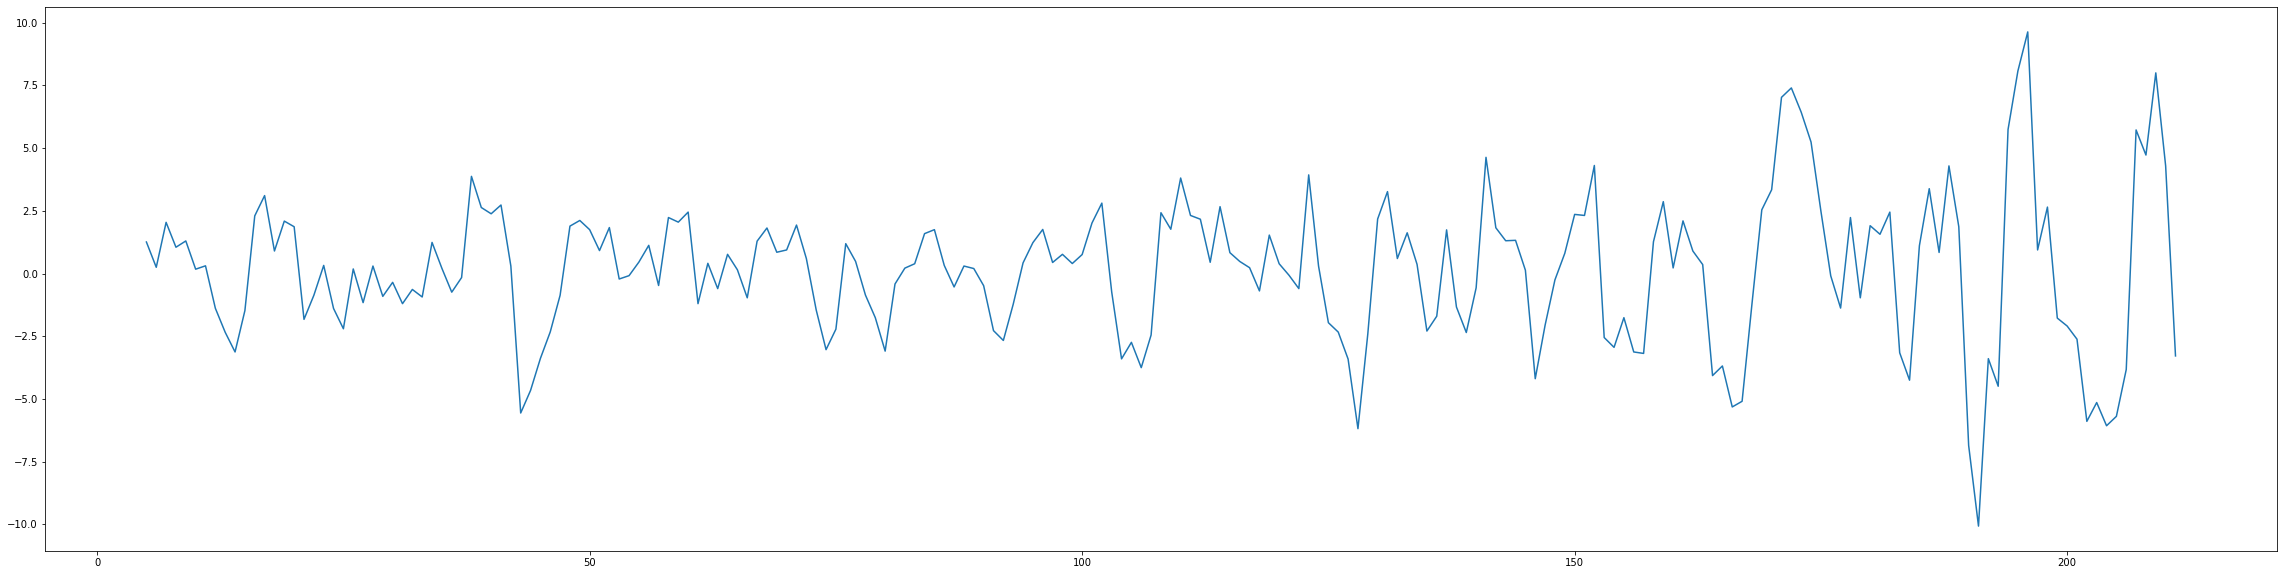

In [69]:
plt.figure(figsize=(40,10))
plt.plot(st_2019_suavizado.diff());

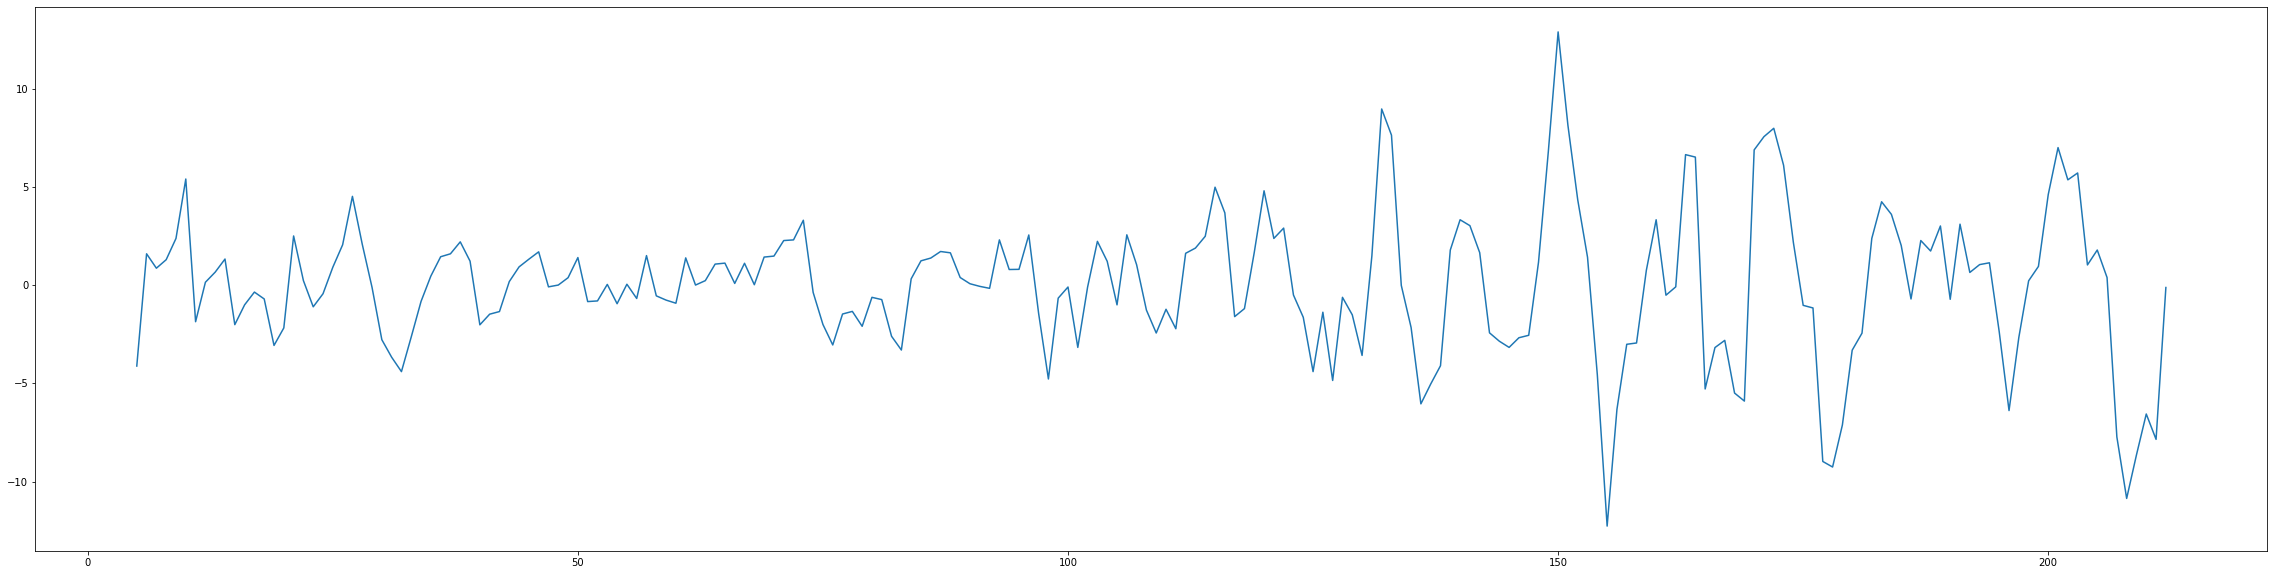

In [70]:
plt.figure(figsize=(40,10))
plt.plot(st_2020_suavizado.diff());

# Verifiacando a variação nos dados - aceleração de mundaça

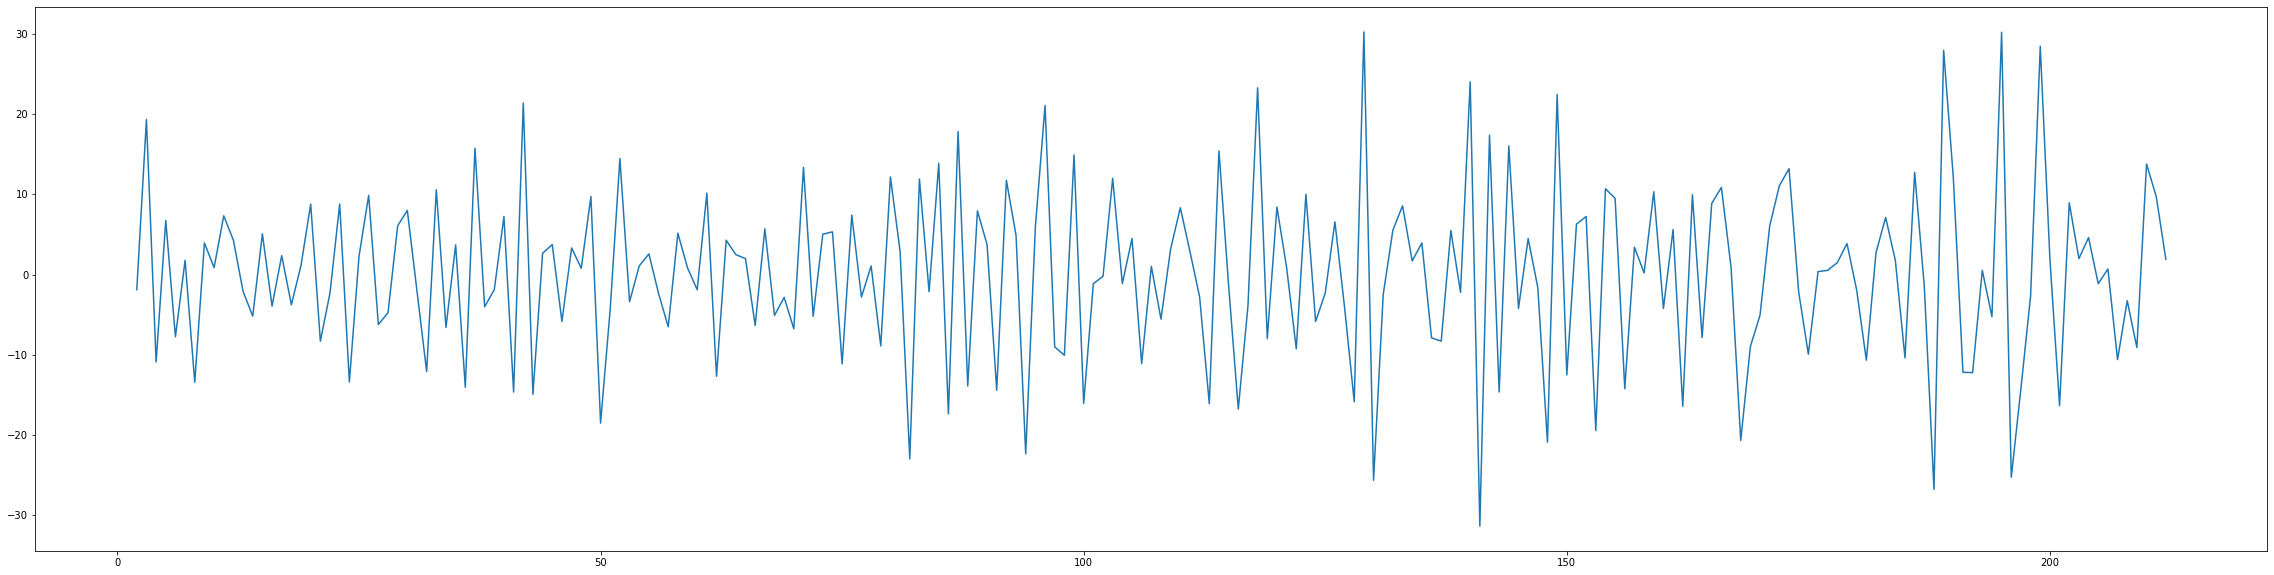

In [71]:
plt.figure(figsize=(40,10))
velocidade_2016 = dados_medios_completados_2016.diff()
plt.plot(velocidade_2016.diff());

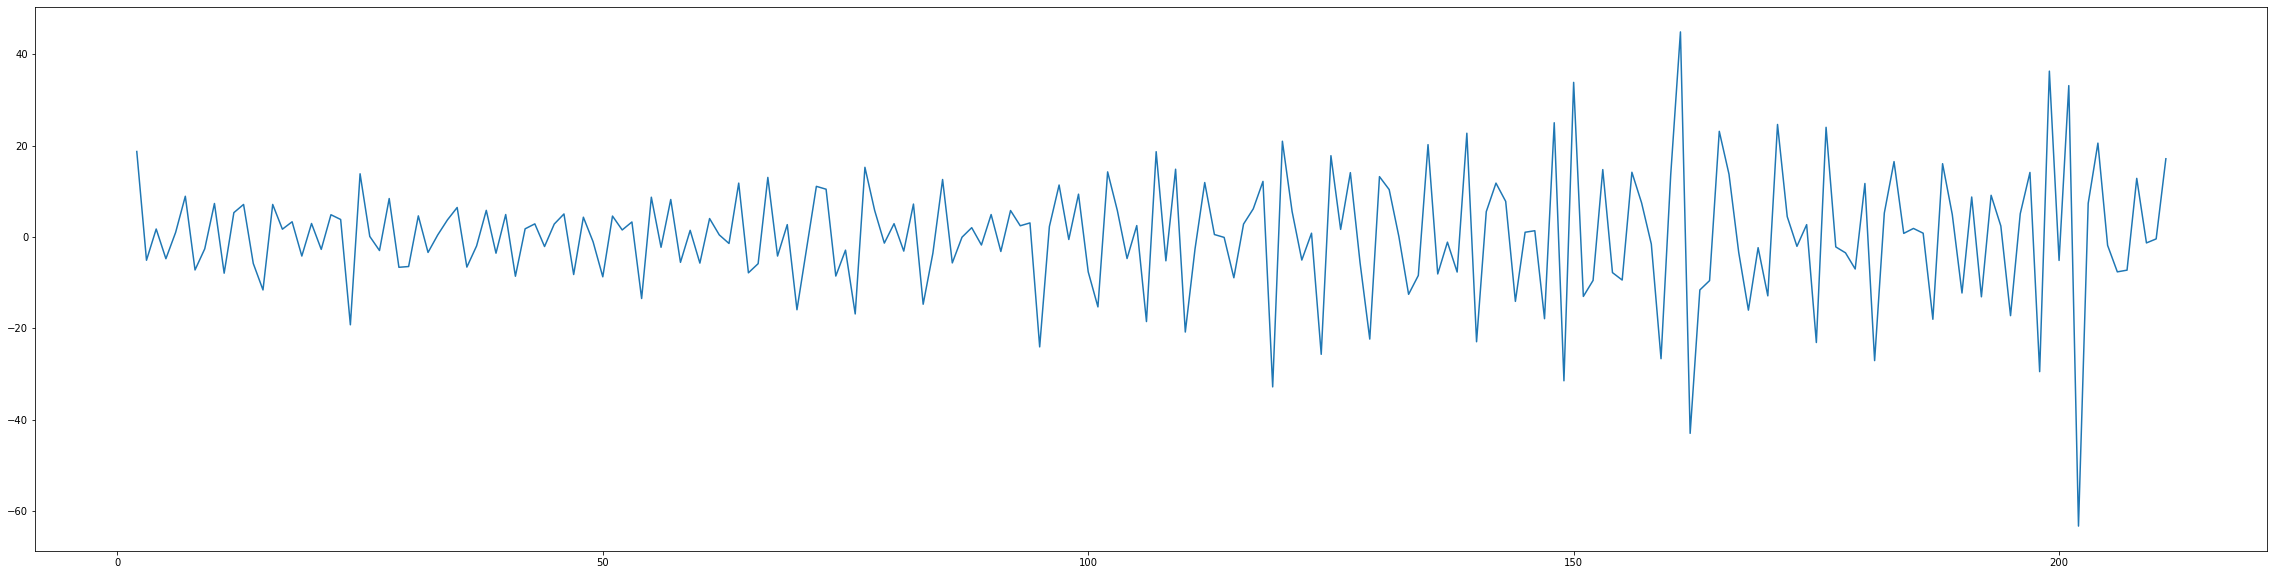

In [72]:
plt.figure(figsize=(40,10))
velocidade_2017 = dados_medios_completados_2017.diff()
plt.plot(velocidade_2017.diff());

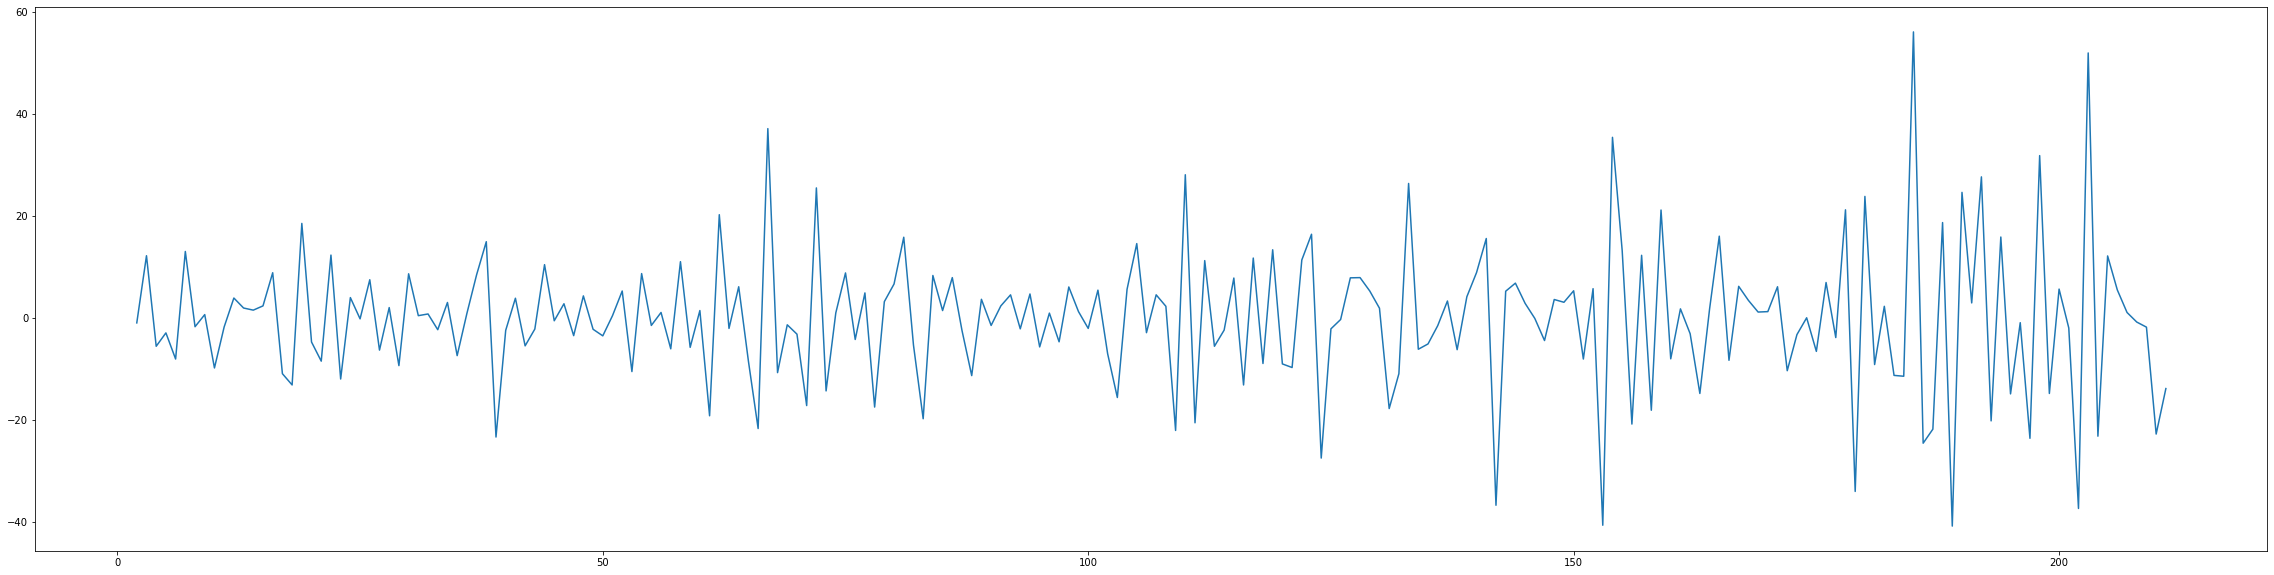

In [73]:
plt.figure(figsize=(40,10))
velocidade_2018 = dados_medios_completados_2018.diff()
plt.plot(velocidade_2018.diff());

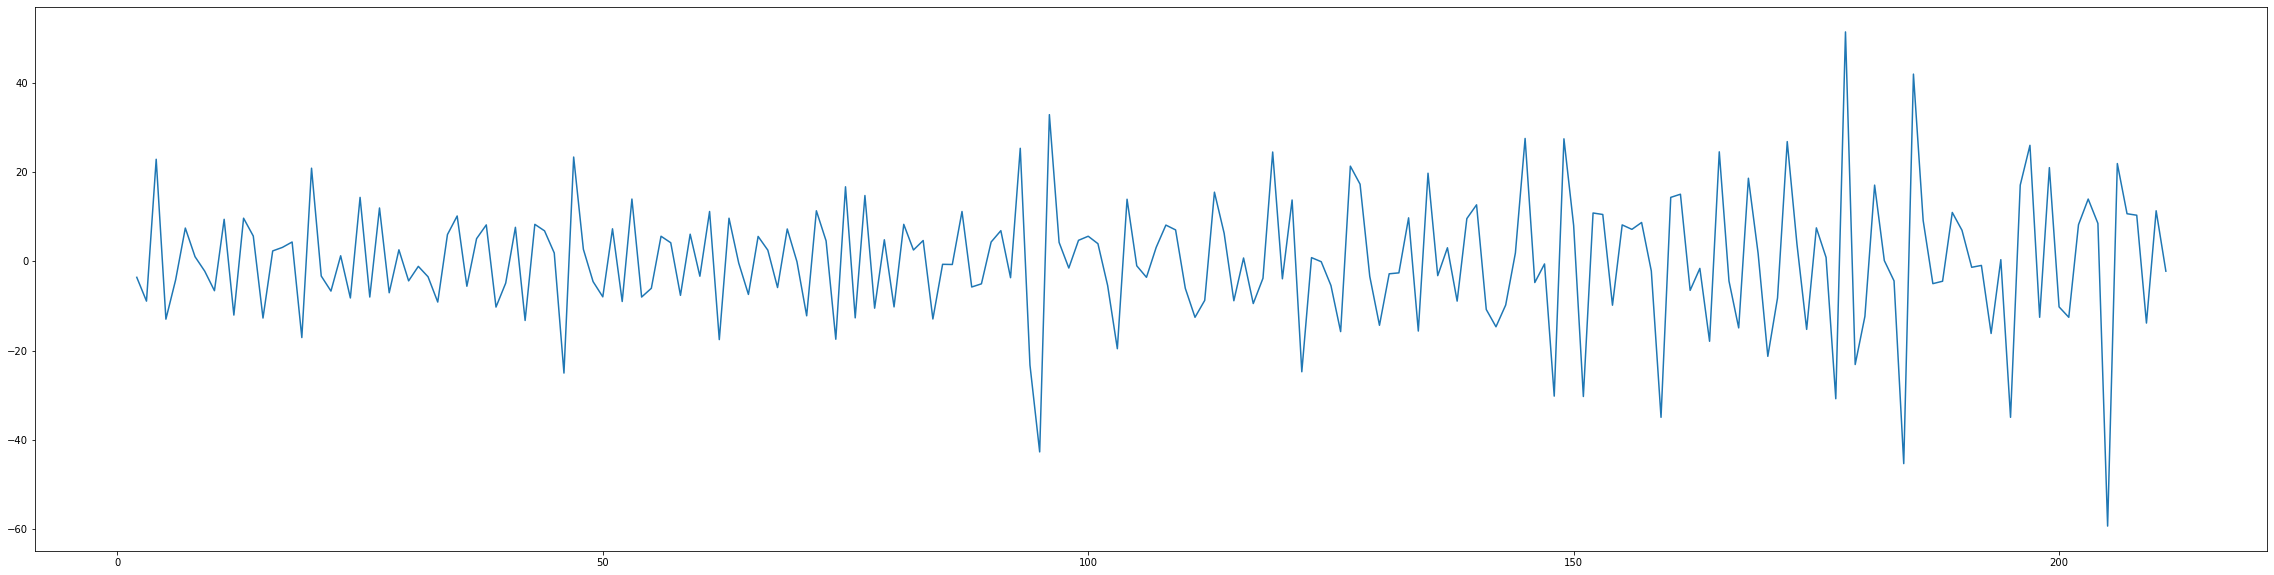

In [74]:
plt.figure(figsize=(40,10))
velocidade_2019 = dados_medios_completados_2019.diff()
plt.plot(velocidade_2019.diff());

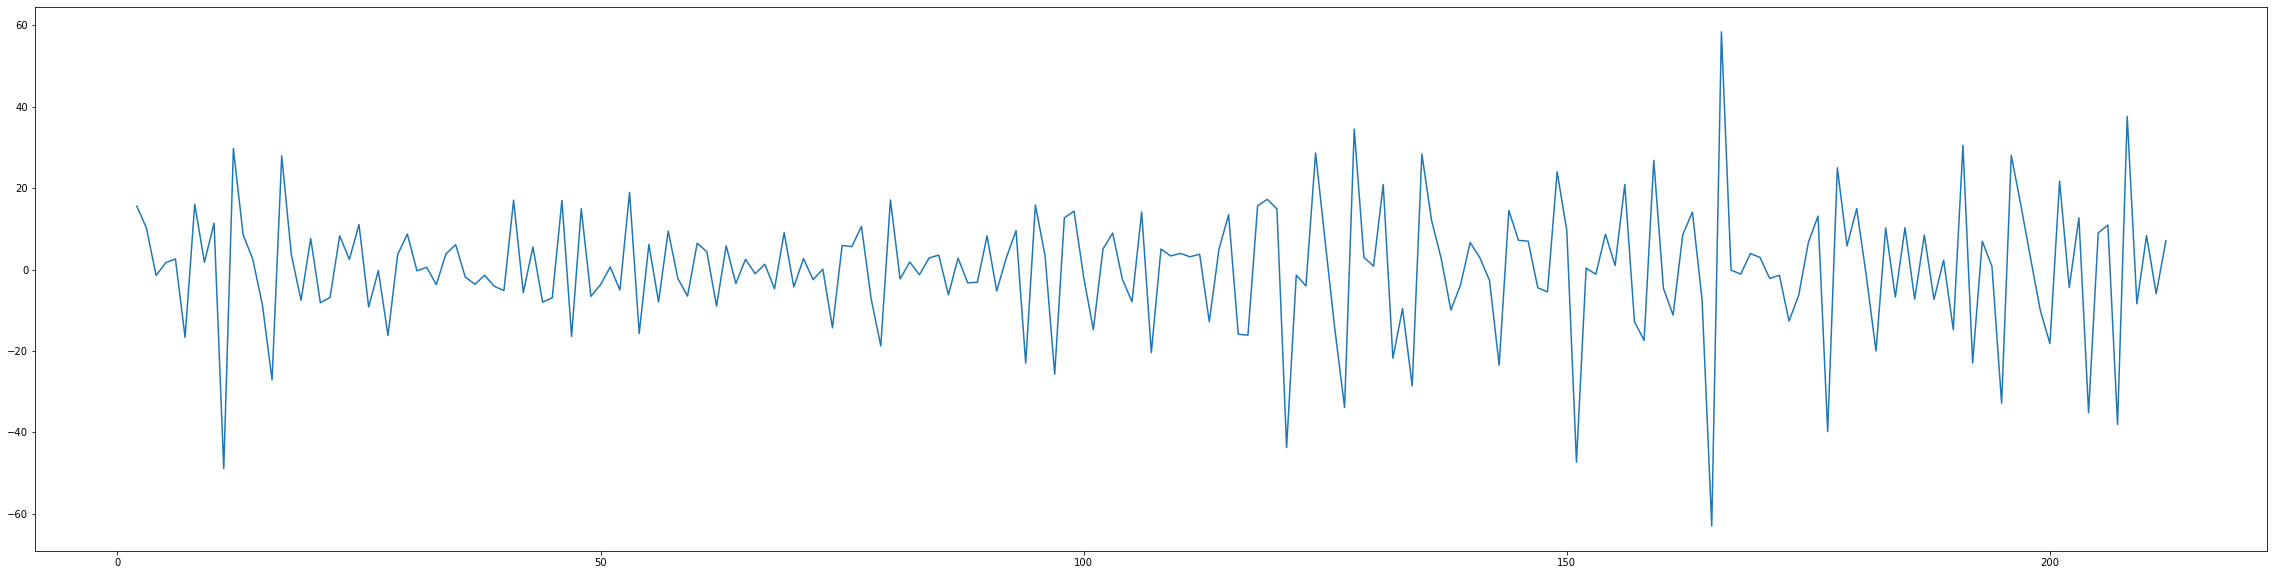

In [75]:
plt.figure(figsize=(40,10))
velocidade_2020 = dados_medios_completados_2020.diff()
plt.plot(velocidade_2020.diff());

# Autocorrelação da série

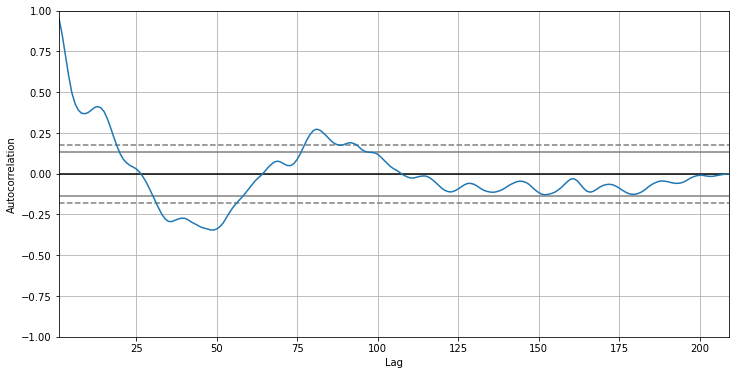

In [76]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2016_suavizado)

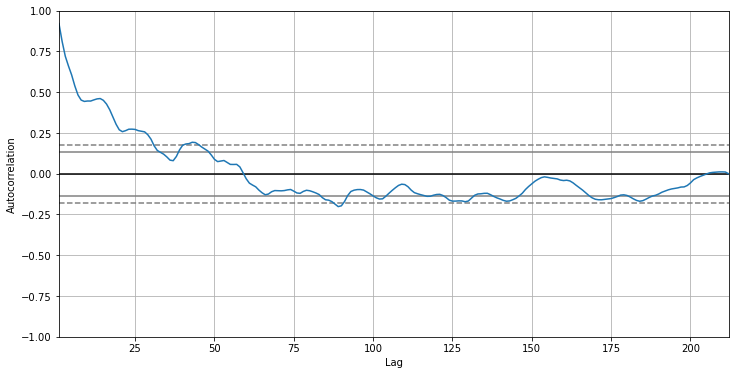

In [77]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2017_suavizado)

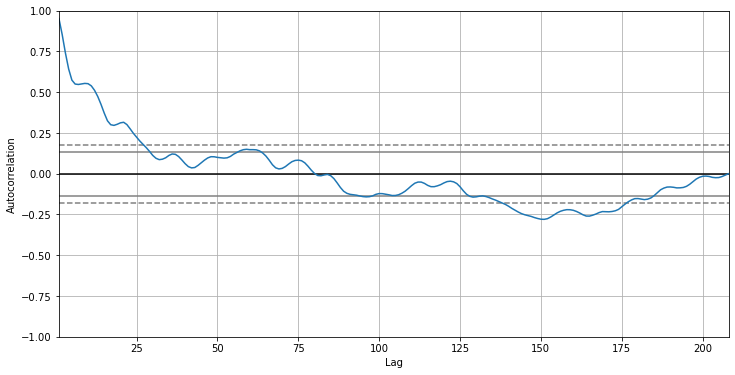

In [78]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2018_suavizado)

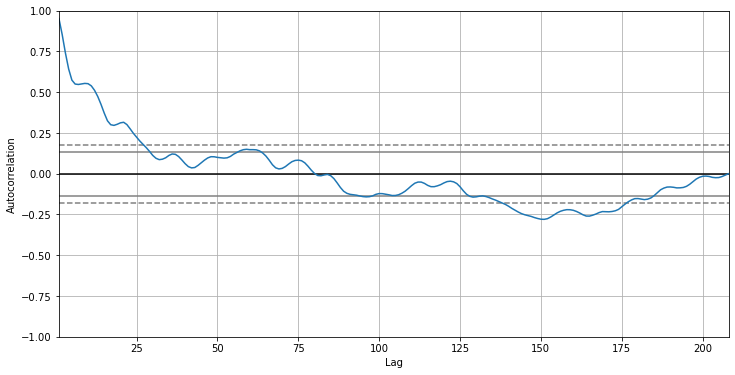

In [79]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2019_suavizado)

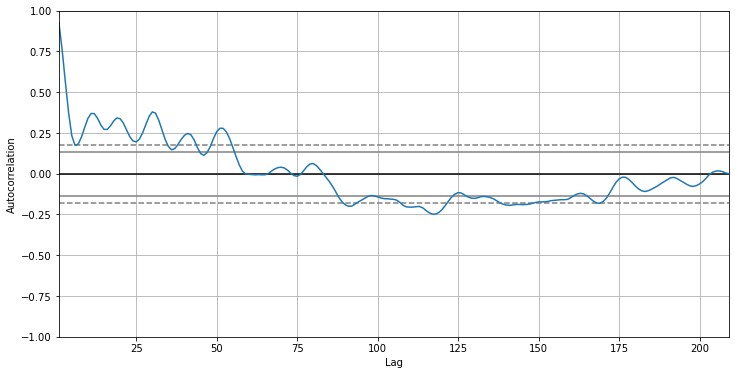

In [80]:
plt.figure(figsize=(12,6))
autocorrelation_plot(st_2020_suavizado)

# Juntado a base dados suavizada

In [81]:
st_2016_suavizado.dropna(inplace=True)
st_2016_suavizado.reset_index(drop=True,inplace=True)

st_2017_suavizado.dropna(inplace=True)
st_2016_suavizado.reset_index(drop=True,inplace=True)

st_2018_suavizado.dropna(inplace=True)
st_2018_suavizado.reset_index(drop=True,inplace=True)
st_2019_suavizado.dropna(inplace=True)
st_2019_suavizado.reset_index(drop=True,inplace=True)

st_2020_suavizado.dropna(inplace=True)
st_2020_suavizado.reset_index(drop=True,inplace=True)

serie_completa_suavizada = pd.concat([st_2017_suavizado,st_2018_suavizado,st_2019_suavizado,st_2020_suavizado])
serie_completa_suavizada.reset_index(drop=True, inplace=True)
serie_completa_suavizada

0
0    28.625000
1    24.250000
2    22.425000
3    20.860000
4    20.002000
..         ...
832  34.925000
833  26.283333
834  19.725000
835  11.875000
836  11.758333

[837 rows x 1 columns]

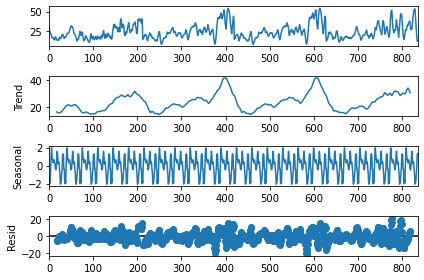

In [82]:
resultado_st = seasonal_decompose(serie_completa_suavizada,period=35)
resultado_st.plot();

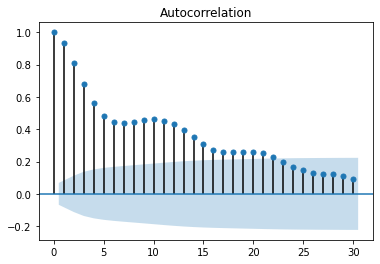

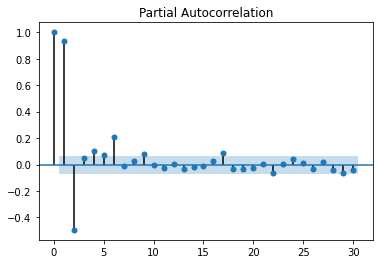

In [83]:
plot_acf(serie_completa_suavizada);
plot_pacf(serie_completa_suavizada);

# Verificando a velocidade de mundaça

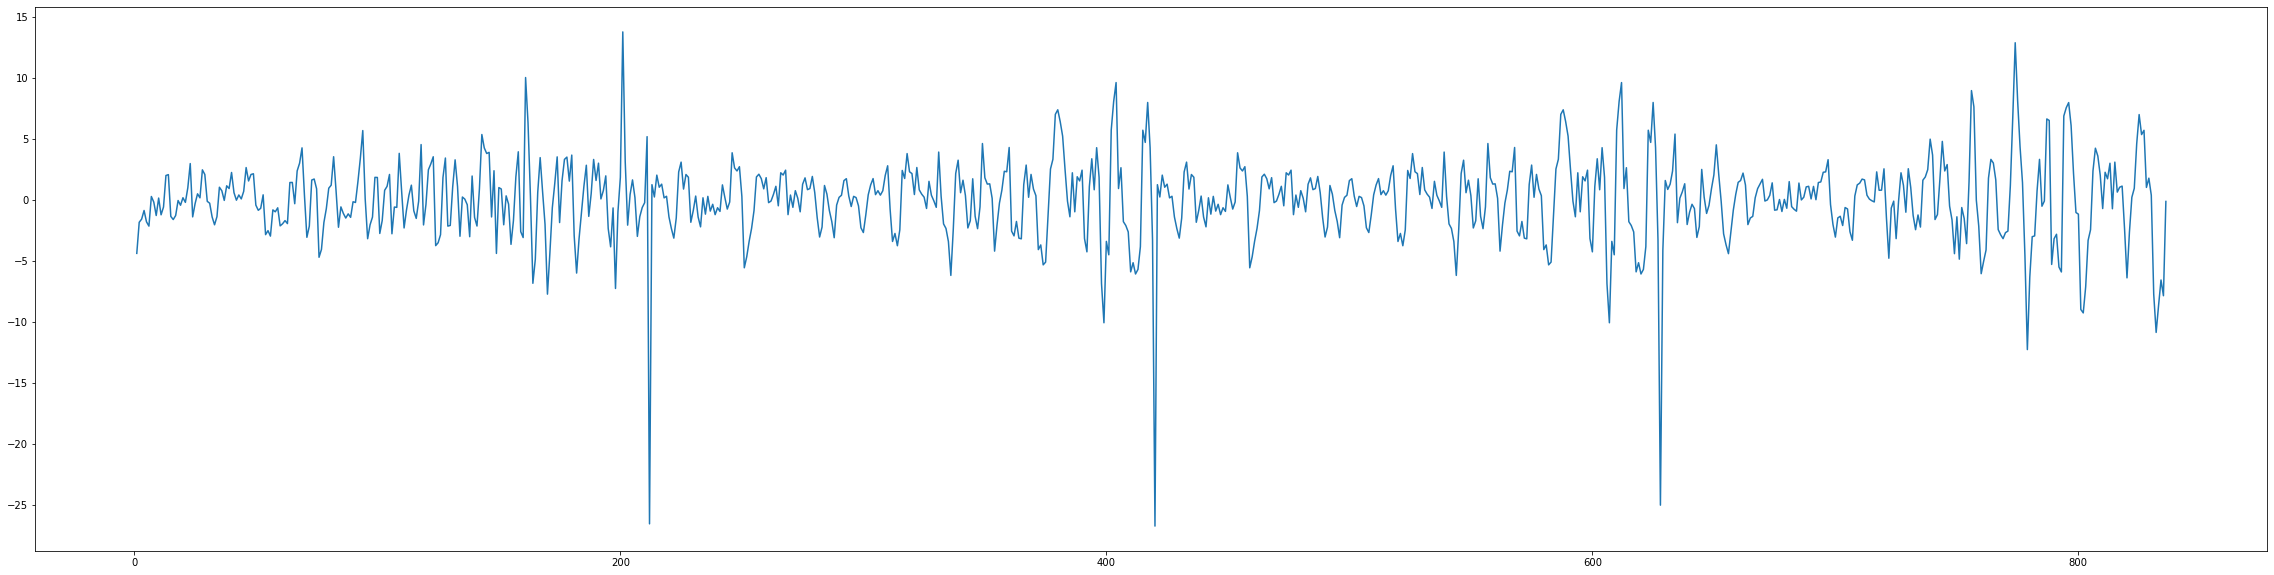

In [84]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_suavizada.diff());

# Verificando a aceleração de mundaça

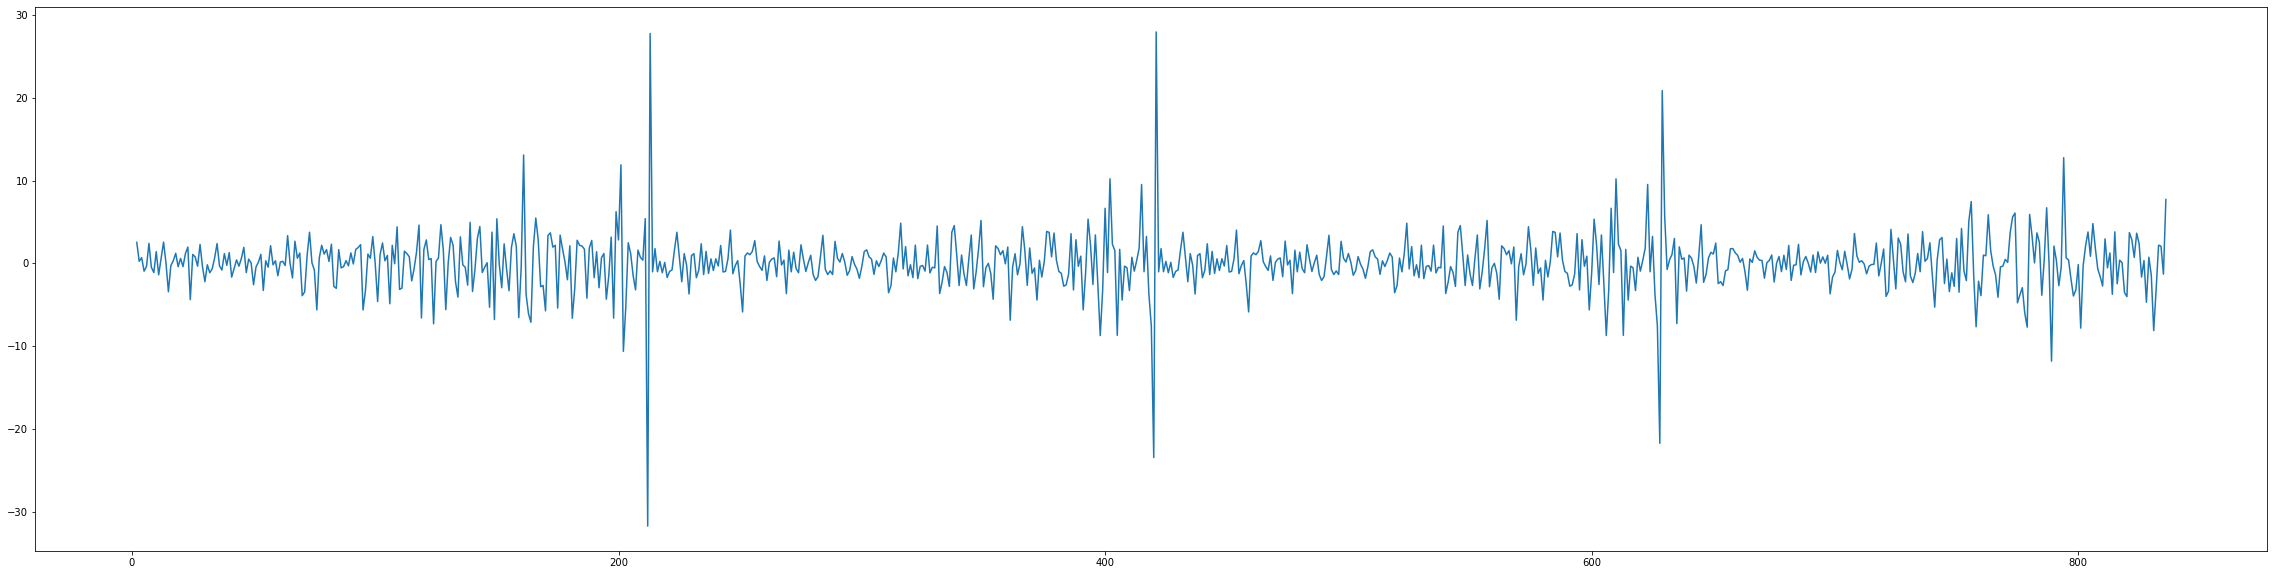

In [85]:
plt.figure(figsize=(40,10))
velocidade = serie_completa_suavizada.diff()
plt.plot(velocidade.diff());

# Jutando dados de 2016 a 2019

In [86]:
serie_completa_suavizada = pd.concat([st_2016_suavizado,st_2017_suavizado,st_2018_suavizado,st_2019_suavizado])
serie_completa_suavizada.reset_index(drop=True, inplace=True)
serie_completa_suavizada

0
0    14.758333
1    16.941667
2    20.241667
3    25.391667
4    25.841667
..         ...
832  26.991667
833  31.716667
834  39.716667
835  44.008333
836  40.725000

[837 rows x 1 columns]

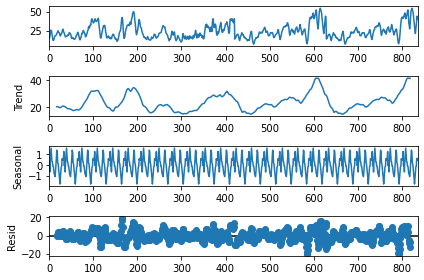

In [87]:
resultado_st = seasonal_decompose(serie_completa_suavizada,period=35)
resultado_st.plot();

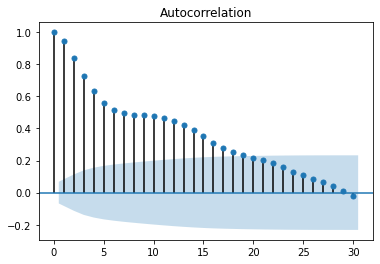

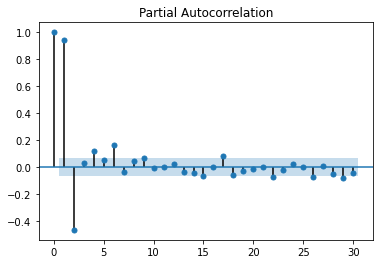

In [88]:
plot_acf(serie_completa_suavizada);
plot_pacf(serie_completa_suavizada);

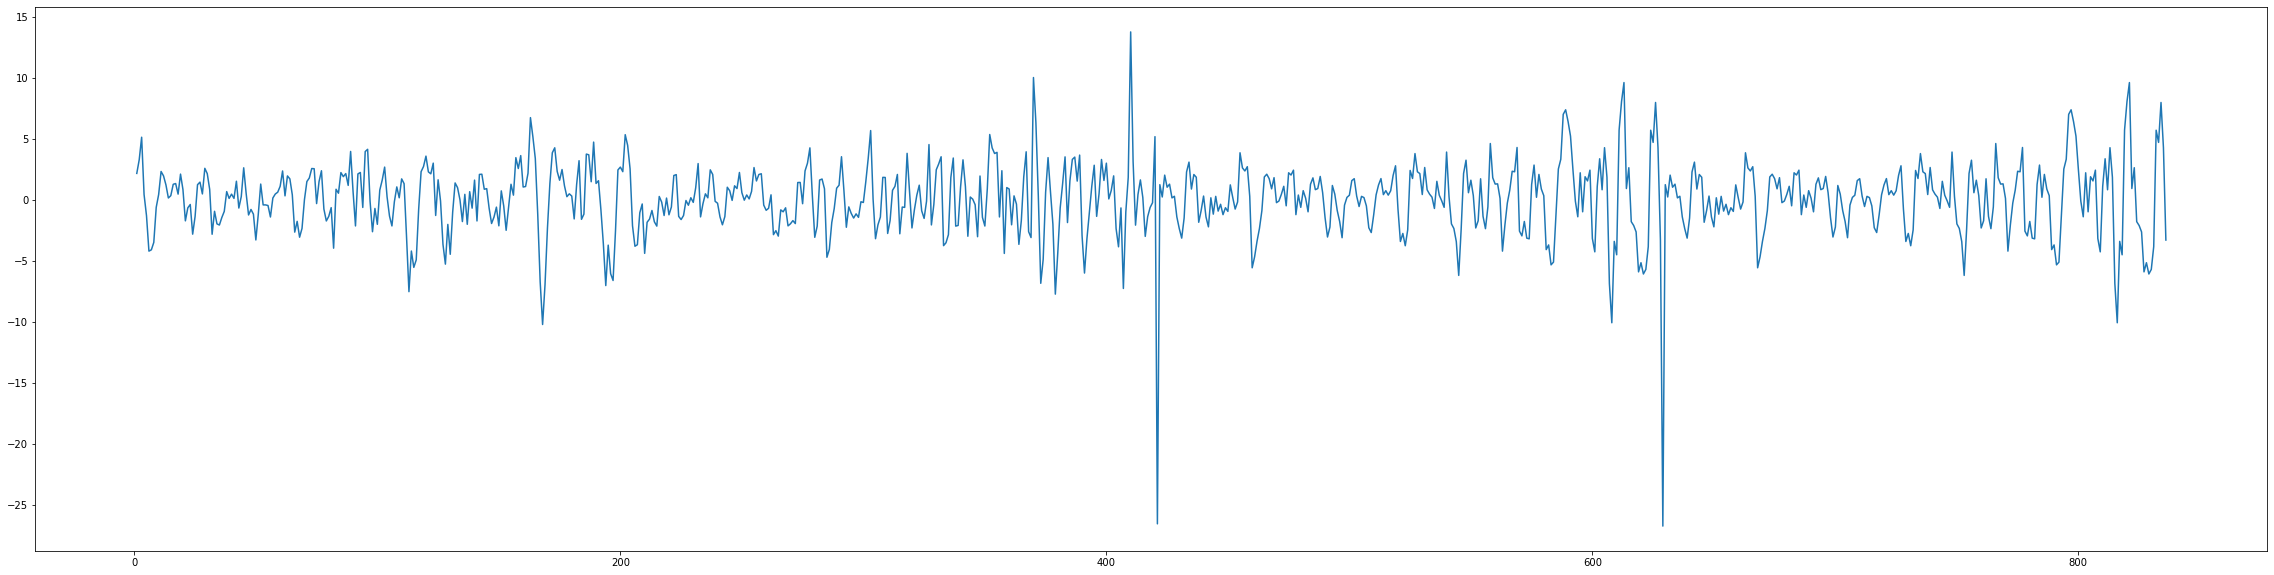

In [89]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_suavizada.diff());

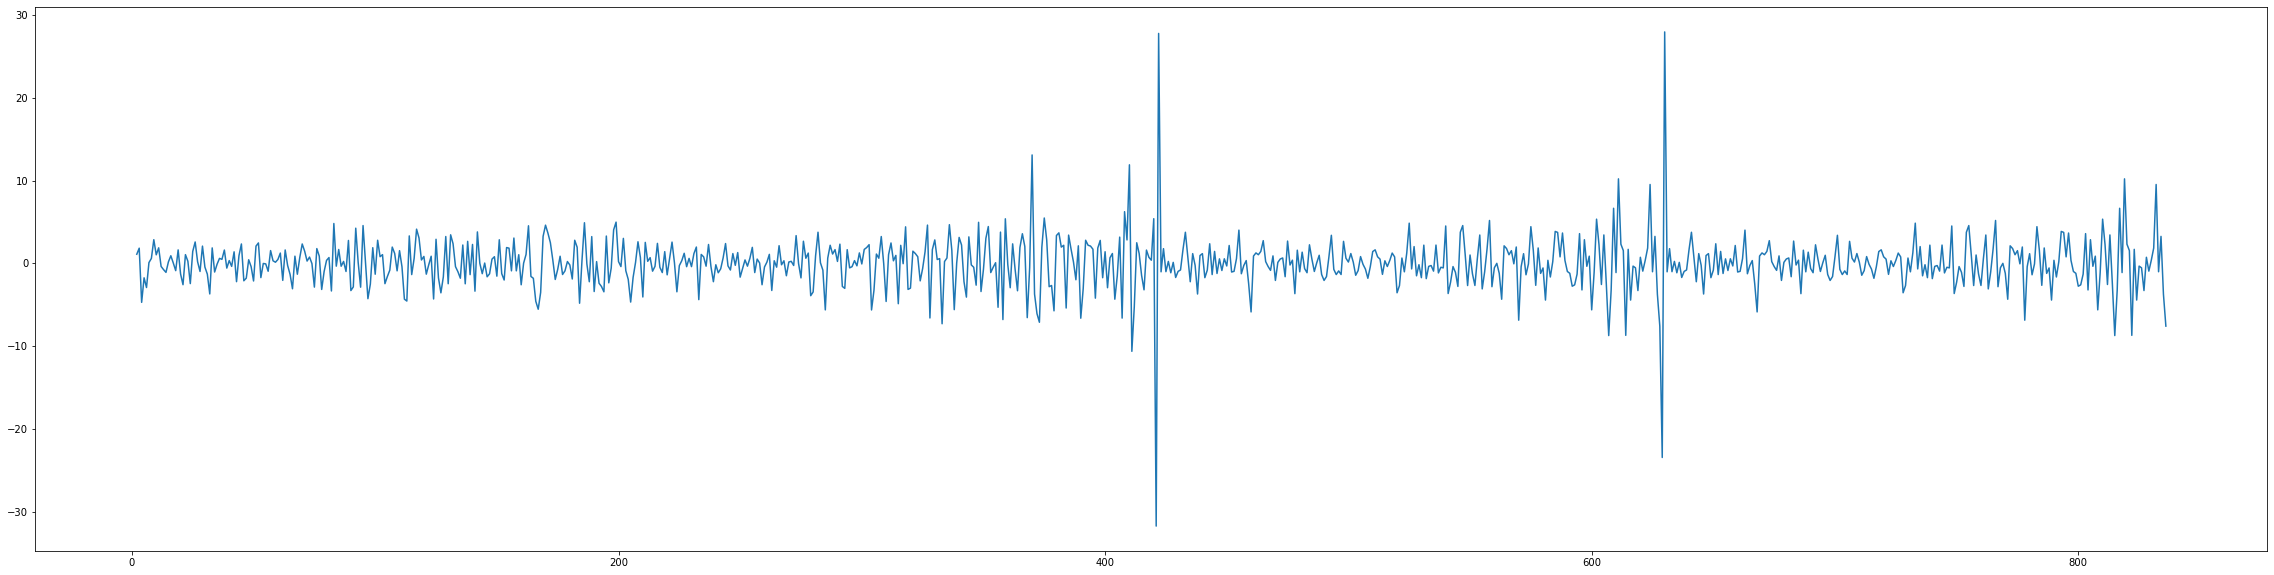

In [90]:
plt.figure(figsize=(40,10))
velocidade = serie_completa_suavizada.diff()
plt.plot(velocidade.diff());

# Analisando por mês a série

In [91]:
dados_mensais_medios_2016 = pd.DataFrame({'Dados mensais':[]})
dados_mensais_medios_2017 = pd.DataFrame({'Dados mensais':[]})
dados_mensais_medios_2018 = pd.DataFrame({'Dados mensais':[]})
dados_mensais_medios_2019 = pd.DataFrame({'Dados mensais':[]})
dados_mensais_medios_2020 = pd.DataFrame({'Dados mensais':[]})

for i in range(7):
    aux = i*30
    dados_mensais_medios_2016 = dados_mensais_medios_2016.append({'Dados mensais':dados_medios_completados_2016[aux:(i+1)*30].mean()},ignore_index=True)
    dados_mensais_medios_2017 = dados_mensais_medios_2017.append({'Dados mensais':dados_medios_completados_2017[aux:(i+1)*30].mean()},ignore_index=True)
    dados_mensais_medios_2018 = dados_mensais_medios_2018.append({'Dados mensais':dados_medios_completados_2018[aux:(i+1)*30].mean()},ignore_index=True)
    dados_mensais_medios_2019 = dados_mensais_medios_2019.append({'Dados mensais':dados_medios_completados_2019[aux:(i+1)*30].mean()},ignore_index=True)
    dados_mensais_medios_2020 = dados_mensais_medios_2020.append({'Dados mensais':dados_medios_completados_2020[aux:(i+1)*30].mean()},ignore_index=True)

In [92]:
messes = pd.DataFrame({'Mes/ano':[]})
for j in ['2016','2017','2018','2019']:
    for i in ['jan','fev','mar','abr','mai','jun','jul']:
        messes = messes.append({"Mes/ano":j+'/'+i},ignore_index=True)
messes

Mes/ano
0   2016/jan
1   2016/fev
2   2016/mar
3   2016/abr
4   2016/mai
5   2016/jun
6   2016/jul
7   2017/jan
8   2017/fev
9   2017/mar
10  2017/abr
11  2017/mai
12  2017/jun
13  2017/jul
14  2018/jan
15  2018/fev
16  2018/mar
17  2018/abr
18  2018/mai
19  2018/jun
20  2018/jul
21  2019/jan
22  2019/fev
23  2019/mar
24  2019/abr
25  2019/mai
26  2019/jun
27  2019/jul

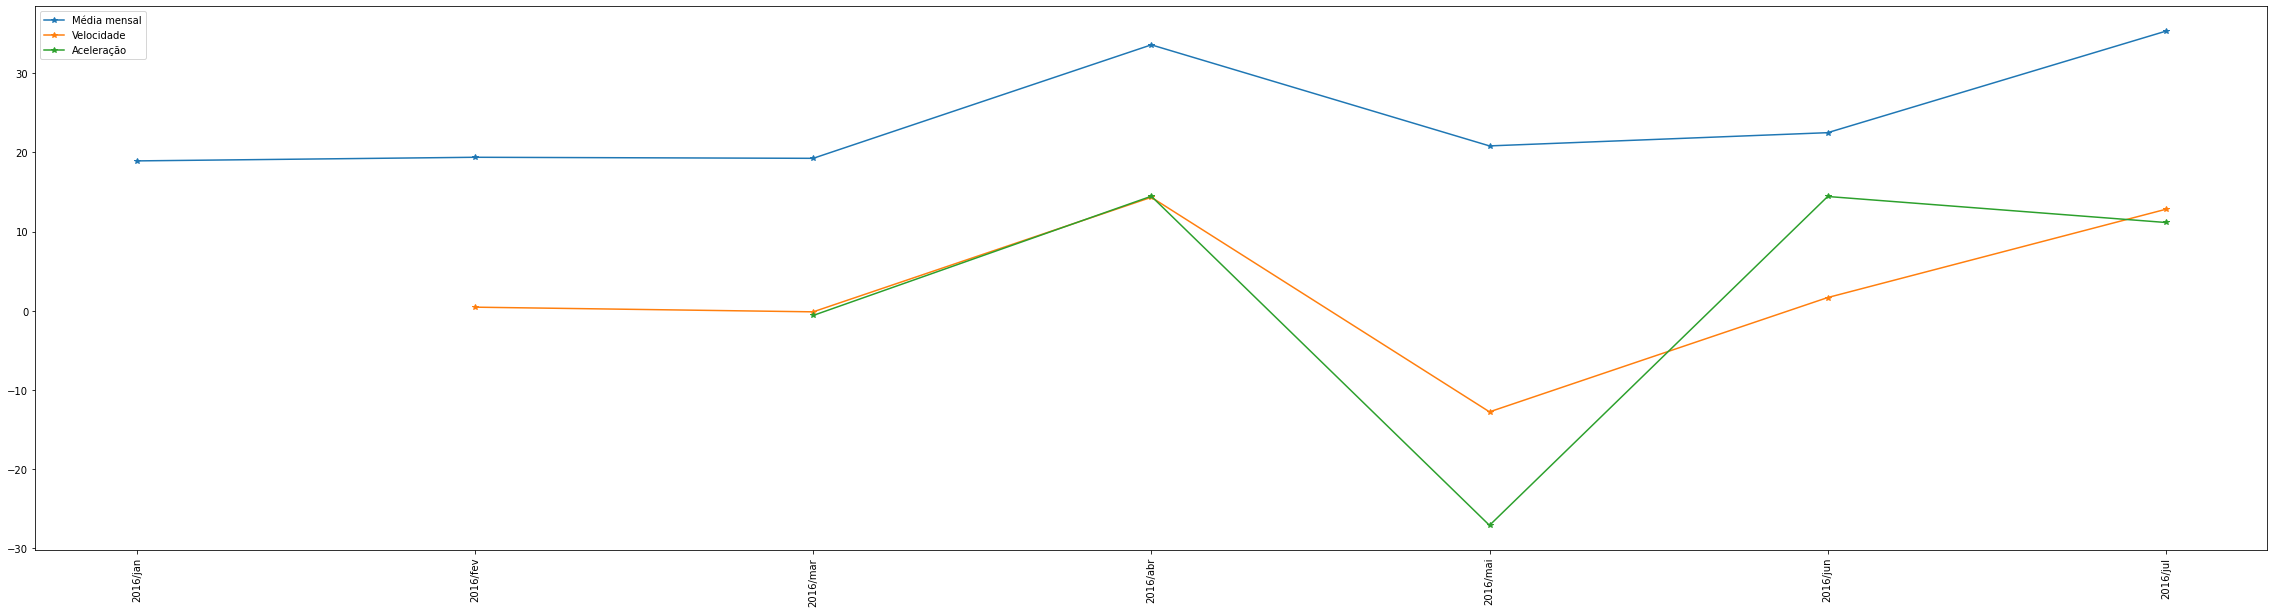

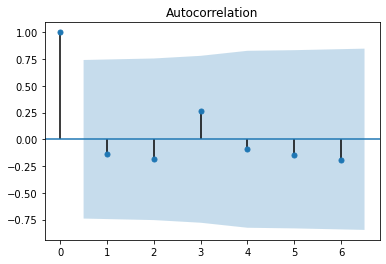

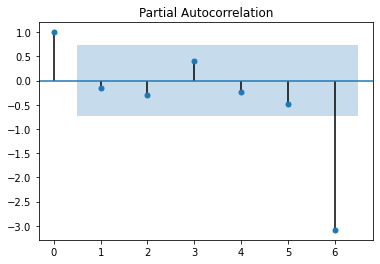

In [93]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2016,'*-',label='Média mensal')
plt.plot(dados_mensais_medios_2016.diff(),'*-',label='Velocidade')
plt.plot(dados_mensais_medios_2016.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(dados_mensais_medios_2016.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plot_acf(dados_mensais_medios_2016);
plot_pacf(dados_mensais_medios_2016);
plt.show()

In [94]:
messes = pd.DataFrame({'Mes/ano':[]})
for j in ['2017','2018','2019','2020']:
    for i in ['jan','fev','mar','abr','mai','jun','jul']:
        messes = messes.append({"Mes/ano":j+'/'+i},ignore_index=True)

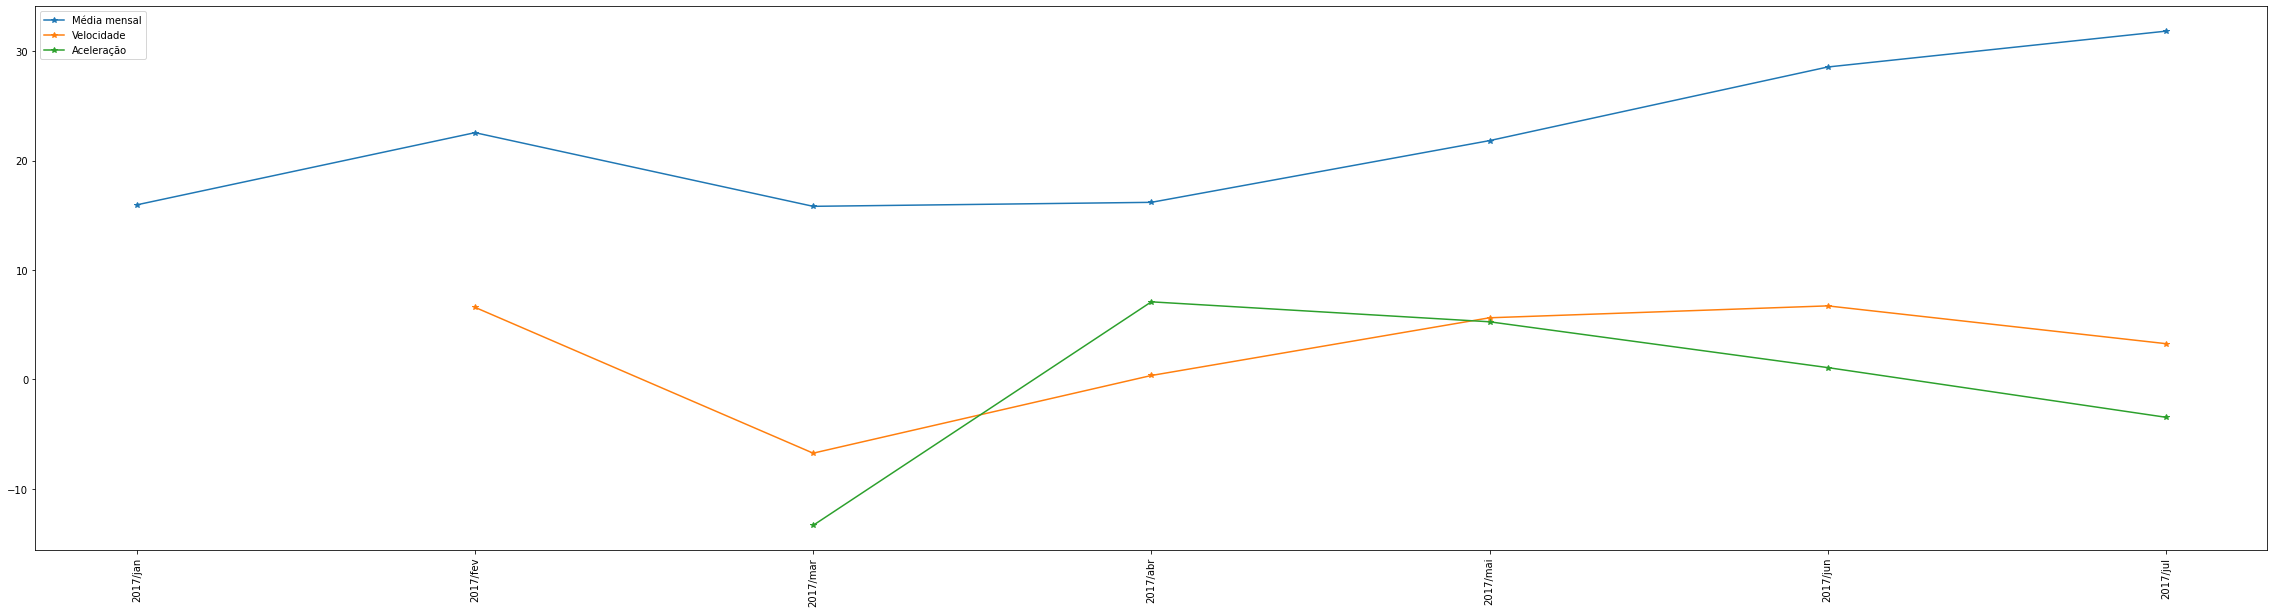

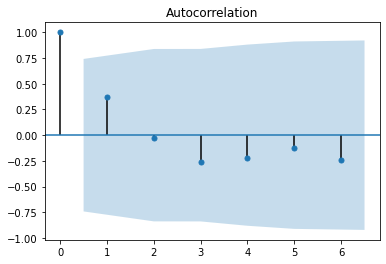

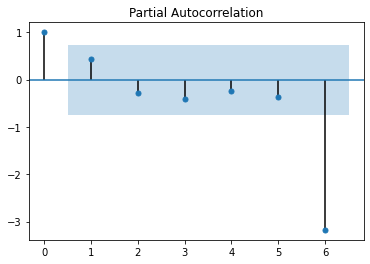

In [95]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2017,'*-',label='Média mensal')
plt.plot(dados_mensais_medios_2017.diff(),'*-',label='Velocidade')
plt.plot(dados_mensais_medios_2017.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(dados_mensais_medios_2017.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plot_acf(dados_mensais_medios_2017);
plot_pacf(dados_mensais_medios_2017);
plt.show()

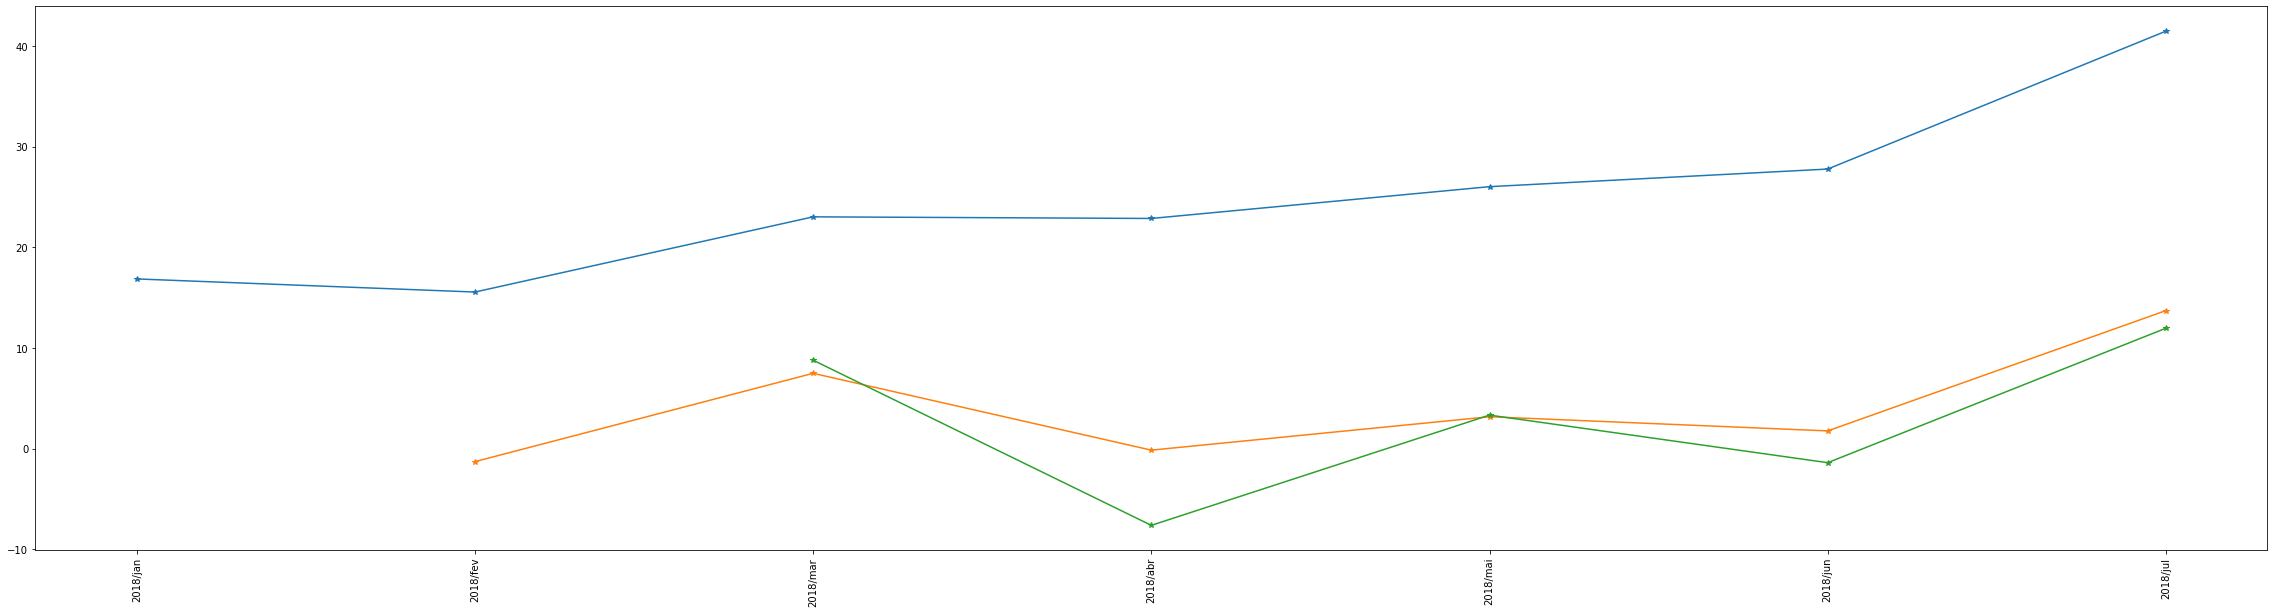

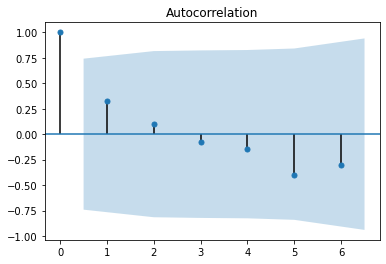

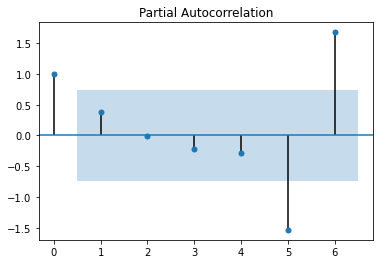

In [96]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2018,'*-')
plt.plot(dados_mensais_medios_2018.diff(),'*-')
plt.plot(dados_mensais_medios_2018.diff().diff(),'*-')
plt.xticks([i for i in range(dados_mensais_medios_2018.shape[0])],[i[0] for i in messes[7:14].values],rotation=90)
plot_acf(dados_mensais_medios_2018);
plot_pacf(dados_mensais_medios_2018);
plt.show()

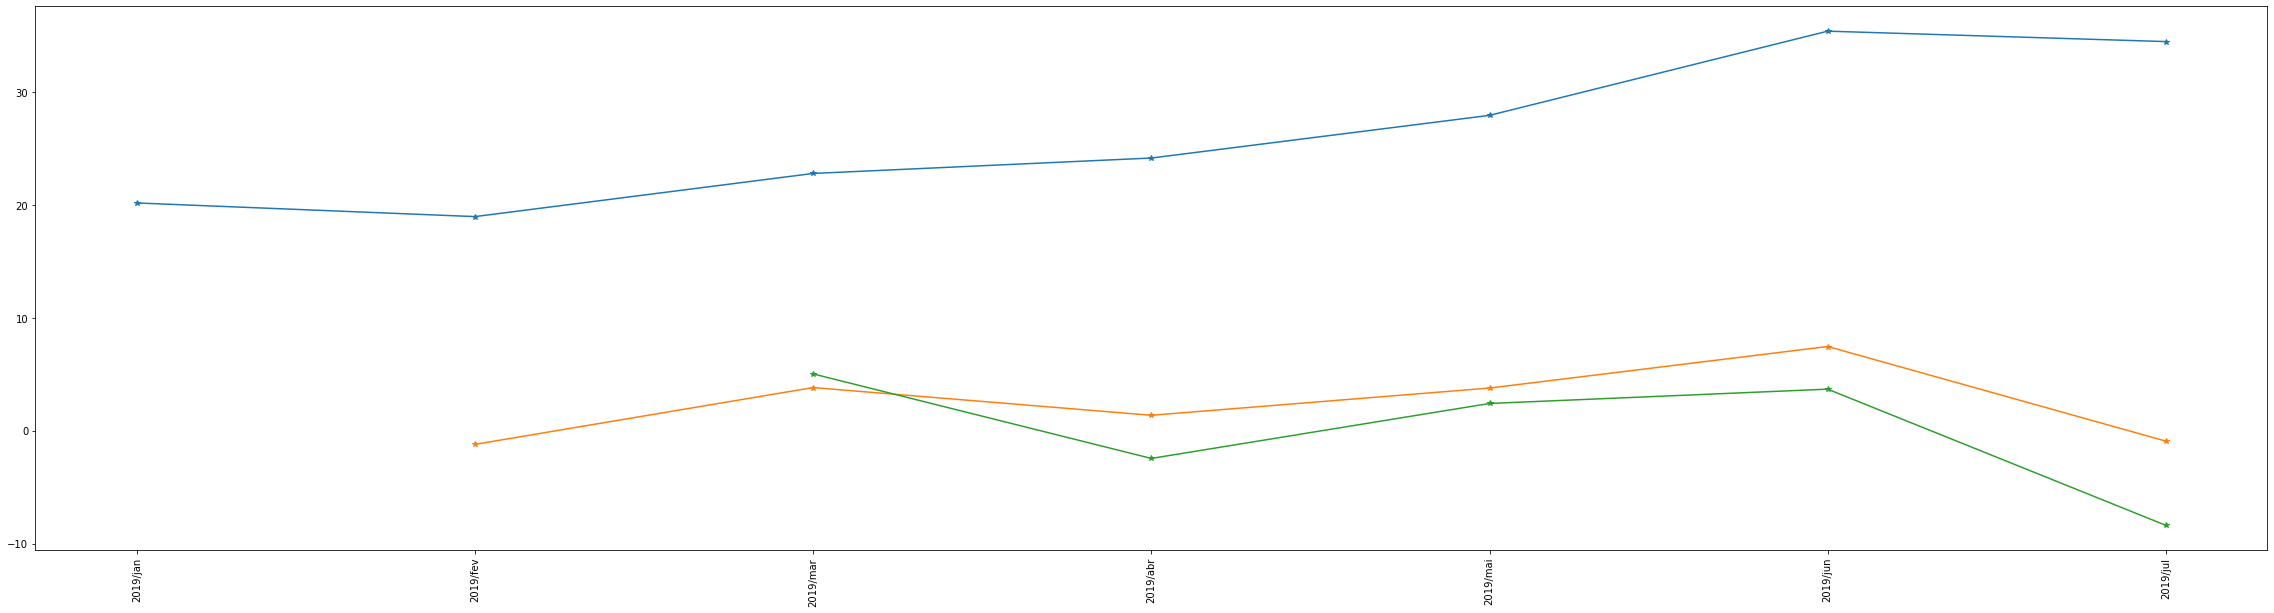

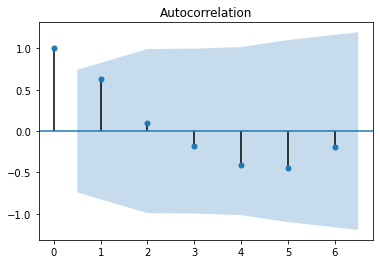

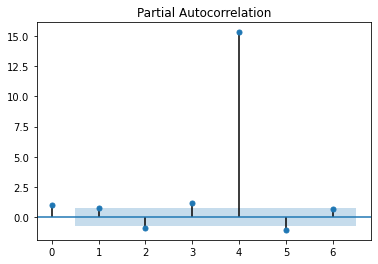

In [97]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2019,'*-',label='Média mensal')
plt.plot(dados_mensais_medios_2019.diff(),'*-',label='Velocidade')
plt.plot(dados_mensais_medios_2019.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(dados_mensais_medios_2018.shape[0])],[i[0] for i in messes[14:21].values],rotation=90)
plot_acf(dados_mensais_medios_2019);
plot_pacf(dados_mensais_medios_2019);
plt.show()

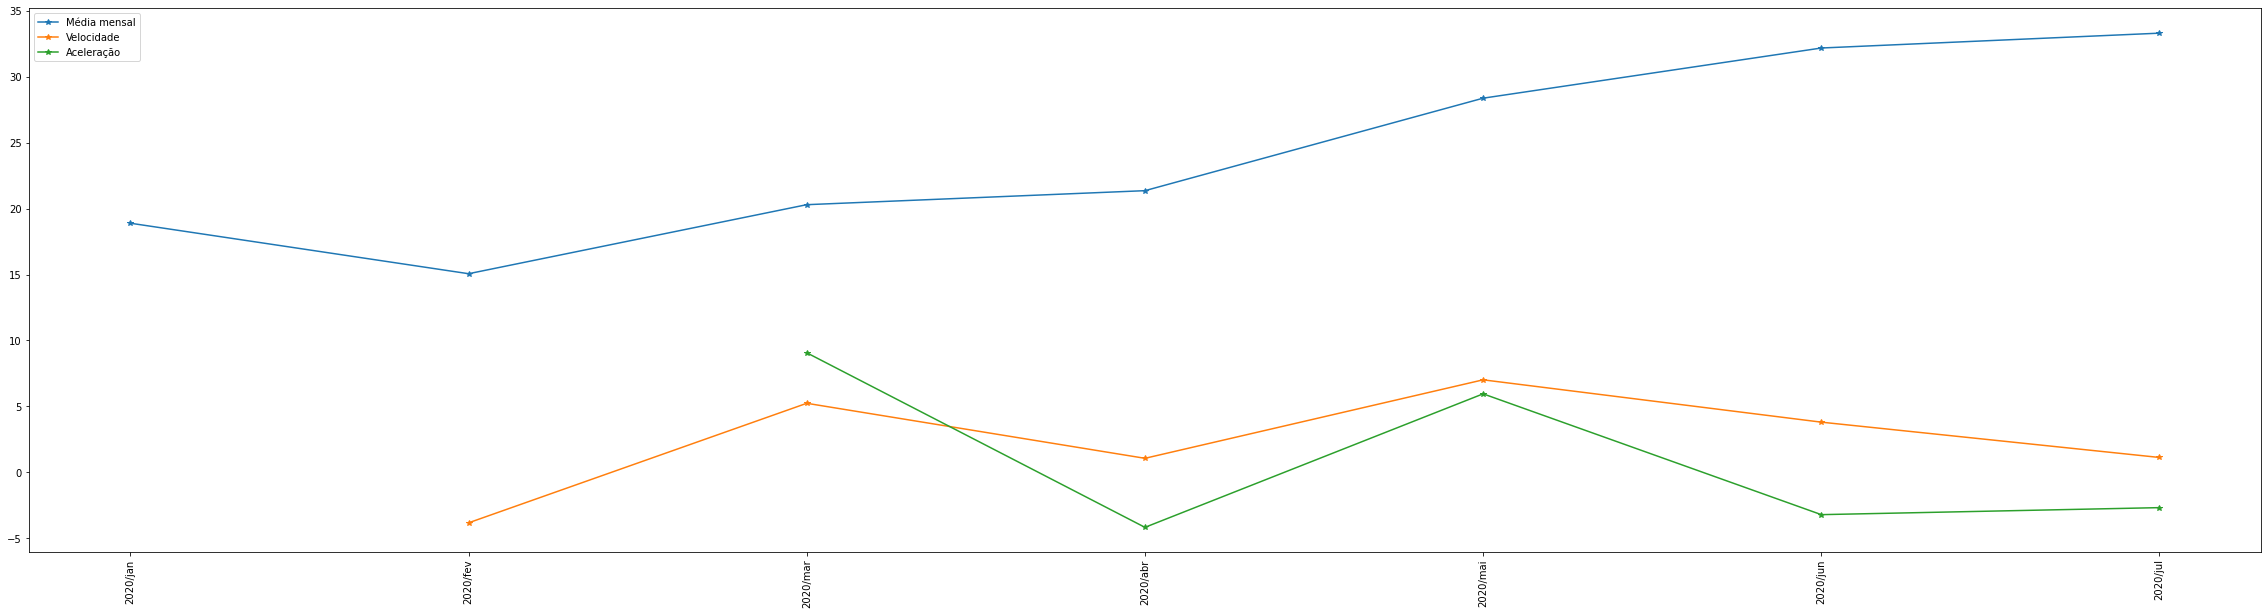

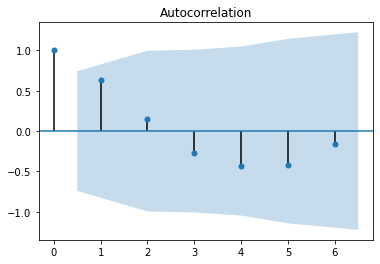

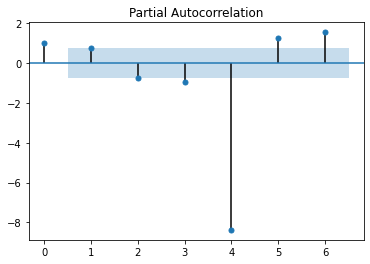

In [98]:
plt.figure(figsize=(40,10))
plt.plot(dados_mensais_medios_2020,'*-',label='Média mensal')
plt.plot(dados_mensais_medios_2020.diff(),'*-',label='Velocidade')
plt.plot(dados_mensais_medios_2020.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(dados_mensais_medios_2020.shape[0])],[i[0] for i in messes[21:28].values],rotation=90)
plt.legend(loc='best')
plot_acf(dados_mensais_medios_2020);
plot_pacf(dados_mensais_medios_2020);
plt.show()

# Juntando a série

In [99]:
serie_completa_2016 = pd.concat([dados_mensais_medios_2016,dados_mensais_medios_2017,dados_mensais_medios_2018,dados_mensais_medios_2019])
serie_completa_2016.reset_index(drop=True,inplace=True)

In [100]:
messes = pd.DataFrame({'Mes/ano':[]})
for j in ['2016','2017','2018','2019']:
    for i in ['jan','fev','mar','abr','mai','jun','jul']:
        messes = messes.append({"Mes/ano":j+'/'+i},ignore_index=True)

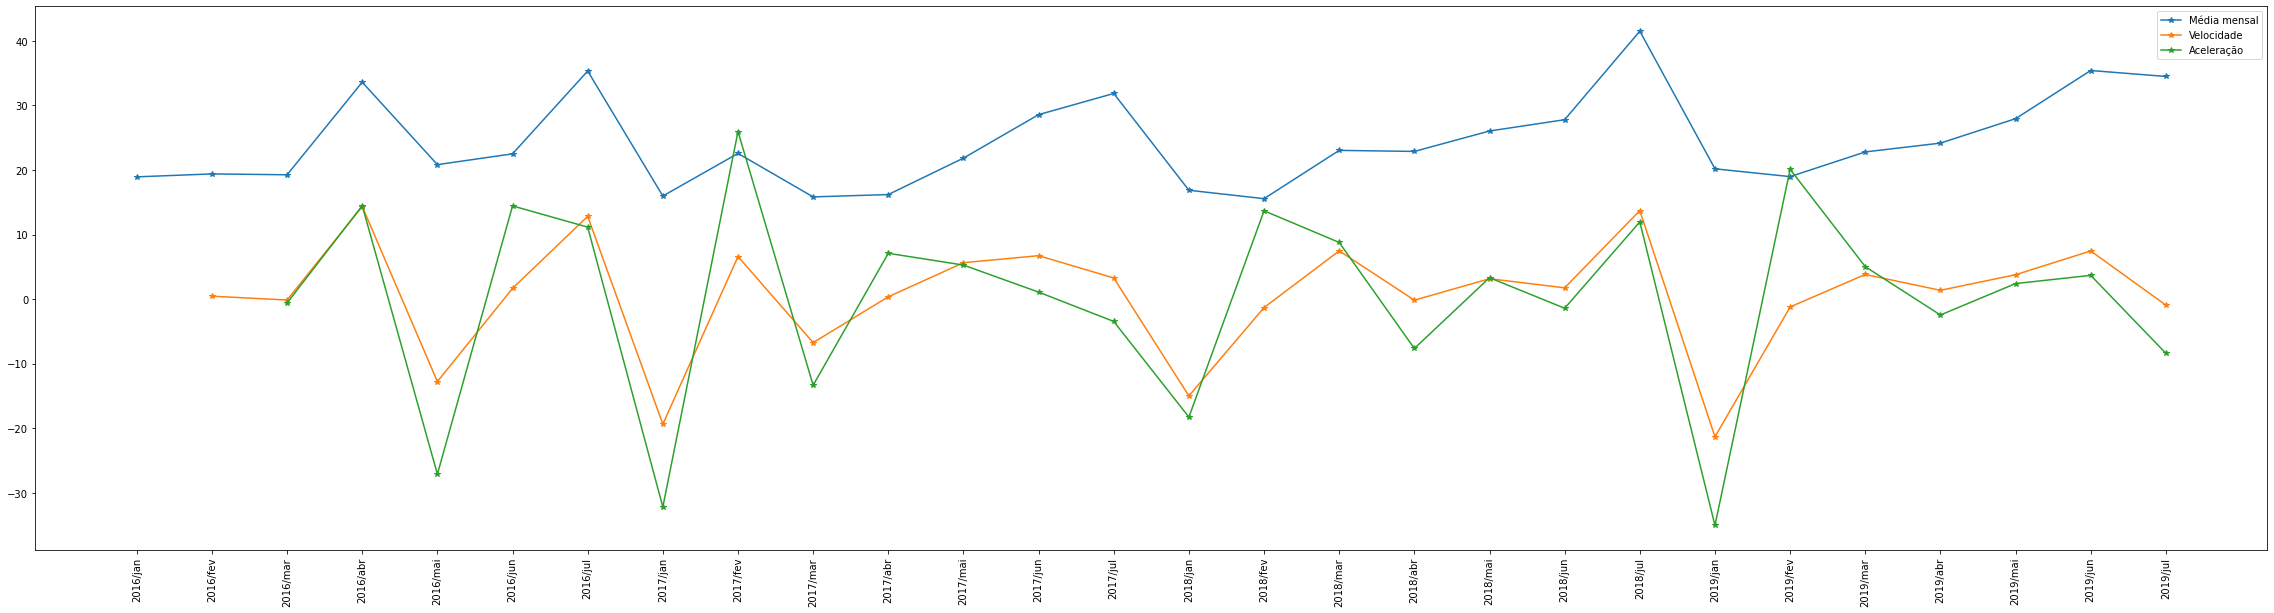

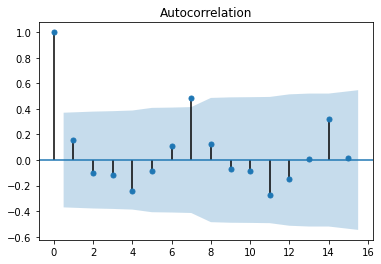

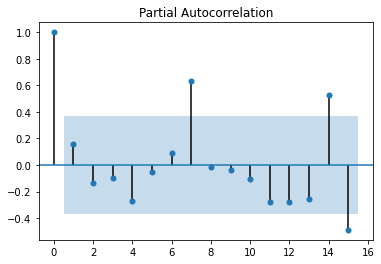

In [101]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_2016,'*-',label='Média mensal')
plt.plot(serie_completa_2016.diff(),'*-',label='Velocidade')
plt.plot(serie_completa_2016.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(serie_completa_2016.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plot_acf(serie_completa_2016);
plot_pacf(serie_completa_2016);
plt.show()

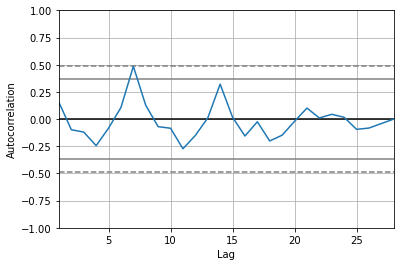

In [102]:
autocorrelation_plot(serie_completa_2016);

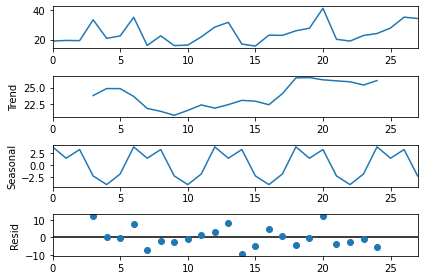

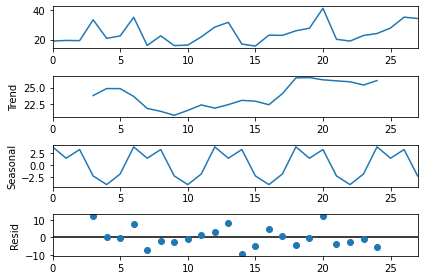

In [103]:
resultado_st = seasonal_decompose(serie_completa_2016,period=6)
resultado_st.plot()

# Juntando os dados a partir de 2017

In [104]:
serie_completa_2017 = pd.concat([dados_mensais_medios_2017,dados_mensais_medios_2018,dados_mensais_medios_2019,dados_mensais_medios_2020])
serie_completa_2017.reset_index(drop=True,inplace=True)

In [105]:
messes = pd.DataFrame({'Mes/ano':[]})
for j in ['2017','2018','2019','2020']:
    for i in ['jan','fev','mar','abr','mai','jun','jul']:
        messes = messes.append({"Mes/ano":j+'/'+i},ignore_index=True)

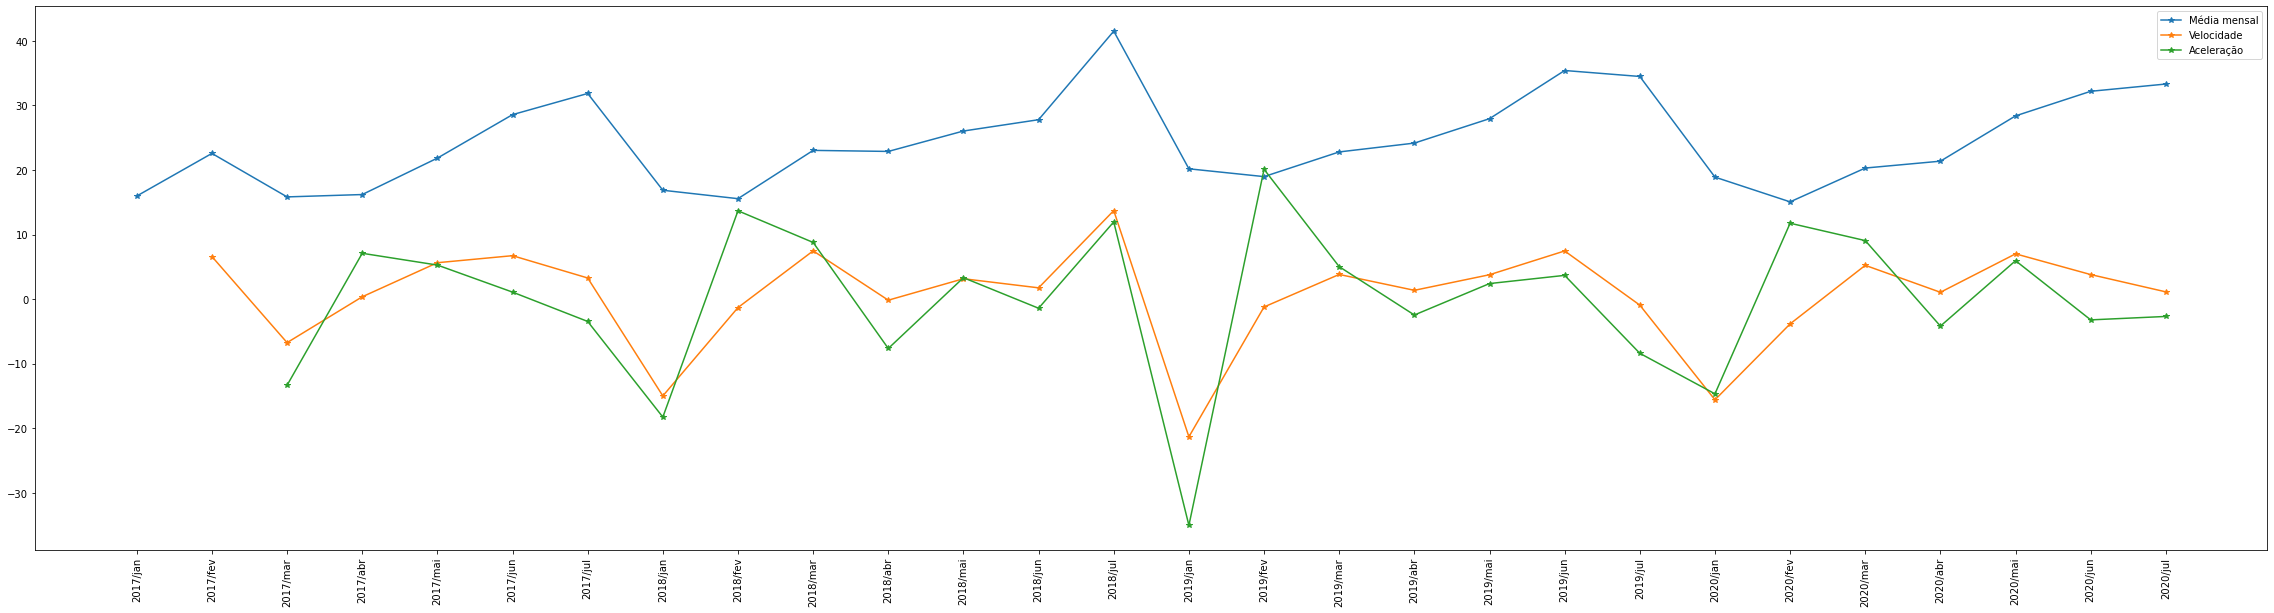

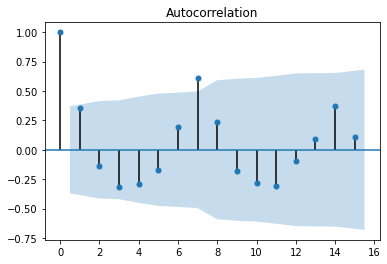

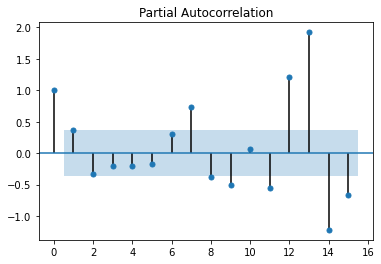

In [106]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_2017,'*-',label='Média mensal')
plt.plot(serie_completa_2017.diff(),'*-',label='Velocidade')
plt.plot(serie_completa_2017.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(serie_completa_2017.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plot_acf(serie_completa_2017);
plot_pacf(serie_completa_2017);
plt.show()

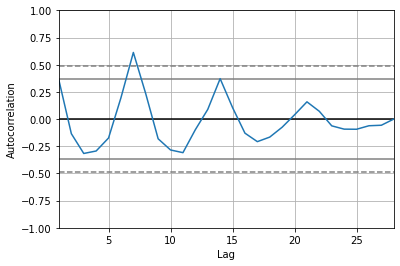

In [107]:
autocorrelation_plot(serie_completa_2017)

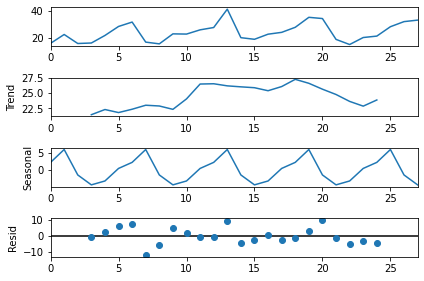

In [108]:
resultado_st = seasonal_decompose(serie_completa_2017,period=6)
resultado_st.plot();

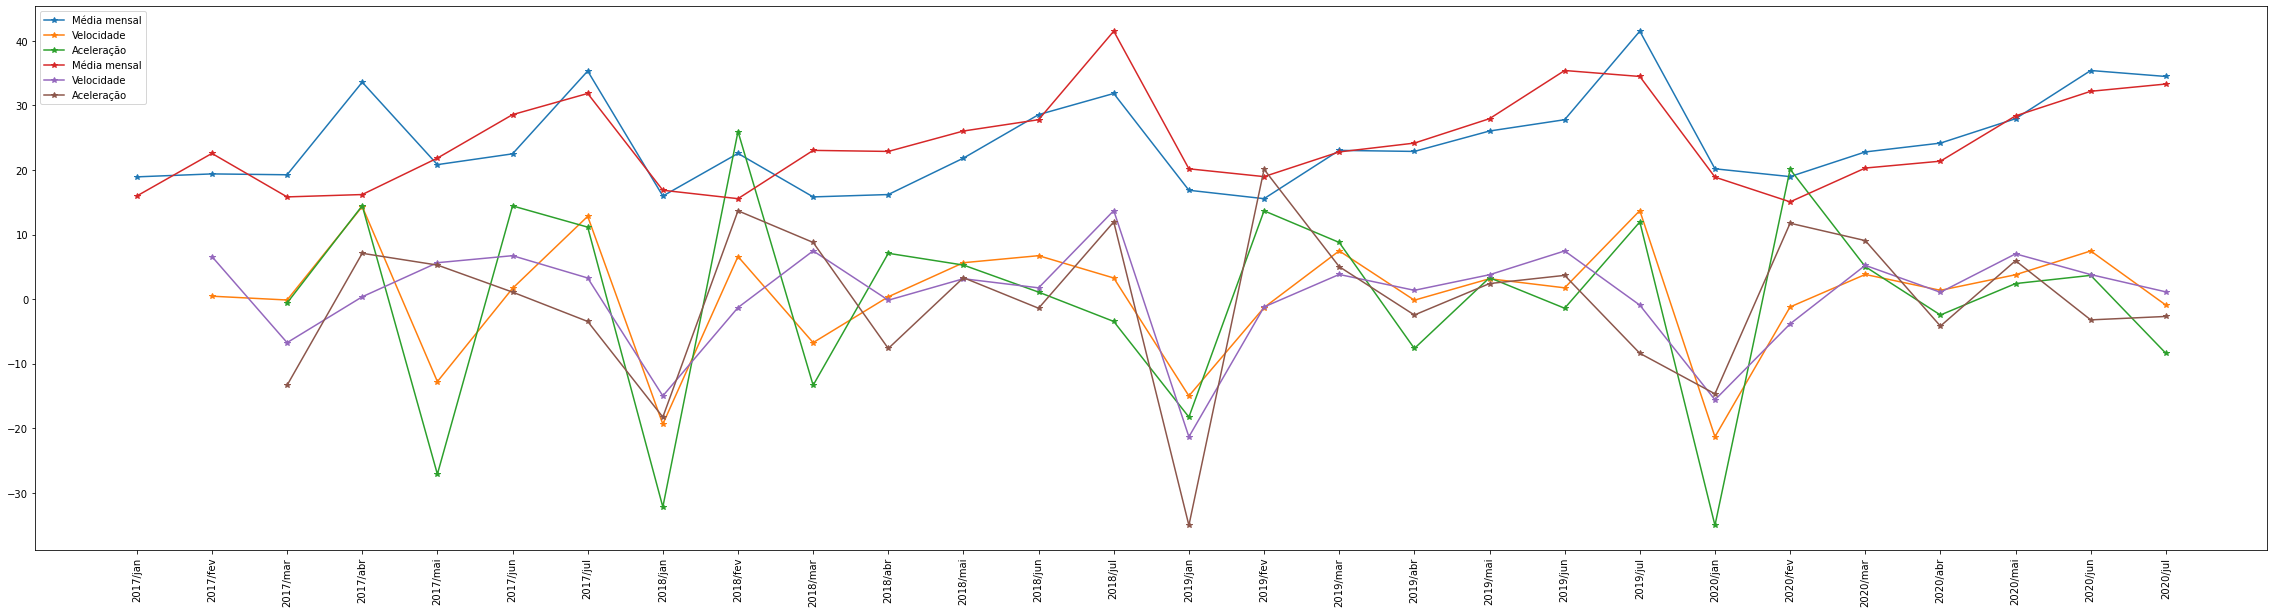

In [109]:
plt.figure(figsize=(40,10))
plt.plot(serie_completa_2016,'*-',label='Média mensal')
plt.plot(serie_completa_2016.diff(),'*-',label='Velocidade')
plt.plot(serie_completa_2016.diff().diff(),'*-',label='Aceleração')
plt.plot(serie_completa_2017,'*-',label='Média mensal')
plt.plot(serie_completa_2017.diff(),'*-',label='Velocidade')
plt.plot(serie_completa_2017.diff().diff(),'*-',label='Aceleração')
plt.xticks([i for i in range(serie_completa_2017.shape[0])],[i[0] for i in messes.values],rotation=90)
plt.legend(loc='best')
plt.show()